In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [2]:
import zipfile

zip_path = "anime_faces.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("AnimeFaces")

In [3]:
image_dir = "/content/AnimeFaces/anime faces/cropped"

image_files = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]

In [4]:
len(image_files)

30750

In [5]:
image_size = 64

def preprocess_image(image):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (image_size, image_size))
  image = image / 255.0
  image = tf.reshape(image, shape = (image_size, image_size, 3))
  return image

In [6]:
batch_size = 128

training_dataset = tf.data.Dataset.from_tensor_slices((image_files))
training_dataset = training_dataset.map(preprocess_image)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

In [7]:
len(training_dataset)

241

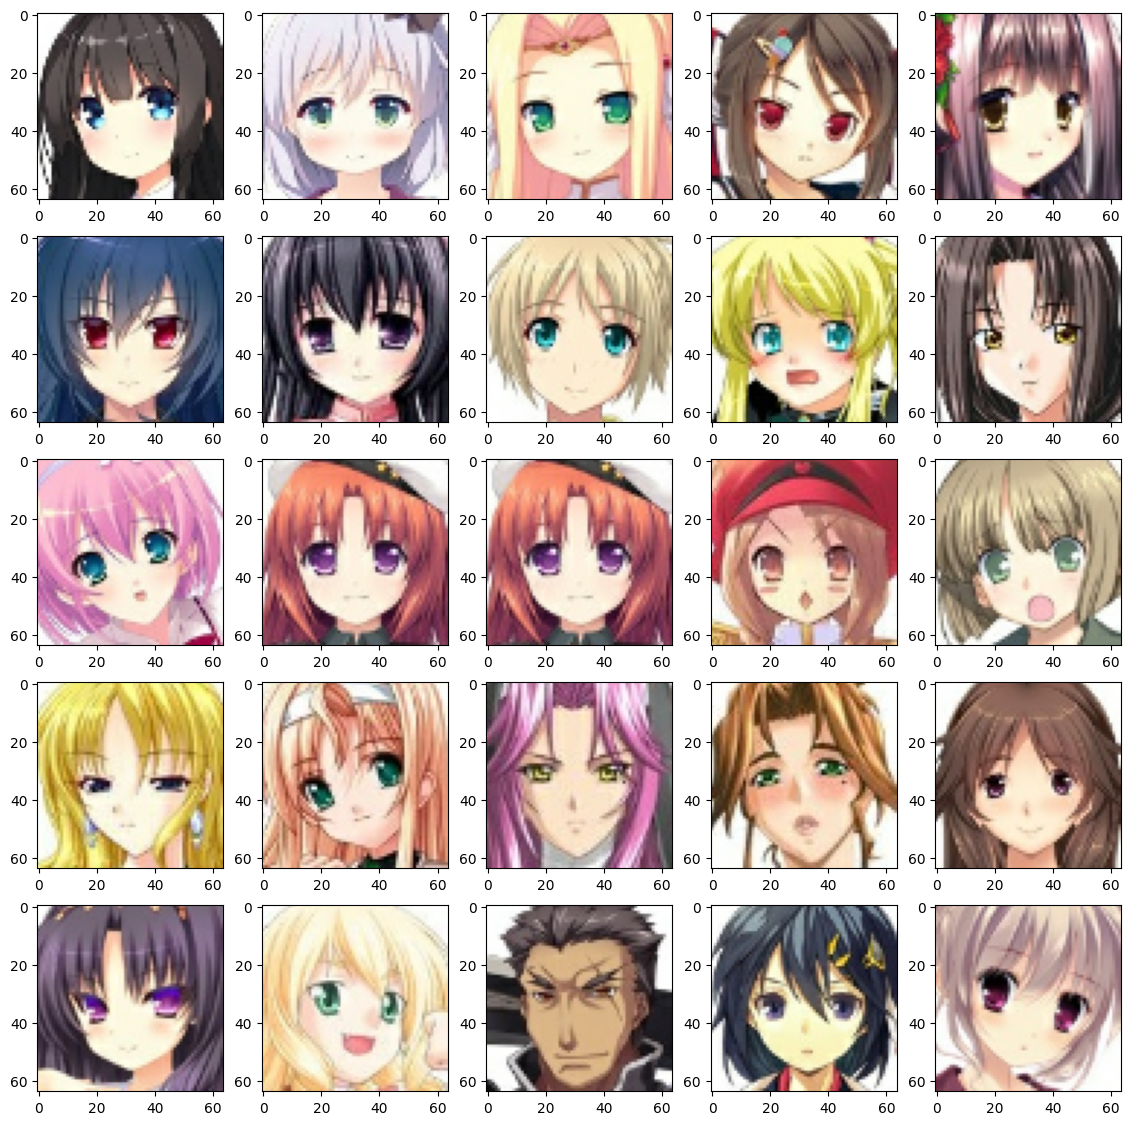

In [8]:
fig, axes = plt.subplots(5, 5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
  for col in range(5):
    axes[row,col].imshow(sample[idx])
    idx += 1

In [9]:
latent_dim = 512

In [10]:
from keras.models import Sequential, Model

from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, BatchNormalization, Lambda, LeakyReLU, Layer, Reshape
from keras.layers import Multiply, Add
from keras.activations import selu

from keras import backend as K

In [11]:
K.clear_session()

## Encoder

In [12]:
class SamplingLayer(Layer):
    def __init__(self, latent_dim, **kwargs):
        super(SamplingLayer, self).__init__(**kwargs)
        self.latent_dim = latent_dim

    def call(self, inputs):
        mu, log_var = inputs  # inputs: [mu, log_var]

        # === KL divergence loss ===
        kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
        self.add_loss(kl_loss)

        # === Reparameterization trick ===
        batch_size = tf.shape(mu)[0]
        epsilon = tf.random.normal(shape=(batch_size, self.latent_dim))
        sigma = tf.exp(0.5 * log_var)
        z = mu + sigma * epsilon
        return z

In [13]:
encoder_input = Input(shape = (image_size, image_size, 3))

x = Conv2D(32, (5,5), strides = 1, padding = "same")(encoder_input)
x = LeakyReLU(0.02)(x)
x = BatchNormalization()(x)

filter_size = [64, 128, 256, 512]
for i in filter_size:
  x = Conv2D(i, (5,5), strides = 2, padding = "same")(x)
  x = LeakyReLU(0.02)(x)
  x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

# Sampling
mu = Dense(latent_dim)(encoder_output)
log_var = Dense(latent_dim)(encoder_output)

z = SamplingLayer(latent_dim)([mu, log_var])

encoder = Model(encoder_input, [z, mu, log_var])
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      2,432 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    204,928 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │    819,456 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 8, 8, 256) │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ leaky_re_lu_3[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  3,277,312 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 4, 4, 512) │          0 │ conv2d_4[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ leaky_re_lu_4[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  8,389,632 │ flatten[0][0]   

 Total params: 13,802,688 (52.65 MB)

 Trainable params: 13,798,656 (52.64 MB)

 Non-trainable params: 4,032 (15.75 KB)

## Decoder

In [14]:
decoder = Sequential()

decoder.add(Dense(1024, activation = selu, input_dim = latent_dim))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), strides = 2, padding = "same"))
decoder.add(LeakyReLU(0.02))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), strides = 2, padding = "same"))
decoder.add(LeakyReLU(0.02))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), strides = 2, padding = "same"))
decoder.add(LeakyReLU(0.02))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), strides = 2, padding = "same"))
decoder.add(LeakyReLU(0.02))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (5,5), activation = "sigmoid", strides = 1, padding = "same"))
decoder.add(BatchNormalization())

decoder.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8192)           │     8,396,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     3,277,056 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 32)     │        51,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 3)      │         2,403 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,283,023 (50.67 MB)

 Trainable params: 13,280,009 (50.66 MB)

 Non-trainable params: 3,014 (11.77 KB)

## Loss Function

In [15]:
def reconstruction_loss(y, y_pred):
  return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
  loss = -0.5* tf.reduce_mean(log_var - tf.square(mu) - tf.exp(log_var) + 1)
  return loss

def vae_loss(y, y_pred, mu, log_var):
  reconstruction = reconstruction_loss(y, y_pred)
  kl = (1 / 64*64) * kl_loss(mu, log_var)
  return reconstruction + kl

In [16]:
mu, log_var, z = encoder(encoder_input)

reconstructed = decoder(z)

model = Model(encoder_input, reconstructed)
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ [(None, 512), (None,   │    13,802,688 │
│                                 │ 512), (None, 512)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 64, 64, 3)      │    13,283,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,085,711 (103.32 MB)

 Trainable params: 27,078,665 (103.30 MB)

 Non-trainable params: 7,046 (27.52 KB)

In [17]:
def save_image(model, epoch, step, input_):
  prediction = model.predict(input_)
  fig, axes = plt.subplots(5,5, figsize = (14,14))
  idx = 0

  for row in range(5):
    for col in range(5):
      image = prediction[idx,:,:,:] * 255
      image = image.astype("int32")
      axes[row, col].imshow(image)
      axes[row, col].axis("off")
      idx += 1
  output_path = "output/"
  if not os.path.exists(output_path):
    os.mkdir(output_path)
  plt.savefig(output_path + f"epoch_{epoch}_step_{step}.png")
  plt.close()

In [19]:
# train vae

from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))
save_image(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 10

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:
            reconstructed = model(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])

            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())

            kl = tf.reduce_sum(tf.stack(model.losses))
            kl_losses.append(kl.numpy())

            train_loss = 0.01 * kl + mse_loss

            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            if step % 10 == 0:
                save_image(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Epoch:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.09275446 - KL loss: 0.0016487257
Epoch: 1 - Step: 1 - MSE loss: 0.09404548 - KL loss: 0.0012094034
Epoch: 1 - Step: 2 - MSE loss: 0.09796134 - KL loss: 0.0009544211
Epoch: 1 - Step: 3 - MSE loss: 0.09567982 - KL loss: 0.0007005134
Epoch: 1 - Step: 4 - MSE loss: 0.09765407 - KL loss: 0.00056694756
Epoch: 1 - Step: 5 - MSE loss: 0.09489244 - KL loss: 0.00047046717
Epoch: 1 - Step: 6 - MSE loss: 0.096182264 - KL loss: 0.00045613066
Epoch: 1 - Step: 7 - MSE loss: 0.093935035 - KL loss: 0.00046166818
Epoch: 1 - Step: 8 - MSE loss: 0.0945231 - KL loss: 0.00054085586
Epoch: 1 - Step: 9 - MSE loss: 0.09403416 - KL loss: 0.0007493536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch: 1 - Step: 10 - MSE loss: 0.0956373 - KL loss: 0.0012396974
Epoch: 1 - Step: 11 - MSE loss: 0.09463766 - KL loss: 0.0024691797
Epoch: 1 - Step: 12 - MSE loss: 0.09535388 - KL loss: 0.006536505
Epoch: 1 - 

Epoch: 2 - Step: 180 - MSE loss: 0.036675695 - KL loss: 0.0076922774
Epoch: 2 - Step: 181 - MSE loss: 0.03561462 - KL loss: 0.011535155
Epoch: 2 - Step: 182 - MSE loss: 0.034110744 - KL loss: 0.010066369
Epoch: 2 - Step: 183 - MSE loss: 0.03579222 - KL loss: 0.011754716
Epoch: 2 - Step: 184 - MSE loss: 0.03826102 - KL loss: 0.008798112
Epoch: 2 - Step: 185 - MSE loss: 0.03464244 - KL loss: 0.008045983
Epoch: 2 - Step: 186 - MSE loss: 0.032385405 - KL loss: 0.007861774
Epoch: 2 - Step: 187 - MSE loss: 0.03165117 - KL loss: 0.010935968
Epoch: 2 - Step: 188 - MSE loss: 0.031119501 - KL loss: 0.010549762
Epoch: 2 - Step: 189 - MSE loss: 0.031312775 - KL loss: 0.010333646
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch: 2 - Step: 190 - MSE loss: 0.030704908 - KL loss: 0.011373874
Epoch: 2 - Step: 191 - MSE loss: 0.031685133 - KL loss: 0.011391431
Epoch: 2 - Step: 192 - MSE loss: 0.03063014 - KL loss: 0.010901593
Epoch: 2 - Step: 193 - MSE loss: 0.030398324 - KL loss: 0.010710179
Epoch: 2 - Step: 194 - MSE loss: 0.029505253 - KL loss: 0.011332041
Epoch: 2 - Step: 195 - MSE loss: 0.030658863 - KL loss: 0.011391204
Epoch: 2 - Step: 196 - MSE loss: 0.028529046 - KL loss: 0.01248935
Epoch: 2 - Step: 197 - MSE loss: 0.030415533 - KL loss: 0.011415271
Epoch: 2 - Step: 198 - MSE loss: 0.031167744 - KL loss: 0.013548814
Epoch: 2 - Step: 199 - MSE loss: 0.035243347 - KL loss: 0.010109041
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Epoch: 2 - Step: 200 - MSE loss: 0.032565817 - KL loss: 0.0074550677
Epoch: 2 - Step: 201 - MSE loss: 0.029982785 - KL loss: 0.00982742
Epoch: 2 - Step: 202 - MSE loss: 0.031243613 - KL loss: 0.011631716
Epoch: 2 - Step: 203 - MSE loss: 0.031111538 - KL loss: 0.011800315
Epoch: 2 - Step: 204 - MSE loss: 0.030620426 - KL loss: 0.010511494
Epoch: 2 - Step: 205 - MSE loss: 0.030014673 - KL loss: 0.010927824
Epoch: 2 - Step: 206 - MSE loss: 0.029236257 - KL loss: 0.010979608
Epoch: 2 - Step: 207 - MSE loss: 0.029536739 - KL loss: 0.011053406
Epoch: 2 - Step: 208 - MSE loss: 0.029184373 - KL loss: 0.0112256855
Epoch: 2 - Step: 209 - MSE loss: 0.029868418 - KL loss: 0.010783889
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch: 2 - Step: 210 - MSE loss: 0.031104555 - KL loss: 0.011053207
Epoch: 2 - Step: 211 - MSE loss: 0.030844746 - KL loss: 0.0104107065
Epoch: 2 - Step: 212 - MSE loss: 0.0295856 - KL loss: 0.010971039
Epoch: 2 - Step: 213 - MSE loss: 0.02876438 - KL loss: 0.010885903
Epoch: 2 - 

Epoch: 2 - Step: 220 - MSE loss: 0.030227968 - KL loss: 0.01269879
Epoch: 2 - Step: 221 - MSE loss: 0.029170917 - KL loss: 0.011888018
Epoch: 2 - Step: 222 - MSE loss: 0.029063081 - KL loss: 0.0132498965
Epoch: 2 - Step: 223 - MSE loss: 0.030418016 - KL loss: 0.012009936
Epoch: 2 - Step: 224 - MSE loss: 0.029409966 - KL loss: 0.010982377
Epoch: 2 - Step: 225 - MSE loss: 0.027673015 - KL loss: 0.011064032
Epoch: 2 - Step: 226 - MSE loss: 0.027813174 - KL loss: 0.012519678
Epoch: 2 - Step: 227 - MSE loss: 0.028364459 - KL loss: 0.012253549
Epoch: 2 - Step: 228 - MSE loss: 0.027557015 - KL loss: 0.012583746
Epoch: 2 - Step: 229 - MSE loss: 0.027901927 - KL loss: 0.012633854
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 2 - Step: 230 - MSE loss: 0.028479666 - KL loss: 0.013423148
Epoch: 2 - Step: 231 - MSE loss: 0.03204267 - KL loss: 0.012388198
Epoch: 2 - Step: 232 - MSE loss: 0.029822545 - KL loss: 0.009676495
Epoch: 2 - Step: 233 - MSE loss: 0.03257696 - KL loss: 0.010876885
Epoch: 2 - Step: 234 - MSE loss: 0.031142643 - KL loss: 0.011370461
Epoch: 2 - Step: 235 - MSE loss: 0.030338468 - KL loss: 0.011010544
Epoch: 2 - Step: 236 - MSE loss: 0.0294587 - KL loss: 0.010164495
Epoch: 2 - Step: 237 - MSE loss: 0.028270215 - KL loss: 0.012365717
Epoch: 2 - Step: 238 - MSE loss: 0.030301912 - KL loss: 0.0125708
Epoch: 2 - Step: 239 - MSE loss: 0.027237715 - KL loss: 0.012674755
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Epoch: 2 - Step: 240 - MSE loss: 0.028382126 - KL loss: 0.0121977115
Epoch:  3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 3 - Step: 0 - MSE loss: 0.028338311 - KL loss: 0.011520749
Epoch: 3 - Step: 1 - MSE loss: 0.027244529 - KL loss: 0.01228727
Epoch: 3 - Step: 2 - MSE loss: 0.025275858 - KL loss: 0.012449597
Epoch: 3 - Step: 3 - MSE loss: 0.027192285 - KL loss: 0.012482651
Epoch: 3 - Step: 4 - MSE loss: 0.027496794 - KL loss: 0.0130176665
Epoch: 3 - Step: 5 - MSE loss: 0.027245171 - KL loss: 0.011867053
Epoch: 3 - Step: 6 - MSE loss: 0.029943228 - KL loss: 0.012537813
Epoch: 3 - Step: 7 - MSE loss: 0.028853796 - KL loss: 0.012020044
Epoch: 3 - Step: 8 - MSE loss: 0.029560542 - KL loss: 0.014154343
Epoch: 3 - Step: 9 - MSE loss: 0.029296437 - KL loss: 0.012246008
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Epoch: 3 - Step: 10 - MSE loss: 0.028498001 - KL loss: 0.010258285
Epoch: 3 - Step: 11 - MSE loss: 0.02664757 - KL loss: 0.010516
Epoch: 3 - Step: 12 - MSE loss: 0.028187295 - KL loss: 0.012110218
Epoch: 3 - Step: 13 - MSE loss: 0.027591636 - KL loss: 0.013174752
Epoch: 3 - Step: 14 - MSE loss: 0.027599385 - KL loss: 0.012338312
Epoch: 3 - Step: 15 - MSE loss: 0.02697965 - KL loss: 0.012616435
Epoch: 3 - Step: 16 - MSE loss: 0.025673432 - KL loss: 0.012639146
Epoch: 3 - Step: 17 - MSE loss: 0.026869932 - KL loss: 0.012273552
Epoch: 3 - Step: 18 - MSE loss: 0.026833504 - KL loss: 0.012114899
Epoch: 3 - Step: 19 - MSE loss: 0.027009368 - KL loss: 0.013053496
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 3 - Step: 20 - MSE loss: 0.027871763 - KL loss: 0.012333667
Epoch: 3 - Step: 21 - MSE loss: 0.02635636 - KL loss: 0.012009298
Epoch: 3 - Step: 22 - MSE loss: 0.026728177 - KL loss: 0.012155311
Epoch: 3 - Step: 23 - MSE loss: 0.027135449 - KL loss: 0.01158424
Epoch: 3 - Step: 24 - MSE loss: 0.026276924 - KL loss: 0.012292543
Epoch: 3 - Step: 25 - MSE loss: 0.027393756 - KL loss: 0.012824595
Epoch: 3 - Step: 26 - MSE loss: 0.02783481 - KL loss: 0.013102157
Epoch: 3 - Step: 27 - MSE loss: 0.027856568 - KL loss: 0.012754098
Epoch: 3 - Step: 28 - MSE loss: 0.028471842 - KL loss: 0.0136753805
Epoch: 3 - Step: 29 - MSE loss: 0.031378265 - KL loss: 0.012059165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Epoch: 3 - Step: 30 - MSE loss: 0.029785434 - KL loss: 0.009734711
Epoch: 3 - Step: 31 - MSE loss: 0.029053204 - KL loss: 0.01047682
Epoch: 3 - Step: 32 - MSE loss: 0.029144326 - KL loss: 0.010848269
Epoch: 3 - Step: 33 - MSE loss: 0.02814175 - KL loss: 0.012265431
Epoch: 3 - Step: 34 - MSE loss: 0.027179101 - KL loss: 0.010441168
Epoch: 3 - Step: 35 - MSE loss: 0.026990905 - KL loss: 0.010578619
Epoch: 3 - Step: 36 - MSE loss: 0.027221175 - KL loss: 0.010958852
Epoch: 3 - Step: 37 - MSE loss: 0.027182303 - KL loss: 0.012126464
Epoch: 3 - Step: 38 - MSE loss: 0.026738986 - KL loss: 0.011826025
Epoch: 3 - Step: 39 - MSE loss: 0.025969585 - KL loss: 0.011336837
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch: 3 - Step: 40 - MSE loss: 0.027064256 - KL loss: 0.01186136
Epoch: 3 - Step: 41 - MSE loss: 0.026906632 - KL loss: 0.01147474
Epoch: 3 - Step: 42 - MSE loss: 0.02614478 - KL loss: 0.011308749
Epoch: 3 - Step: 43 - MSE loss: 0.027824111 - KL loss: 0.012617969
Epoch: 3 - Step: 44 - MSE loss: 0.026913658 - KL loss: 0.01139482
Epoch: 3 - Step: 45 - MSE loss: 0.027033808 - KL loss: 0.011642995
Epoch: 3 - Step: 46 - MSE loss: 0.026582986 - KL loss: 0.01102643
Epoch: 3 - Step: 47 - MSE loss: 0.025920609 - KL loss: 0.011690479
Epoch: 3 - Step: 48 - MSE loss: 0.02574637 - KL loss: 0.011849363
Epoch: 3 - Step: 49 - MSE loss: 0.026403904 - KL loss: 0.01163939
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Epoch: 3 - Step: 50 - MSE loss: 0.025229556 - KL loss: 0.010964171
Epoch: 3 - Step: 51 - MSE loss: 0.02687907 - KL loss: 0.012428292
Epoch: 3 - Step: 52 - MSE loss: 0.027547002 - KL loss: 0.012166641
Epoch: 3 - Step: 53 - MSE loss: 0.0278017 - KL loss: 0.012139351
Epoch: 3 - Step: 54 - MSE loss: 0.027061714 - KL loss: 0.01137323
Epoch: 3 - Step: 55 - MSE loss: 0.027900808 - KL loss: 0.01223275
Epoch: 3 - Step: 56 - MSE loss: 0.02747885 - KL loss: 0.010561975
Epoch: 3 - Step: 57 - MSE loss: 0.02800584 - KL loss: 0.012276629
Epoch: 3 - Step: 58 - MSE loss: 0.027321784 - KL loss: 0.01075255
Epoch: 3 - Step: 59 - MSE loss: 0.026933508 - KL loss: 0.011449764
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 3 - Step: 60 - MSE loss: 0.026877731 - KL loss: 0.011395659
Epoch: 3 - Step: 61 - MSE loss: 0.025228463 - KL loss: 0.011821148
Epoch: 3 - Step: 62 - MSE loss: 0.026134692 - KL loss: 0.012200389
Epoch: 3 - Step: 63 - MSE loss: 0.026277246 - KL loss: 0.0117122205
Epoch: 3 - Step: 64 - MSE loss: 0.02707559 - KL loss: 0.011372559
Epoch: 3 - Step: 65 - MSE loss: 0.025421126 - KL loss: 0.01143701
Epoch: 3 - Step: 66 - MSE loss: 0.028364887 - KL loss: 0.011811711
Epoch: 3 - Step: 67 - MSE loss: 0.026227407 - KL loss: 0.011854066
Epoch: 3 - Step: 68 - MSE loss: 0.027447201 - KL loss: 0.011122884
Epoch: 3 - Step: 69 - MSE loss: 0.027425252 - KL loss: 0.010862587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Epoch: 3 - Step: 70 - MSE loss: 0.0283444 - KL loss: 0.011376924
Epoch: 3 - Step: 71 - MSE loss: 0.026836326 - KL loss: 0.012010872
Epoch: 3 - Step: 72 - MSE loss: 0.027202591 - KL loss: 0.011544932
Epoch: 3 - Step: 73 - MSE loss: 0.02596846 - KL loss: 0.010880245
Epoch: 3 - Step: 74 - MSE loss: 0.026600182 - KL loss: 0.012588553
Epoch: 3 - Step: 75 - MSE loss: 0.026152909 - KL loss: 0.0115874205
Epoch: 3 - Step: 76 - MSE loss: 0.025782006 - KL loss: 0.01178924
Epoch: 3 - Step: 77 - MSE loss: 0.025726149 - KL loss: 0.011269977
Epoch: 3 - Step: 78 - MSE loss: 0.025146635 - KL loss: 0.012086485
Epoch: 3 - Step: 79 - MSE loss: 0.026563695 - KL loss: 0.011887638
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Epoch: 3 - Step: 80 - MSE loss: 0.024547914 - KL loss: 0.012081755
Epoch: 3 - Step: 81 - MSE loss: 0.026305677 - KL loss: 0.012050169
Epoch: 3 - Step: 82 - MSE loss: 0.026057566 - KL loss: 0.010877488
Epoch: 3 - Step: 83 - MSE loss: 0.026516408 - KL loss: 0.011134639
Epoch: 3 - Step: 84 - MSE loss: 0.02665189 - KL loss: 0.011304768
Epoch: 3 - Step: 85 - MSE loss: 0.02593035 - KL loss: 0.011323193
Epoch: 3 - Step: 86 - MSE loss: 0.025336573 - KL loss: 0.011016982
Epoch: 3 - Step: 87 - MSE loss: 0.024077395 - KL loss: 0.011883754
Epoch: 3 - Step: 88 - MSE loss: 0.025722152 - KL loss: 0.0116143
Epoch: 3 - Step: 89 - MSE loss: 0.02628532 - KL loss: 0.011257981
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch: 3 - Step: 90 - MSE loss: 0.025423668 - KL loss: 0.011503111
Epoch: 3 - Step: 91 - MSE loss: 0.025719939 - KL loss: 0.011393966
Epoch: 3 - Step: 92 - MSE loss: 0.024833558 - KL loss: 0.011901677
Epoch: 3 - Step: 93 - MSE loss: 0.026461862 - KL loss: 0.012195267
Epoch: 3 - Step: 94 - MSE loss: 0.023900285 - KL loss: 0.010544967
Epoch: 3 - Step: 95 - MSE loss: 0.026138917 - KL loss: 0.01169762
Epoch: 3 - Step: 96 - MSE loss: 0.02656369 - KL loss: 0.011500229
Epoch: 3 - Step: 97 - MSE loss: 0.032033734 - KL loss: 0.012709215
Epoch: 3 - Step: 98 - MSE loss: 0.033088014 - KL loss: 0.009665711
Epoch: 3 - Step: 99 - MSE loss: 0.032447714 - KL loss: 0.010976441
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 3 - Step: 100 - MSE loss: 0.028895179 - KL loss: 0.009765253
Epoch: 3 - Step: 101 - MSE loss: 0.028580504 - KL loss: 0.010237681
Epoch: 3 - Step: 102 - MSE loss: 0.028630683 - KL loss: 0.008561046
Epoch: 3 - Step: 103 - MSE loss: 0.02789721 - KL loss: 0.008954639
Epoch: 3 - Step: 104 - MSE loss: 0.026332958 - KL loss: 0.011624869
Epoch: 3 - Step: 105 - MSE loss: 0.026570387 - KL loss: 0.010719683
Epoch: 3 - Step: 106 - MSE loss: 0.026464509 - KL loss: 0.011138186
Epoch: 3 - Step: 107 - MSE loss: 0.026459048 - KL loss: 0.011232214
Epoch: 3 - Step: 108 - MSE loss: 0.02488554 - KL loss: 0.010133299
Epoch: 3 - Step: 109 - MSE loss: 0.025852768 - KL loss: 0.010287844
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 3 - Step: 110 - MSE loss: 0.025311625 - KL loss: 0.0097449925
Epoch: 3 - Step: 111 - MSE loss: 0.026536182 - KL loss: 0.010381702
Epoch: 3 - Step: 112 - MSE loss: 0.028190216 - KL loss: 0.010346246
Epoch: 3 - Step: 113 - MSE loss: 0.029135555 - KL loss: 0.011596901
Epoch: 3 - Step: 114 - MSE loss: 0.026227668 - KL loss: 0.010115094
Epoch: 3 - Step: 115 - MSE loss: 0.027394295 - KL loss: 0.009725728
Epoch: 3 - Step: 116 - MSE loss: 0.026146144 - KL loss: 0.010913414
Epoch: 3 - Step: 117 - MSE loss: 0.025613757 - KL loss: 0.011616422
Epoch: 3 - Step: 118 - MSE loss: 0.026384542 - KL loss: 0.01096646
Epoch: 3 - Step: 119 - MSE loss: 0.025017066 - KL loss: 0.0114440955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 3 - Step: 120 - MSE loss: 0.025579141 - KL loss: 0.0113891475
Epoch: 3 - Step: 121 - MSE loss: 0.025440447 - KL loss: 0.011699482
Epoch: 3 - Step: 122 - MSE loss: 0.024966726 - KL loss: 0.011406574
Epoch: 3 - Step: 123 - MSE loss: 0.024701556 - KL loss: 0.010722807
Epoch: 3 - Step: 124 - MSE loss: 0.026029779 - KL loss: 0.010502027
Epoch: 3 - Step: 125 - MSE loss: 0.024813527 - KL loss: 0.010638069
Epoch: 3 - Step: 126 - MSE loss: 0.024187794 - KL loss: 0.010604799
Epoch: 3 - Step: 127 - MSE loss: 0.025050292 - KL loss: 0.0110520385
Epoch: 3 - Step: 128 - MSE loss: 0.024545426 - KL loss: 0.01072238
Epoch: 3 - Step: 129 - MSE loss: 0.025268903 - KL loss: 0.01086552
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch: 3 - Step: 130 - MSE loss: 0.025234342 - KL loss: 0.011284245
Epoch: 3 - Step: 131 - MSE loss: 0.025323575 - KL loss: 0.0107681155
Epoch: 3 - Step: 132 - MSE loss: 0.02460228 - KL loss: 0.010829743
Epoch: 3 - Step: 133 - MSE loss: 0.026219772 - KL loss: 0.011230199
Epoch: 3 - Step: 134 - MSE loss: 0.024893323 - KL loss: 0.010693889
Epoch: 3 - Step: 135 - MSE loss: 0.025679953 - KL loss: 0.010352923
Epoch: 3 - Step: 136 - MSE loss: 0.028473482 - KL loss: 0.010550302
Epoch: 3 - Step: 137 - MSE loss: 0.026325205 - KL loss: 0.009271601
Epoch: 3 - Step: 138 - MSE loss: 0.026294408 - KL loss: 0.010543143
Epoch: 3 - Step: 139 - MSE loss: 0.025567124 - KL loss: 0.010308221
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch: 3 - Step: 140 - MSE loss: 0.026346678 - KL loss: 0.010675805
Epoch: 3 - Step: 141 - MSE loss: 0.024124349 - KL loss: 0.011466717
Epoch: 3 - Step: 142 - MSE loss: 0.024947902 - KL loss: 0.010737383
Epoch: 3 - Step: 143 - MSE loss: 0.026863271 - KL loss: 0.01048314
Epoch: 3 - Step: 144 - MSE loss: 0.025407946 - KL loss: 0.009958575
Epoch: 3 - Step: 145 - MSE loss: 0.025981441 - KL loss: 0.010166202
Epoch: 3 - Step: 146 - MSE loss: 0.02458684 - KL loss: 0.009260053
Epoch: 3 - Step: 147 - MSE loss: 0.024966367 - KL loss: 0.011539923
Epoch: 3 - Step: 148 - MSE loss: 0.023787541 - KL loss: 0.009493488
Epoch: 3 - Step: 149 - MSE loss: 0.02430594 - KL loss: 0.01077291
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 3 - Step: 150 - MSE loss: 0.025571348 - KL loss: 0.010893311
Epoch: 3 - Step: 151 - MSE loss: 0.023947896 - KL loss: 0.010859389
Epoch: 3 - Step: 152 - MSE loss: 0.02406642 - KL loss: 0.010209675
Epoch: 3 - Step: 153 - MSE loss: 0.024311326 - KL loss: 0.011023203
Epoch: 3 - Step: 154 - MSE loss: 0.024828961 - KL loss: 0.010580127
Epoch: 3 - Step: 155 - MSE loss: 0.023903893 - KL loss: 0.010728686
Epoch: 3 - Step: 156 - MSE loss: 0.024269948 - KL loss: 0.010546867
Epoch: 3 - Step: 157 - MSE loss: 0.02525348 - KL loss: 0.010613506
Epoch: 3 - Step: 158 - MSE loss: 0.02583892 - KL loss: 0.010984763
Epoch: 3 - Step: 159 - MSE loss: 0.024647392 - KL loss: 0.010667936
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 3 - Step: 160 - MSE loss: 0.025398644 - KL loss: 0.01102834
Epoch: 3 - Step: 161 - MSE loss: 0.025404388 - KL loss: 0.01069775
Epoch: 3 - Step: 162 - MSE loss: 0.026175097 - KL loss: 0.0094114635
Epoch: 3 - Step: 163 - MSE loss: 0.025669158 - KL loss: 0.011032363
Epoch: 3 - Step: 164 - MSE loss: 0.0247744 - KL loss: 0.010538794
Epoch: 3 - Step: 165 - MSE loss: 0.024997503 - KL loss: 0.010713873
Epoch: 3 - Step: 166 - MSE loss: 0.025439905 - KL loss: 0.011376485
Epoch: 3 - Step: 167 - MSE loss: 0.02546885 - KL loss: 0.011334868
Epoch: 3 - Step: 168 - MSE loss: 0.025063604 - KL loss: 0.010552187
Epoch: 3 - Step: 169 - MSE loss: 0.025581822 - KL loss: 0.010112409
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 3 - Step: 170 - MSE loss: 0.024784183 - KL loss: 0.010523934
Epoch: 3 - Step: 171 - MSE loss: 0.024921397 - KL loss: 0.01093492
Epoch: 3 - Step: 172 - MSE loss: 0.024460109 - KL loss: 0.010778535
Epoch: 3 - Step: 173 - MSE loss: 0.02474839 - KL loss: 0.01058398
Epoch: 3 - Step: 174 - MSE loss: 0.023856282 - KL loss: 0.010349266
Epoch: 3 - Step: 175 - MSE loss: 0.023298202 - KL loss: 0.010142636
Epoch: 3 - Step: 176 - MSE loss: 0.025355848 - KL loss: 0.010938934
Epoch: 3 - Step: 177 - MSE loss: 0.025051475 - KL loss: 0.011522111
Epoch: 3 - Step: 178 - MSE loss: 0.025704756 - KL loss: 0.011193046
Epoch: 3 - Step: 179 - MSE loss: 0.026256805 - KL loss: 0.009624953
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 3 - Step: 180 - MSE loss: 0.026682993 - KL loss: 0.009776248
Epoch: 3 - Step: 181 - MSE loss: 0.024283892 - KL loss: 0.010124447
Epoch: 3 - Step: 182 - MSE loss: 0.024172442 - KL loss: 0.011136786
Epoch: 3 - Step: 183 - MSE loss: 0.024676403 - KL loss: 0.01089243
Epoch: 3 - Step: 184 - MSE loss: 0.025209596 - KL loss: 0.010467861
Epoch: 3 - Step: 185 - MSE loss: 0.02520957 - KL loss: 0.009831008
Epoch: 3 - Step: 186 - MSE loss: 0.024165655 - KL loss: 0.01025689
Epoch: 3 - Step: 187 - MSE loss: 0.02400802 - KL loss: 0.010119423
Epoch: 3 - Step: 188 - MSE loss: 0.024585374 - KL loss: 0.010638513
Epoch: 3 - Step: 189 - MSE loss: 0.02419543 - KL loss: 0.010278329
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 3 - Step: 190 - MSE loss: 0.024213275 - KL loss: 0.010728064
Epoch: 3 - Step: 191 - MSE loss: 0.024767684 - KL loss: 0.01032373
Epoch: 3 - Step: 192 - MSE loss: 0.025313737 - KL loss: 0.010874387
Epoch: 3 - Step: 193 - MSE loss: 0.025155747 - KL loss: 0.011683796
Epoch: 3 - Step: 194 - MSE loss: 0.025585065 - KL loss: 0.0102491565
Epoch: 3 - Step: 195 - MSE loss: 0.023746565 - KL loss: 0.009233499
Epoch: 3 - Step: 196 - MSE loss: 0.023948492 - KL loss: 0.009524539
Epoch: 3 - Step: 197 - MSE loss: 0.025215859 - KL loss: 0.010727458
Epoch: 3 - Step: 198 - MSE loss: 0.023552708 - KL loss: 0.010590617
Epoch: 3 - Step: 199 - MSE loss: 0.023719482 - KL loss: 0.010816564
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Epoch: 3 - Step: 200 - MSE loss: 0.024384521 - KL loss: 0.009746319
Epoch: 3 - Step: 201 - MSE loss: 0.023641827 - KL loss: 0.010093516
Epoch: 3 - Step: 202 - MSE loss: 0.024154596 - KL loss: 0.009649176
Epoch: 3 - Step: 203 - MSE loss: 0.025198879 - KL loss: 0.010277358
Epoch: 3 - Step: 204 - MSE loss: 0.025150314 - KL loss: 0.009854651
Epoch: 3 - Step: 205 - MSE loss: 0.023676103 - KL loss: 0.011187846
Epoch: 3 - Step: 206 - MSE loss: 0.025194542 - KL loss: 0.01113574
Epoch: 3 - Step: 207 - MSE loss: 0.024423108 - KL loss: 0.009534983
Epoch: 3 - Step: 208 - MSE loss: 0.024355033 - KL loss: 0.0093414085
Epoch: 3 - Step: 209 - MSE loss: 0.026199823 - KL loss: 0.011313566
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 3 - Step: 210 - MSE loss: 0.024746345 - KL loss: 0.010666991
Epoch: 3 - Step: 211 - MSE loss: 0.026090821 - KL loss: 0.010274949
Epoch: 3 - Step: 212 - MSE loss: 0.025266089 - KL loss: 0.011135155
Epoch: 3 - Step: 213 - MSE loss: 0.02479337 - KL loss: 0.009970259
Epoch: 3 - Step: 214 - MSE loss: 0.023196585 - KL loss: 0.009842138
Epoch: 3 - Step: 215 - MSE loss: 0.02472353 - KL loss: 0.010141513
Epoch: 3 - Step: 216 - MSE loss: 0.024046274 - KL loss: 0.01002047
Epoch: 3 - Step: 217 - MSE loss: 0.024334589 - KL loss: 0.009845688
Epoch: 3 - Step: 218 - MSE loss: 0.022649689 - KL loss: 0.01055811
Epoch: 3 - Step: 219 - MSE loss: 0.023902806 - KL loss: 0.010086173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch: 3 - Step: 220 - MSE loss: 0.02421551 - KL loss: 0.011363551
Epoch: 3 - Step: 221 - MSE loss: 0.02444048 - KL loss: 0.010297691
Epoch: 3 - Step: 222 - MSE loss: 0.024098678 - KL loss: 0.010265982
Epoch: 3 - Step: 223 - MSE loss: 0.026809016 - KL loss: 0.010881871
Epoch: 3 - Step: 224 - MSE loss: 0.026079422 - KL loss: 0.010736566
Epoch: 3 - Step: 225 - MSE loss: 0.025097588 - KL loss: 0.009576209
Epoch: 3 - Step: 226 - MSE loss: 0.0231483 - KL loss: 0.010553686
Epoch: 3 - Step: 227 - MSE loss: 0.024088437 - KL loss: 0.010123422
Epoch: 3 - Step: 228 - MSE loss: 0.022185242 - KL loss: 0.010171631
Epoch: 3 - Step: 229 - MSE loss: 0.025179012 - KL loss: 0.010191472
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 3 - Step: 230 - MSE loss: 0.023087895 - KL loss: 0.010025784
Epoch: 3 - Step: 231 - MSE loss: 0.023465304 - KL loss: 0.009905243
Epoch: 3 - Step: 232 - MSE loss: 0.023681732 - KL loss: 0.010079204
Epoch: 3 - Step: 233 - MSE loss: 0.023873823 - KL loss: 0.010669138
Epoch: 3 - Step: 234 - MSE loss: 0.024846653 - KL loss: 0.01071801
Epoch: 3 - Step: 235 - MSE loss: 0.023622626 - KL loss: 0.010808654
Epoch: 3 - Step: 236 - MSE loss: 0.023976719 - KL loss: 0.010138656
Epoch: 3 - Step: 237 - MSE loss: 0.023770556 - KL loss: 0.009628597
Epoch: 3 - Step: 238 - MSE loss: 0.025006378 - KL loss: 0.011637795
Epoch: 3 - Step: 239 - MSE loss: 0.024529114 - KL loss: 0.009085005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Epoch: 3 - Step: 240 - MSE loss: 0.024285369 - KL loss: 0.0100999605
Epoch:  4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 4 - Step: 0 - MSE loss: 0.024619898 - KL loss: 0.010931579
Epoch: 4 - Step: 1 - MSE loss: 0.02417883 - KL loss: 0.01078471
Epoch: 4 - Step: 2 - MSE loss: 0.023665017 - KL loss: 0.010224963
Epoch: 4 - Step: 3 - MSE loss: 0.023964785 - KL loss: 0.008761574
Epoch: 4 - Step: 4 - MSE loss: 0.023464987 - KL loss: 0.010083141
Epoch: 4 - Step: 5 - MSE loss: 0.0228128 - KL loss: 0.010369506
Epoch: 4 - Step: 6 - MSE loss: 0.024581956 - KL loss: 0.009649763
Epoch: 4 - Step: 7 - MSE loss: 0.022837186 - KL loss: 0.0104681365
Epoch: 4 - Step: 8 - MSE loss: 0.023465386 - KL loss: 0.009802809
Epoch: 4 - Step: 9 - MSE loss: 0.023277901 - KL loss: 0.00995355
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 4 - Step: 10 - MSE loss: 0.022973066 - KL loss: 0.010037453
Epoch: 4 - Step: 11 - MSE loss: 0.025009068 - KL loss: 0.010795302
Epoch: 4 - Step: 12 - MSE loss: 0.024447693 - KL loss: 0.011216138
Epoch: 4 - Step: 13 - MSE loss: 0.024037907 - KL loss: 0.010513488
Epoch: 4 - Step: 14 - MSE loss: 0.02437604 - KL loss: 0.009484194
Epoch: 4 - Step: 15 - MSE loss: 0.02448189 - KL loss: 0.011137167
Epoch: 4 - Step: 16 - MSE loss: 0.02307278 - KL loss: 0.010412052
Epoch: 4 - Step: 17 - MSE loss: 0.02323705 - KL loss: 0.009718338
Epoch: 4 - Step: 18 - MSE loss: 0.02296482 - KL loss: 0.010317955
Epoch: 4 - Step: 19 - MSE loss: 0.02366512 - KL loss: 0.010148618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 4 - Step: 20 - MSE loss: 0.024620315 - KL loss: 0.011316805
Epoch: 4 - Step: 21 - MSE loss: 0.022627875 - KL loss: 0.009655241
Epoch: 4 - Step: 22 - MSE loss: 0.023546437 - KL loss: 0.009749633
Epoch: 4 - Step: 23 - MSE loss: 0.022338139 - KL loss: 0.010855118
Epoch: 4 - Step: 24 - MSE loss: 0.022996483 - KL loss: 0.010042051
Epoch: 4 - Step: 25 - MSE loss: 0.023205904 - KL loss: 0.009762875
Epoch: 4 - Step: 26 - MSE loss: 0.024614906 - KL loss: 0.011235121
Epoch: 4 - Step: 27 - MSE loss: 0.026640289 - KL loss: 0.009561811
Epoch: 4 - Step: 28 - MSE loss: 0.0255312 - KL loss: 0.010328276
Epoch: 4 - Step: 29 - MSE loss: 0.023468591 - KL loss: 0.010680922
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 4 - Step: 30 - MSE loss: 0.02661656 - KL loss: 0.0094612995
Epoch: 4 - Step: 31 - MSE loss: 0.02507013 - KL loss: 0.009647478
Epoch: 4 - Step: 32 - MSE loss: 0.023625528 - KL loss: 0.009404584
Epoch: 4 - Step: 33 - MSE loss: 0.022983506 - KL loss: 0.009002895
Epoch: 4 - Step: 34 - MSE loss: 0.023243384 - KL loss: 0.009561274
Epoch: 4 - Step: 35 - MSE loss: 0.023437202 - KL loss: 0.010288487
Epoch: 4 - Step: 36 - MSE loss: 0.023820184 - KL loss: 0.012508135
Epoch: 4 - Step: 37 - MSE loss: 0.024186006 - KL loss: 0.009685868
Epoch: 4 - Step: 38 - MSE loss: 0.02248293 - KL loss: 0.009965242
Epoch: 4 - Step: 39 - MSE loss: 0.022545746 - KL loss: 0.0097600045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch: 4 - Step: 40 - MSE loss: 0.023627268 - KL loss: 0.010423891
Epoch: 4 - Step: 41 - MSE loss: 0.022874026 - KL loss: 0.010390076
Epoch: 4 - Step: 42 - MSE loss: 0.02261842 - KL loss: 0.010272894
Epoch: 4 - Step: 43 - MSE loss: 0.022758497 - KL loss: 0.010067903
Epoch: 4 - Step: 44 - MSE loss: 0.022747928 - KL loss: 0.009444934
Epoch: 4 - Step: 45 - MSE loss: 0.024174094 - KL loss: 0.010015203
Epoch: 4 - Step: 46 - MSE loss: 0.025014 - KL loss: 0.009460116
Epoch: 4 - Step: 47 - MSE loss: 0.024845004 - KL loss: 0.010137628
Epoch: 4 - Step: 48 - MSE loss: 0.022915313 - KL loss: 0.009724361
Epoch: 4 - Step: 49 - MSE loss: 0.02317894 - KL loss: 0.009411788
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 4 - Step: 50 - MSE loss: 0.02359196 - KL loss: 0.010879604
Epoch: 4 - Step: 51 - MSE loss: 0.023422644 - KL loss: 0.009670343
Epoch: 4 - Step: 52 - MSE loss: 0.022902347 - KL loss: 0.009497384
Epoch: 4 - Step: 53 - MSE loss: 0.0231292 - KL loss: 0.009800722
Epoch: 4 - Step: 54 - MSE loss: 0.023795085 - KL loss: 0.009535877
Epoch: 4 - Step: 55 - MSE loss: 0.023883939 - KL loss: 0.009525334
Epoch: 4 - Step: 56 - MSE loss: 0.023226805 - KL loss: 0.0090967305
Epoch: 4 - Step: 57 - MSE loss: 0.02378826 - KL loss: 0.010087323
Epoch: 4 - Step: 58 - MSE loss: 0.023696644 - KL loss: 0.010379704
Epoch: 4 - Step: 59 - MSE loss: 0.024595506 - KL loss: 0.010847697
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 4 - Step: 60 - MSE loss: 0.024153808 - KL loss: 0.009857648
Epoch: 4 - Step: 61 - MSE loss: 0.022877514 - KL loss: 0.010026504
Epoch: 4 - Step: 62 - MSE loss: 0.023085857 - KL loss: 0.0097743245
Epoch: 4 - Step: 63 - MSE loss: 0.023909219 - KL loss: 0.010311716
Epoch: 4 - Step: 64 - MSE loss: 0.022902371 - KL loss: 0.010345112
Epoch: 4 - Step: 65 - MSE loss: 0.023225239 - KL loss: 0.009884172
Epoch: 4 - Step: 66 - MSE loss: 0.022464171 - KL loss: 0.010744834
Epoch: 4 - Step: 67 - MSE loss: 0.023321135 - KL loss: 0.009553138
Epoch: 4 - Step: 68 - MSE loss: 0.022940457 - KL loss: 0.009974044
Epoch: 4 - Step: 69 - MSE loss: 0.023143008 - KL loss: 0.010035694
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 4 - Step: 70 - MSE loss: 0.025301903 - KL loss: 0.009622383
Epoch: 4 - Step: 71 - MSE loss: 0.024505608 - KL loss: 0.009987205
Epoch: 4 - Step: 72 - MSE loss: 0.023919242 - KL loss: 0.010027834
Epoch: 4 - Step: 73 - MSE loss: 0.022335073 - KL loss: 0.009242534
Epoch: 4 - Step: 74 - MSE loss: 0.024058418 - KL loss: 0.010166275
Epoch: 4 - Step: 75 - MSE loss: 0.02340409 - KL loss: 0.01001123
Epoch: 4 - Step: 76 - MSE loss: 0.023813521 - KL loss: 0.008491345
Epoch: 4 - Step: 77 - MSE loss: 0.024213135 - KL loss: 0.009597133
Epoch: 4 - Step: 78 - MSE loss: 0.023148363 - KL loss: 0.008821577
Epoch: 4 - Step: 79 - MSE loss: 0.023208821 - KL loss: 0.010311708
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 4 - Step: 80 - MSE loss: 0.022410715 - KL loss: 0.008844336
Epoch: 4 - Step: 81 - MSE loss: 0.025119917 - KL loss: 0.010431131
Epoch: 4 - Step: 82 - MSE loss: 0.024013763 - KL loss: 0.009354061
Epoch: 4 - Step: 83 - MSE loss: 0.023632286 - KL loss: 0.009698616
Epoch: 4 - Step: 84 - MSE loss: 0.025004057 - KL loss: 0.0089248335
Epoch: 4 - Step: 85 - MSE loss: 0.022567676 - KL loss: 0.00920799
Epoch: 4 - Step: 86 - MSE loss: 0.023203542 - KL loss: 0.010378895
Epoch: 4 - Step: 87 - MSE loss: 0.02307629 - KL loss: 0.008740769
Epoch: 4 - Step: 88 - MSE loss: 0.022223225 - KL loss: 0.010046856
Epoch: 4 - Step: 89 - MSE loss: 0.02182209 - KL loss: 0.010338468
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 4 - Step: 90 - MSE loss: 0.022752695 - KL loss: 0.0096406
Epoch: 4 - Step: 91 - MSE loss: 0.023131734 - KL loss: 0.010132716
Epoch: 4 - Step: 92 - MSE loss: 0.023451736 - KL loss: 0.009676103
Epoch: 4 - Step: 93 - MSE loss: 0.023070144 - KL loss: 0.010110147
Epoch: 4 - Step: 94 - MSE loss: 0.023047896 - KL loss: 0.011556737
Epoch: 4 - Step: 95 - MSE loss: 0.022348111 - KL loss: 0.010082498
Epoch: 4 - Step: 96 - MSE loss: 0.022858366 - KL loss: 0.011824943
Epoch: 4 - Step: 97 - MSE loss: 0.023823718 - KL loss: 0.010028849
Epoch: 4 - Step: 98 - MSE loss: 0.02222699 - KL loss: 0.009274305
Epoch: 4 - Step: 99 - MSE loss: 0.023283223 - KL loss: 0.009521624
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 4 - Step: 100 - MSE loss: 0.023952825 - KL loss: 0.009654727
Epoch: 4 - Step: 101 - MSE loss: 0.023616346 - KL loss: 0.009945372
Epoch: 4 - Step: 102 - MSE loss: 0.022414224 - KL loss: 0.00916222
Epoch: 4 - Step: 103 - MSE loss: 0.022707125 - KL loss: 0.009390568
Epoch: 4 - Step: 104 - MSE loss: 0.022825047 - KL loss: 0.011189016
Epoch: 4 - Step: 105 - MSE loss: 0.023246216 - KL loss: 0.010708272
Epoch: 4 - Step: 106 - MSE loss: 0.023696087 - KL loss: 0.010020756
Epoch: 4 - Step: 107 - MSE loss: 0.022850687 - KL loss: 0.009996381
Epoch: 4 - Step: 108 - MSE loss: 0.02258671 - KL loss: 0.009966292
Epoch: 4 - Step: 109 - MSE loss: 0.023258688 - KL loss: 0.009444811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 4 - Step: 110 - MSE loss: 0.0229419 - KL loss: 0.009465476
Epoch: 4 - Step: 111 - MSE loss: 0.023851737 - KL loss: 0.010472346
Epoch: 4 - Step: 112 - MSE loss: 0.023041703 - KL loss: 0.010692693
Epoch: 4 - Step: 113 - MSE loss: 0.023137547 - KL loss: 0.010023697
Epoch: 4 - Step: 114 - MSE loss: 0.02285871 - KL loss: 0.009982099
Epoch: 4 - Step: 115 - MSE loss: 0.022750696 - KL loss: 0.009869807
Epoch: 4 - Step: 116 - MSE loss: 0.02369871 - KL loss: 0.009558013
Epoch: 4 - Step: 117 - MSE loss: 0.021629184 - KL loss: 0.008518495
Epoch: 4 - Step: 118 - MSE loss: 0.022330062 - KL loss: 0.009779261
Epoch: 4 - Step: 119 - MSE loss: 0.021174317 - KL loss: 0.009871449
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Epoch: 4 - Step: 120 - MSE loss: 0.023061538 - KL loss: 0.009456316
Epoch: 4 - Step: 121 - MSE loss: 0.02229417 - KL loss: 0.010146329
Epoch: 4 - Step: 122 - MSE loss: 0.02256482 - KL loss: 0.009039164
Epoch: 4 - Step: 123 - MSE loss: 0.021934947 - KL loss: 0.009002076
Epoch: 4 - Step: 124 - MSE loss: 0.023505753 - KL loss: 0.0106219305
Epoch: 4 - Step: 125 - MSE loss: 0.023431065 - KL loss: 0.00995025
Epoch: 4 - Step: 126 - MSE loss: 0.023225663 - KL loss: 0.009989935
Epoch: 4 - Step: 127 - MSE loss: 0.024395956 - KL loss: 0.010011675
Epoch: 4 - Step: 128 - MSE loss: 0.0238252 - KL loss: 0.009176366
Epoch: 4 - Step: 129 - MSE loss: 0.02274506 - KL loss: 0.008902693
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 4 - Step: 130 - MSE loss: 0.022193918 - KL loss: 0.009606091
Epoch: 4 - Step: 131 - MSE loss: 0.022147 - KL loss: 0.008848042
Epoch: 4 - Step: 132 - MSE loss: 0.022431256 - KL loss: 0.009408184
Epoch: 4 - Step: 133 - MSE loss: 0.022421489 - KL loss: 0.010115154
Epoch: 4 - Step: 134 - MSE loss: 0.02425564 - KL loss: 0.010439855
Epoch: 4 - Step: 135 - MSE loss: 0.023315683 - KL loss: 0.009805582
Epoch: 4 - Step: 136 - MSE loss: 0.022231495 - KL loss: 0.010942285
Epoch: 4 - Step: 137 - MSE loss: 0.022275886 - KL loss: 0.009338286
Epoch: 4 - Step: 138 - MSE loss: 0.021875655 - KL loss: 0.009406629
Epoch: 4 - Step: 139 - MSE loss: 0.022277916 - KL loss: 0.009385422
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch: 4 - Step: 140 - MSE loss: 0.021095084 - KL loss: 0.009445937
Epoch: 4 - Step: 141 - MSE loss: 0.022374794 - KL loss: 0.00902418
Epoch: 4 - Step: 142 - MSE loss: 0.02169934 - KL loss: 0.009567037
Epoch: 4 - Step: 143 - MSE loss: 0.022777813 - KL loss: 0.009373486
Epoch: 4 - Step: 144 - MSE loss: 0.022780374 - KL loss: 0.009917602
Epoch: 4 - Step: 145 - MSE loss: 0.022144191 - KL loss: 0.008336751
Epoch: 4 - Step: 146 - MSE loss: 0.022581866 - KL loss: 0.009510446
Epoch: 4 - Step: 147 - MSE loss: 0.023242332 - KL loss: 0.009649842
Epoch: 4 - Step: 148 - MSE loss: 0.023403639 - KL loss: 0.009156877
Epoch: 4 - Step: 149 - MSE loss: 0.022716345 - KL loss: 0.009265011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 4 - Step: 150 - MSE loss: 0.021818852 - KL loss: 0.0092851985
Epoch: 4 - Step: 151 - MSE loss: 0.022062166 - KL loss: 0.009219261
Epoch: 4 - Step: 152 - MSE loss: 0.021318153 - KL loss: 0.009685029
Epoch: 4 - Step: 153 - MSE loss: 0.02208353 - KL loss: 0.00928071
Epoch: 4 - Step: 154 - MSE loss: 0.022110805 - KL loss: 0.009645723
Epoch: 4 - Step: 155 - MSE loss: 0.022157269 - KL loss: 0.008550715
Epoch: 4 - Step: 156 - MSE loss: 0.022167094 - KL loss: 0.009375855
Epoch: 4 - Step: 157 - MSE loss: 0.022160238 - KL loss: 0.009554779
Epoch: 4 - Step: 158 - MSE loss: 0.021129375 - KL loss: 0.009979263
Epoch: 4 - Step: 159 - MSE loss: 0.021502862 - KL loss: 0.01003788
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 4 - Step: 160 - MSE loss: 0.022299968 - KL loss: 0.01014463
Epoch: 4 - Step: 161 - MSE loss: 0.022574639 - KL loss: 0.0094829025
Epoch: 4 - Step: 162 - MSE loss: 0.022321753 - KL loss: 0.010279298
Epoch: 4 - Step: 163 - MSE loss: 0.023242556 - KL loss: 0.009410847
Epoch: 4 - Step: 164 - MSE loss: 0.023025965 - KL loss: 0.009300609
Epoch: 4 - Step: 165 - MSE loss: 0.02294449 - KL loss: 0.008427415
Epoch: 4 - Step: 166 - MSE loss: 0.021479733 - KL loss: 0.009900049
Epoch: 4 - Step: 167 - MSE loss: 0.021462992 - KL loss: 0.009945829
Epoch: 4 - Step: 168 - MSE loss: 0.022729063 - KL loss: 0.009193944
Epoch: 4 - Step: 169 - MSE loss: 0.02248136 - KL loss: 0.009359601
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch: 4 - Step: 170 - MSE loss: 0.022770347 - KL loss: 0.009960828
Epoch: 4 - Step: 171 - MSE loss: 0.023026347 - KL loss: 0.009481434
Epoch: 4 - Step: 172 - MSE loss: 0.022939494 - KL loss: 0.009842103
Epoch: 4 - Step: 173 - MSE loss: 0.02220315 - KL loss: 0.008515118
Epoch: 4 - Step: 174 - MSE loss: 0.022427252 - KL loss: 0.010193763
Epoch: 4 - Step: 175 - MSE loss: 0.022579232 - KL loss: 0.009416962
Epoch: 4 - Step: 176 - MSE loss: 0.0221501 - KL loss: 0.009983124
Epoch: 4 - Step: 177 - MSE loss: 0.021194382 - KL loss: 0.010025612
Epoch: 4 - Step: 178 - MSE loss: 0.023265524 - KL loss: 0.009386685
Epoch: 4 - Step: 179 - MSE loss: 0.02238208 - KL loss: 0.009880261
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch: 4 - Step: 180 - MSE loss: 0.022596285 - KL loss: 0.009688722
Epoch: 4 - Step: 181 - MSE loss: 0.022322671 - KL loss: 0.009239433
Epoch: 4 - Step: 182 - MSE loss: 0.022233345 - KL loss: 0.009645019
Epoch: 4 - Step: 183 - MSE loss: 0.022252807 - KL loss: 0.010056212
Epoch: 4 - Step: 184 - MSE loss: 0.022503108 - KL loss: 0.009761967
Epoch: 4 - Step: 185 - MSE loss: 0.022243625 - KL loss: 0.009286353
Epoch: 4 - Step: 186 - MSE loss: 0.022966383 - KL loss: 0.01001031
Epoch: 4 - Step: 187 - MSE loss: 0.022289792 - KL loss: 0.0094154235
Epoch: 4 - Step: 188 - MSE loss: 0.022240222 - KL loss: 0.009281611
Epoch: 4 - Step: 189 - MSE loss: 0.021075517 - KL loss: 0.009310313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 4 - Step: 190 - MSE loss: 0.02177353 - KL loss: 0.009582241
Epoch: 4 - Step: 191 - MSE loss: 0.022040522 - KL loss: 0.0093769245
Epoch: 4 - Step: 192 - MSE loss: 0.02287153 - KL loss: 0.010235787
Epoch: 4 - Step: 193 - MSE loss: 0.022273337 - KL loss: 0.00953439
Epoch: 4 - Step: 194 - MSE loss: 0.022459997 - KL loss: 0.009724601
Epoch: 4 - Step: 195 - MSE loss: 0.02196362 - KL loss: 0.009999319
Epoch: 4 - Step: 196 - MSE loss: 0.022680098 - KL loss: 0.009829467
Epoch: 4 - Step: 197 - MSE loss: 0.022381052 - KL loss: 0.0090045165
Epoch: 4 - Step: 198 - MSE loss: 0.021829888 - KL loss: 0.009505335
Epoch: 4 - Step: 199 - MSE loss: 0.02309115 - KL loss: 0.010598913
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 4 - Step: 200 - MSE loss: 0.024198087 - KL loss: 0.009924186
Epoch: 4 - Step: 201 - MSE loss: 0.02452401 - KL loss: 0.008976488
Epoch: 4 - Step: 202 - MSE loss: 0.023860982 - KL loss: 0.0087364
Epoch: 4 - Step: 203 - MSE loss: 0.023406178 - KL loss: 0.009012651
Epoch: 4 - Step: 204 - MSE loss: 0.022238893 - KL loss: 0.009136023
Epoch: 4 - Step: 205 - MSE loss: 0.0224382 - KL loss: 0.008524999
Epoch: 4 - Step: 206 - MSE loss: 0.021865852 - KL loss: 0.009065876
Epoch: 4 - Step: 207 - MSE loss: 0.02318191 - KL loss: 0.009228637
Epoch: 4 - Step: 208 - MSE loss: 0.022027893 - KL loss: 0.009286251
Epoch: 4 - Step: 209 - MSE loss: 0.021972418 - KL loss: 0.009413913
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 4 - Step: 210 - MSE loss: 0.022648908 - KL loss: 0.008583827
Epoch: 4 - Step: 211 - MSE loss: 0.022394143 - KL loss: 0.009221581
Epoch: 4 - Step: 212 - MSE loss: 0.022283455 - KL loss: 0.010203032
Epoch: 4 - Step: 213 - MSE loss: 0.021811893 - KL loss: 0.008968109
Epoch: 4 - Step: 214 - MSE loss: 0.021113606 - KL loss: 0.009228325
Epoch: 4 - Step: 215 - MSE loss: 0.022247992 - KL loss: 0.009196812
Epoch: 4 - Step: 216 - MSE loss: 0.021249456 - KL loss: 0.009234915
Epoch: 4 - Step: 217 - MSE loss: 0.020936081 - KL loss: 0.00974761
Epoch: 4 - Step: 218 - MSE loss: 0.021597864 - KL loss: 0.010016433
Epoch: 4 - Step: 219 - MSE loss: 0.021566294 - KL loss: 0.009337608
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 4 - Step: 220 - MSE loss: 0.02219708 - KL loss: 0.009801529
Epoch: 4 - Step: 221 - MSE loss: 0.02254506 - KL loss: 0.009716564
Epoch: 4 - Step: 222 - MSE loss: 0.022949206 - KL loss: 0.0097288545
Epoch: 4 - Step: 223 - MSE loss: 0.021883922 - KL loss: 0.008929204
Epoch: 4 - Step: 224 - MSE loss: 0.02048727 - KL loss: 0.008546594
Epoch: 4 - Step: 225 - MSE loss: 0.020913547 - KL loss: 0.009943534
Epoch: 4 - Step: 226 - MSE loss: 0.02197525 - KL loss: 0.0101188375
Epoch: 4 - Step: 227 - MSE loss: 0.02203037 - KL loss: 0.009892292
Epoch: 4 - Step: 228 - MSE loss: 0.020723997 - KL loss: 0.0099491365
Epoch: 4 - Step: 229 - MSE loss: 0.021667605 - KL loss: 0.009651569
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 4 - Step: 230 - MSE loss: 0.021370327 - KL loss: 0.0101512
Epoch: 4 - Step: 231 - MSE loss: 0.022003194 - KL loss: 0.009420013
Epoch: 4 - Step: 232 - MSE loss: 0.021054974 - KL loss: 0.00910417
Epoch: 4 - Step: 233 - MSE loss: 0.021997398 - KL loss: 0.009817207
Epoch: 4 - Step: 234 - MSE loss: 0.021625808 - KL loss: 0.008798784
Epoch: 4 - Step: 235 - MSE loss: 0.022436218 - KL loss: 0.0094754305
Epoch: 4 - Step: 236 - MSE loss: 0.021525709 - KL loss: 0.008698143
Epoch: 4 - Step: 237 - MSE loss: 0.022208838 - KL loss: 0.009972717
Epoch: 4 - Step: 238 - MSE loss: 0.020877318 - KL loss: 0.009655237
Epoch: 4 - Step: 239 - MSE loss: 0.02031339 - KL loss: 0.00961637
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 4 - Step: 240 - MSE loss: 0.023861678 - KL loss: 0.009616728
Epoch:  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 5 - Step: 0 - MSE loss: 0.02125559 - KL loss: 0.009596035
Epoch: 5 - Step: 1 - MSE loss: 0.021071402 - KL loss: 0.009375593
Epoch: 5 - Step: 2 - MSE loss: 0.021249376 - KL loss: 0.0097949095
Epoch: 5 - Step: 3 - MSE loss: 0.021446304 - KL loss: 0.009399789
Epoch: 5 - Step: 4 - MSE loss: 0.021250784 - KL loss: 0.009984707
Epoch: 5 - Step: 5 - MSE loss: 0.021972993 - KL loss: 0.00906188
Epoch: 5 - Step: 6 - MSE loss: 0.021479703 - KL loss: 0.009668752
Epoch: 5 - Step: 7 - MSE loss: 0.021578744 - KL loss: 0.009586824
Epoch: 5 - Step: 8 - MSE loss: 0.02215671 - KL loss: 0.00949872
Epoch: 5 - Step: 9 - MSE loss: 0.021374844 - KL loss: 0.009479934
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 5 - Step: 10 - MSE loss: 0.020748144 - KL loss: 0.009690114
Epoch: 5 - Step: 11 - MSE loss: 0.021996526 - KL loss: 0.009857645
Epoch: 5 - Step: 12 - MSE loss: 0.021429455 - KL loss: 0.010154961
Epoch: 5 - Step: 13 - MSE loss: 0.020914698 - KL loss: 0.0090779085
Epoch: 5 - Step: 14 - MSE loss: 0.02157372 - KL loss: 0.009870179
Epoch: 5 - Step: 15 - MSE loss: 0.021572867 - KL loss: 0.009725382
Epoch: 5 - Step: 16 - MSE loss: 0.020948714 - KL loss: 0.009489643
Epoch: 5 - Step: 17 - MSE loss: 0.021608628 - KL loss: 0.009610603
Epoch: 5 - Step: 18 - MSE loss: 0.020787172 - KL loss: 0.009860592
Epoch: 5 - Step: 19 - MSE loss: 0.020798301 - KL loss: 0.009593284
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 5 - Step: 20 - MSE loss: 0.02066386 - KL loss: 0.008877605
Epoch: 5 - Step: 21 - MSE loss: 0.021101305 - KL loss: 0.009825415
Epoch: 5 - Step: 22 - MSE loss: 0.021802217 - KL loss: 0.009432355
Epoch: 5 - Step: 23 - MSE loss: 0.02190158 - KL loss: 0.009233758
Epoch: 5 - Step: 24 - MSE loss: 0.021124603 - KL loss: 0.008774117
Epoch: 5 - Step: 25 - MSE loss: 0.021472147 - KL loss: 0.008918971
Epoch: 5 - Step: 26 - MSE loss: 0.02165231 - KL loss: 0.00884253
Epoch: 5 - Step: 27 - MSE loss: 0.020398902 - KL loss: 0.009754399
Epoch: 5 - Step: 28 - MSE loss: 0.020755403 - KL loss: 0.00891043
Epoch: 5 - Step: 29 - MSE loss: 0.020773826 - KL loss: 0.010342868
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 5 - Step: 30 - MSE loss: 0.022163786 - KL loss: 0.010187837
Epoch: 5 - Step: 31 - MSE loss: 0.021642977 - KL loss: 0.009655993
Epoch: 5 - Step: 32 - MSE loss: 0.021671692 - KL loss: 0.009094675
Epoch: 5 - Step: 33 - MSE loss: 0.021806234 - KL loss: 0.008687897
Epoch: 5 - Step: 34 - MSE loss: 0.022930093 - KL loss: 0.009869317
Epoch: 5 - Step: 35 - MSE loss: 0.023930928 - KL loss: 0.008777363
Epoch: 5 - Step: 36 - MSE loss: 0.022348432 - KL loss: 0.008510816
Epoch: 5 - Step: 37 - MSE loss: 0.02290825 - KL loss: 0.010279894
Epoch: 5 - Step: 38 - MSE loss: 0.024302384 - KL loss: 0.008166036
Epoch: 5 - Step: 39 - MSE loss: 0.022868754 - KL loss: 0.007920456
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 5 - Step: 40 - MSE loss: 0.024140278 - KL loss: 0.009026661
Epoch: 5 - Step: 41 - MSE loss: 0.02377884 - KL loss: 0.006590829
Epoch: 5 - Step: 42 - MSE loss: 0.02117649 - KL loss: 0.008909192
Epoch: 5 - Step: 43 - MSE loss: 0.021910965 - KL loss: 0.00944674
Epoch: 5 - Step: 44 - MSE loss: 0.022040889 - KL loss: 0.0089469105
Epoch: 5 - Step: 45 - MSE loss: 0.02106891 - KL loss: 0.009422306
Epoch: 5 - Step: 46 - MSE loss: 0.020536834 - KL loss: 0.009118091
Epoch: 5 - Step: 47 - MSE loss: 0.021693518 - KL loss: 0.009499979
Epoch: 5 - Step: 48 - MSE loss: 0.021345811 - KL loss: 0.009337742
Epoch: 5 - Step: 49 - MSE loss: 0.02056132 - KL loss: 0.00882593
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch: 5 - Step: 50 - MSE loss: 0.020876067 - KL loss: 0.009399883
Epoch: 5 - Step: 51 - MSE loss: 0.02032406 - KL loss: 0.009685785
Epoch: 5 - Step: 52 - MSE loss: 0.021382855 - KL loss: 0.0085892435
Epoch: 5 - Step: 53 - MSE loss: 0.022716232 - KL loss: 0.0094906
Epoch: 5 - Step: 54 - MSE loss: 0.022379069 - KL loss: 0.009581586
Epoch: 5 - Step: 55 - MSE loss: 0.02187402 - KL loss: 0.008586023
Epoch: 5 - Step: 56 - MSE loss: 0.02171766 - KL loss: 0.008981854
Epoch: 5 - Step: 57 - MSE loss: 0.02090524 - KL loss: 0.008826016
Epoch: 5 - Step: 58 - MSE loss: 0.021247631 - KL loss: 0.008534179
Epoch: 5 - Step: 59 - MSE loss: 0.021634443 - KL loss: 0.009184061
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 5 - Step: 60 - MSE loss: 0.02089289 - KL loss: 0.009575715
Epoch: 5 - Step: 61 - MSE loss: 0.021278637 - KL loss: 0.009402949
Epoch: 5 - Step: 62 - MSE loss: 0.021816054 - KL loss: 0.009686394
Epoch: 5 - Step: 63 - MSE loss: 0.02050545 - KL loss: 0.009202395
Epoch: 5 - Step: 64 - MSE loss: 0.021183899 - KL loss: 0.009974654
Epoch: 5 - Step: 65 - MSE loss: 0.021595024 - KL loss: 0.008480894
Epoch: 5 - Step: 66 - MSE loss: 0.021304958 - KL loss: 0.00970038
Epoch: 5 - Step: 67 - MSE loss: 0.02120077 - KL loss: 0.010214096
Epoch: 5 - Step: 68 - MSE loss: 0.020773733 - KL loss: 0.009273988
Epoch: 5 - Step: 69 - MSE loss: 0.02143801 - KL loss: 0.009172754
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 5 - Step: 70 - MSE loss: 0.022610297 - KL loss: 0.009262106
Epoch: 5 - Step: 71 - MSE loss: 0.023215318 - KL loss: 0.0099400915
Epoch: 5 - Step: 72 - MSE loss: 0.024291685 - KL loss: 0.009534679
Epoch: 5 - Step: 73 - MSE loss: 0.02233708 - KL loss: 0.008384203
Epoch: 5 - Step: 74 - MSE loss: 0.022734592 - KL loss: 0.00914617
Epoch: 5 - Step: 75 - MSE loss: 0.022567356 - KL loss: 0.0088399425
Epoch: 5 - Step: 76 - MSE loss: 0.020815665 - KL loss: 0.008507104
Epoch: 5 - Step: 77 - MSE loss: 0.021047195 - KL loss: 0.008643114
Epoch: 5 - Step: 78 - MSE loss: 0.020328673 - KL loss: 0.0084341355
Epoch: 5 - Step: 79 - MSE loss: 0.02090481 - KL loss: 0.0090280725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch: 5 - Step: 80 - MSE loss: 0.021055333 - KL loss: 0.009525184
Epoch: 5 - Step: 81 - MSE loss: 0.0215045 - KL loss: 0.009296963
Epoch: 5 - Step: 82 - MSE loss: 0.02101373 - KL loss: 0.008064888
Epoch: 5 - Step: 83 - MSE loss: 0.022233538 - KL loss: 0.009299958
Epoch: 5 - Step: 84 - MSE loss: 0.020604841 - KL loss: 0.009330908
Epoch: 5 - Step: 85 - MSE loss: 0.02189488 - KL loss: 0.009294443
Epoch: 5 - Step: 86 - MSE loss: 0.020635705 - KL loss: 0.008525774
Epoch: 5 - Step: 87 - MSE loss: 0.021754995 - KL loss: 0.009265395
Epoch: 5 - Step: 88 - MSE loss: 0.02067534 - KL loss: 0.00887681
Epoch: 5 - Step: 89 - MSE loss: 0.020286372 - KL loss: 0.009164048
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 5 - Step: 90 - MSE loss: 0.020356236 - KL loss: 0.008618773
Epoch: 5 - Step: 91 - MSE loss: 0.020670801 - KL loss: 0.009607729
Epoch: 5 - Step: 92 - MSE loss: 0.019818325 - KL loss: 0.008783707
Epoch: 5 - Step: 93 - MSE loss: 0.02132023 - KL loss: 0.0099486755
Epoch: 5 - Step: 94 - MSE loss: 0.020882398 - KL loss: 0.009486946
Epoch: 5 - Step: 95 - MSE loss: 0.021682328 - KL loss: 0.01021781
Epoch: 5 - Step: 96 - MSE loss: 0.021712938 - KL loss: 0.00980342
Epoch: 5 - Step: 97 - MSE loss: 0.021259194 - KL loss: 0.00909346
Epoch: 5 - Step: 98 - MSE loss: 0.021515546 - KL loss: 0.0096103195
Epoch: 5 - Step: 99 - MSE loss: 0.022502167 - KL loss: 0.0088722175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 5 - Step: 100 - MSE loss: 0.020566497 - KL loss: 0.008452281
Epoch: 5 - Step: 101 - MSE loss: 0.022604452 - KL loss: 0.009980701
Epoch: 5 - Step: 102 - MSE loss: 0.022339948 - KL loss: 0.008762319
Epoch: 5 - Step: 103 - MSE loss: 0.022737868 - KL loss: 0.009585466
Epoch: 5 - Step: 104 - MSE loss: 0.021497523 - KL loss: 0.0087916
Epoch: 5 - Step: 105 - MSE loss: 0.021579616 - KL loss: 0.00881649
Epoch: 5 - Step: 106 - MSE loss: 0.020372072 - KL loss: 0.009687975
Epoch: 5 - Step: 107 - MSE loss: 0.020610938 - KL loss: 0.009145224
Epoch: 5 - Step: 108 - MSE loss: 0.021219606 - KL loss: 0.0093777785
Epoch: 5 - Step: 109 - MSE loss: 0.020410934 - KL loss: 0.00874099
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Epoch: 5 - Step: 110 - MSE loss: 0.020254577 - KL loss: 0.0095579205
Epoch: 5 - Step: 111 - MSE loss: 0.02101866 - KL loss: 0.010191835
Epoch: 5 - Step: 112 - MSE loss: 0.020163273 - KL loss: 0.009565533
Epoch: 5 - Step: 113 - MSE loss: 0.019752776 - KL loss: 0.00994877
Epoch: 5 - Step: 114 - MSE loss: 0.019760152 - KL loss: 0.009378511
Epoch: 5 - Step: 115 - MSE loss: 0.02180888 - KL loss: 0.009154113
Epoch: 5 - Step: 116 - MSE loss: 0.022225969 - KL loss: 0.009249793
Epoch: 5 - Step: 117 - MSE loss: 0.020976124 - KL loss: 0.008516307
Epoch: 5 - Step: 118 - MSE loss: 0.019612644 - KL loss: 0.008777488
Epoch: 5 - Step: 119 - MSE loss: 0.020669864 - KL loss: 0.0091475835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 5 - Step: 120 - MSE loss: 0.0211803 - KL loss: 0.008745961
Epoch: 5 - Step: 121 - MSE loss: 0.019782435 - KL loss: 0.009214498
Epoch: 5 - Step: 122 - MSE loss: 0.020432474 - KL loss: 0.009415902
Epoch: 5 - Step: 123 - MSE loss: 0.02049218 - KL loss: 0.008537552
Epoch: 5 - Step: 124 - MSE loss: 0.020509318 - KL loss: 0.00868538
Epoch: 5 - Step: 125 - MSE loss: 0.021834172 - KL loss: 0.008451332
Epoch: 5 - Step: 126 - MSE loss: 0.02221728 - KL loss: 0.009508791
Epoch: 5 - Step: 127 - MSE loss: 0.021699429 - KL loss: 0.009024216
Epoch: 5 - Step: 128 - MSE loss: 0.021066314 - KL loss: 0.009311157
Epoch: 5 - Step: 129 - MSE loss: 0.020395918 - KL loss: 0.009174731
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch: 5 - Step: 130 - MSE loss: 0.020610468 - KL loss: 0.009568161
Epoch: 5 - Step: 131 - MSE loss: 0.021625618 - KL loss: 0.0089703975
Epoch: 5 - Step: 132 - MSE loss: 0.020672211 - KL loss: 0.009125907
Epoch: 5 - Step: 133 - MSE loss: 0.020560475 - KL loss: 0.010470101
Epoch: 5 - Step: 134 - MSE loss: 0.020877706 - KL loss: 0.009221106
Epoch: 5 - Step: 135 - MSE loss: 0.020976694 - KL loss: 0.00901428
Epoch: 5 - Step: 136 - MSE loss: 0.020684266 - KL loss: 0.008787964
Epoch: 5 - Step: 137 - MSE loss: 0.0217115 - KL loss: 0.009401985
Epoch: 5 - Step: 138 - MSE loss: 0.020320246 - KL loss: 0.009021102
Epoch: 5 - Step: 139 - MSE loss: 0.021430304 - KL loss: 0.00832011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 5 - Step: 140 - MSE loss: 0.020718498 - KL loss: 0.008954804
Epoch: 5 - Step: 141 - MSE loss: 0.01946657 - KL loss: 0.008885406
Epoch: 5 - Step: 142 - MSE loss: 0.02070561 - KL loss: 0.008984322
Epoch: 5 - Step: 143 - MSE loss: 0.021357737 - KL loss: 0.008445257
Epoch: 5 - Step: 144 - MSE loss: 0.02123203 - KL loss: 0.008566817
Epoch: 5 - Step: 145 - MSE loss: 0.020047871 - KL loss: 0.008727582
Epoch: 5 - Step: 146 - MSE loss: 0.02060056 - KL loss: 0.008640861
Epoch: 5 - Step: 147 - MSE loss: 0.021752879 - KL loss: 0.008962895
Epoch: 5 - Step: 148 - MSE loss: 0.020465648 - KL loss: 0.008549934
Epoch: 5 - Step: 149 - MSE loss: 0.020297362 - KL loss: 0.008216901
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 5 - Step: 150 - MSE loss: 0.019718679 - KL loss: 0.0092491675
Epoch: 5 - Step: 151 - MSE loss: 0.020735057 - KL loss: 0.009040149
Epoch: 5 - Step: 152 - MSE loss: 0.020442126 - KL loss: 0.00869841
Epoch: 5 - Step: 153 - MSE loss: 0.020498553 - KL loss: 0.00944961
Epoch: 5 - Step: 154 - MSE loss: 0.019864159 - KL loss: 0.008309716
Epoch: 5 - Step: 155 - MSE loss: 0.020197997 - KL loss: 0.00946019
Epoch: 5 - Step: 156 - MSE loss: 0.01993942 - KL loss: 0.008928753
Epoch: 5 - Step: 157 - MSE loss: 0.019651303 - KL loss: 0.00926086
Epoch: 5 - Step: 158 - MSE loss: 0.020507038 - KL loss: 0.008807251
Epoch: 5 - Step: 159 - MSE loss: 0.020389684 - KL loss: 0.008866243
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 5 - Step: 160 - MSE loss: 0.019485913 - KL loss: 0.008793728
Epoch: 5 - Step: 161 - MSE loss: 0.020094996 - KL loss: 0.009177163
Epoch: 5 - Step: 162 - MSE loss: 0.019603461 - KL loss: 0.008410519
Epoch: 5 - Step: 163 - MSE loss: 0.020140968 - KL loss: 0.009357761
Epoch: 5 - Step: 164 - MSE loss: 0.019971186 - KL loss: 0.0082622
Epoch: 5 - Step: 165 - MSE loss: 0.019526914 - KL loss: 0.008764962
Epoch: 5 - Step: 166 - MSE loss: 0.021323562 - KL loss: 0.009003937
Epoch: 5 - Step: 167 - MSE loss: 0.02326575 - KL loss: 0.00886764
Epoch: 5 - Step: 168 - MSE loss: 0.022577675 - KL loss: 0.008580759
Epoch: 5 - Step: 169 - MSE loss: 0.022927165 - KL loss: 0.0095204245
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch: 5 - Step: 170 - MSE loss: 0.022175586 - KL loss: 0.00922183
Epoch: 5 - Step: 171 - MSE loss: 0.021258064 - KL loss: 0.0084213065
Epoch: 5 - Step: 172 - MSE loss: 0.021840632 - KL loss: 0.008139015
Epoch: 5 - Step: 173 - MSE loss: 0.019977206 - KL loss: 0.009200599
Epoch: 5 - Step: 174 - MSE loss: 0.020213863 - KL loss: 0.008550229
Epoch: 5 - Step: 175 - MSE loss: 0.020387389 - KL loss: 0.009099187
Epoch: 5 - Step: 176 - MSE loss: 0.019853173 - KL loss: 0.008839795
Epoch: 5 - Step: 177 - MSE loss: 0.02152375 - KL loss: 0.008774649
Epoch: 5 - Step: 178 - MSE loss: 0.0211203 - KL loss: 0.009433109
Epoch: 5 - Step: 179 - MSE loss: 0.019835575 - KL loss: 0.0095322365
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 5 - Step: 180 - MSE loss: 0.021141537 - KL loss: 0.009257387
Epoch: 5 - Step: 181 - MSE loss: 0.019314 - KL loss: 0.008329662
Epoch: 5 - Step: 182 - MSE loss: 0.020712063 - KL loss: 0.009793929
Epoch: 5 - Step: 183 - MSE loss: 0.02013169 - KL loss: 0.009324424
Epoch: 5 - Step: 184 - MSE loss: 0.019744942 - KL loss: 0.008820941
Epoch: 5 - Step: 185 - MSE loss: 0.020110952 - KL loss: 0.008796079
Epoch: 5 - Step: 186 - MSE loss: 0.020606743 - KL loss: 0.009250487
Epoch: 5 - Step: 187 - MSE loss: 0.021357222 - KL loss: 0.00874815
Epoch: 5 - Step: 188 - MSE loss: 0.021744965 - KL loss: 0.008963084
Epoch: 5 - Step: 189 - MSE loss: 0.021215154 - KL loss: 0.009021676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 5 - Step: 190 - MSE loss: 0.021770393 - KL loss: 0.008454243
Epoch: 5 - Step: 191 - MSE loss: 0.021825187 - KL loss: 0.008447196
Epoch: 5 - Step: 192 - MSE loss: 0.020343006 - KL loss: 0.009225855
Epoch: 5 - Step: 193 - MSE loss: 0.021159872 - KL loss: 0.008782036
Epoch: 5 - Step: 194 - MSE loss: 0.020426456 - KL loss: 0.008531695
Epoch: 5 - Step: 195 - MSE loss: 0.020186959 - KL loss: 0.008488832
Epoch: 5 - Step: 196 - MSE loss: 0.02001537 - KL loss: 0.009048343
Epoch: 5 - Step: 197 - MSE loss: 0.02085395 - KL loss: 0.0095997555
Epoch: 5 - Step: 198 - MSE loss: 0.02061218 - KL loss: 0.009228795
Epoch: 5 - Step: 199 - MSE loss: 0.020107307 - KL loss: 0.00911063
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 5 - Step: 200 - MSE loss: 0.020263528 - KL loss: 0.00901921
Epoch: 5 - Step: 201 - MSE loss: 0.020696547 - KL loss: 0.008934246
Epoch: 5 - Step: 202 - MSE loss: 0.019913306 - KL loss: 0.009250536
Epoch: 5 - Step: 203 - MSE loss: 0.019735966 - KL loss: 0.008006005
Epoch: 5 - Step: 204 - MSE loss: 0.022062501 - KL loss: 0.009349949
Epoch: 5 - Step: 205 - MSE loss: 0.020629345 - KL loss: 0.008817656
Epoch: 5 - Step: 206 - MSE loss: 0.019604908 - KL loss: 0.008597456
Epoch: 5 - Step: 207 - MSE loss: 0.019844696 - KL loss: 0.008413362
Epoch: 5 - Step: 208 - MSE loss: 0.019826373 - KL loss: 0.009262237
Epoch: 5 - Step: 209 - MSE loss: 0.020842003 - KL loss: 0.0094937105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch: 5 - Step: 210 - MSE loss: 0.021876434 - KL loss: 0.008684948
Epoch: 5 - Step: 211 - MSE loss: 0.020779459 - KL loss: 0.007824516
Epoch: 5 - Step: 212 - MSE loss: 0.021748008 - KL loss: 0.009180071
Epoch: 5 - Step: 213 - MSE loss: 0.020978281 - KL loss: 0.008685472
Epoch: 5 - Step: 214 - MSE loss: 0.019693999 - KL loss: 0.007943512
Epoch: 5 - Step: 215 - MSE loss: 0.02026287 - KL loss: 0.00865194
Epoch: 5 - Step: 216 - MSE loss: 0.019639717 - KL loss: 0.00872081
Epoch: 5 - Step: 217 - MSE loss: 0.02042092 - KL loss: 0.009817179
Epoch: 5 - Step: 218 - MSE loss: 0.02039933 - KL loss: 0.008272961
Epoch: 5 - Step: 219 - MSE loss: 0.020070981 - KL loss: 0.009203939
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 5 - Step: 220 - MSE loss: 0.019243626 - KL loss: 0.009022756
Epoch: 5 - Step: 221 - MSE loss: 0.020191452 - KL loss: 0.009206405
Epoch: 5 - Step: 222 - MSE loss: 0.02042607 - KL loss: 0.009309625
Epoch: 5 - Step: 223 - MSE loss: 0.019670917 - KL loss: 0.008563736
Epoch: 5 - Step: 224 - MSE loss: 0.019774983 - KL loss: 0.009193124
Epoch: 5 - Step: 225 - MSE loss: 0.020571096 - KL loss: 0.008670989
Epoch: 5 - Step: 226 - MSE loss: 0.021156719 - KL loss: 0.00948179
Epoch: 5 - Step: 227 - MSE loss: 0.019517781 - KL loss: 0.009225482
Epoch: 5 - Step: 228 - MSE loss: 0.02019361 - KL loss: 0.008947108
Epoch: 5 - Step: 229 - MSE loss: 0.020511368 - KL loss: 0.00946212
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch: 5 - Step: 230 - MSE loss: 0.01969788 - KL loss: 0.008485619
Epoch: 5 - Step: 231 - MSE loss: 0.019826666 - KL loss: 0.008973461
Epoch: 5 - Step: 232 - MSE loss: 0.020281112 - KL loss: 0.008538151
Epoch: 5 - Step: 233 - MSE loss: 0.02075819 - KL loss: 0.009471927
Epoch: 5 - Step: 234 - MSE loss: 0.020140938 - KL loss: 0.009189507
Epoch: 5 - Step: 235 - MSE loss: 0.019662766 - KL loss: 0.008955609
Epoch: 5 - Step: 236 - MSE loss: 0.019728092 - KL loss: 0.008631043
Epoch: 5 - Step: 237 - MSE loss: 0.020678435 - KL loss: 0.008566089
Epoch: 5 - Step: 238 - MSE loss: 0.019659834 - KL loss: 0.009223457
Epoch: 5 - Step: 239 - MSE loss: 0.020316673 - KL loss: 0.008988731
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 5 - Step: 240 - MSE loss: 0.021254513 - KL loss: 0.008042525
Epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 6 - Step: 0 - MSE loss: 0.020704405 - KL loss: 0.009240273
Epoch: 6 - Step: 1 - MSE loss: 0.018521829 - KL loss: 0.008956201
Epoch: 6 - Step: 2 - MSE loss: 0.020540252 - KL loss: 0.00923668
Epoch: 6 - Step: 3 - MSE loss: 0.018786455 - KL loss: 0.008953186
Epoch: 6 - Step: 4 - MSE loss: 0.019557456 - KL loss: 0.008591329
Epoch: 6 - Step: 5 - MSE loss: 0.019583018 - KL loss: 0.009744749
Epoch: 6 - Step: 6 - MSE loss: 0.01976194 - KL loss: 0.008991707
Epoch: 6 - Step: 7 - MSE loss: 0.019405784 - KL loss: 0.00900151
Epoch: 6 - Step: 8 - MSE loss: 0.02024814 - KL loss: 0.008947768
Epoch: 6 - Step: 9 - MSE loss: 0.021068288 - KL loss: 0.009551653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch: 6 - Step: 10 - MSE loss: 0.0206467 - KL loss: 0.008869009
Epoch: 6 - Step: 11 - MSE loss: 0.019428026 - KL loss: 0.008239935
Epoch: 6 - Step: 12 - MSE loss: 0.02052796 - KL loss: 0.00898411
Epoch: 6 - Step: 13 - MSE loss: 0.01935459 - KL loss: 0.008340942
Epoch: 6 - Step: 14 - MSE loss: 0.020174298 - KL loss: 0.008364352
Epoch: 6 - Step: 15 - MSE loss: 0.019920653 - KL loss: 0.009318922
Epoch: 6 - Step: 16 - MSE loss: 0.020430217 - KL loss: 0.009397637
Epoch: 6 - Step: 17 - MSE loss: 0.02077911 - KL loss: 0.008558126
Epoch: 6 - Step: 18 - MSE loss: 0.021164393 - KL loss: 0.008606318
Epoch: 6 - Step: 19 - MSE loss: 0.019960348 - KL loss: 0.0077860025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 6 - Step: 20 - MSE loss: 0.020110464 - KL loss: 0.008986883
Epoch: 6 - Step: 21 - MSE loss: 0.02042264 - KL loss: 0.008997563
Epoch: 6 - Step: 22 - MSE loss: 0.020190815 - KL loss: 0.008643395
Epoch: 6 - Step: 23 - MSE loss: 0.01888591 - KL loss: 0.009097966
Epoch: 6 - Step: 24 - MSE loss: 0.019288482 - KL loss: 0.010759854
Epoch: 6 - Step: 25 - MSE loss: 0.019859837 - KL loss: 0.009027859
Epoch: 6 - Step: 26 - MSE loss: 0.019999126 - KL loss: 0.008582931
Epoch: 6 - Step: 27 - MSE loss: 0.020600336 - KL loss: 0.008951131
Epoch: 6 - Step: 28 - MSE loss: 0.020389033 - KL loss: 0.009361528
Epoch: 6 - Step: 29 - MSE loss: 0.01954975 - KL loss: 0.008076519
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 6 - Step: 30 - MSE loss: 0.020066997 - KL loss: 0.008949123
Epoch: 6 - Step: 31 - MSE loss: 0.019836152 - KL loss: 0.008933405
Epoch: 6 - Step: 32 - MSE loss: 0.02045483 - KL loss: 0.008839333
Epoch: 6 - Step: 33 - MSE loss: 0.018513864 - KL loss: 0.008400605
Epoch: 6 - Step: 34 - MSE loss: 0.0195082 - KL loss: 0.008328562
Epoch: 6 - Step: 35 - MSE loss: 0.020852076 - KL loss: 0.009675462
Epoch: 6 - Step: 36 - MSE loss: 0.020811724 - KL loss: 0.0079584215
Epoch: 6 - Step: 37 - MSE loss: 0.020486156 - KL loss: 0.009661316
Epoch: 6 - Step: 38 - MSE loss: 0.021008382 - KL loss: 0.008681461
Epoch: 6 - Step: 39 - MSE loss: 0.019456033 - KL loss: 0.007692189
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Epoch: 6 - Step: 40 - MSE loss: 0.020696951 - KL loss: 0.009201132
Epoch: 6 - Step: 41 - MSE loss: 0.019957764 - KL loss: 0.0084339585
Epoch: 6 - Step: 42 - MSE loss: 0.019785937 - KL loss: 0.008027112
Epoch: 6 - Step: 43 - MSE loss: 0.021198327 - KL loss: 0.008226706
Epoch: 6 - Step: 44 - MSE loss: 0.019581243 - KL loss: 0.008832195
Epoch: 6 - Step: 45 - MSE loss: 0.020050082 - KL loss: 0.008434504
Epoch: 6 - Step: 46 - MSE loss: 0.018944615 - KL loss: 0.008467855
Epoch: 6 - Step: 47 - MSE loss: 0.019632518 - KL loss: 0.009427653
Epoch: 6 - Step: 48 - MSE loss: 0.020048263 - KL loss: 0.008749269
Epoch: 6 - Step: 49 - MSE loss: 0.019864528 - KL loss: 0.008745299
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 6 - Step: 50 - MSE loss: 0.019213231 - KL loss: 0.008899463
Epoch: 6 - Step: 51 - MSE loss: 0.020120252 - KL loss: 0.009159116
Epoch: 6 - Step: 52 - MSE loss: 0.02038022 - KL loss: 0.00787852
Epoch: 6 - Step: 53 - MSE loss: 0.02005002 - KL loss: 0.008512313
Epoch: 6 - Step: 54 - MSE loss: 0.020405073 - KL loss: 0.008429165
Epoch: 6 - Step: 55 - MSE loss: 0.020357387 - KL loss: 0.008871596
Epoch: 6 - Step: 56 - MSE loss: 0.020699313 - KL loss: 0.008950889
Epoch: 6 - Step: 57 - MSE loss: 0.020851808 - KL loss: 0.008318604
Epoch: 6 - Step: 58 - MSE loss: 0.019838518 - KL loss: 0.008519087
Epoch: 6 - Step: 59 - MSE loss: 0.020445086 - KL loss: 0.008095728
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch: 6 - Step: 60 - MSE loss: 0.019830834 - KL loss: 0.008872742
Epoch: 6 - Step: 61 - MSE loss: 0.020693613 - KL loss: 0.008397597
Epoch: 6 - Step: 62 - MSE loss: 0.020703377 - KL loss: 0.007893529
Epoch: 6 - Step: 63 - MSE loss: 0.020099552 - KL loss: 0.0087196175
Epoch: 6 - Step: 64 - MSE loss: 0.020296277 - KL loss: 0.008016204
Epoch: 6 - Step: 65 - MSE loss: 0.01950162 - KL loss: 0.00848307
Epoch: 6 - Step: 66 - MSE loss: 0.019968303 - KL loss: 0.009089368
Epoch: 6 - Step: 67 - MSE loss: 0.020888083 - KL loss: 0.008391645
Epoch: 6 - Step: 68 - MSE loss: 0.020584537 - KL loss: 0.009316909
Epoch: 6 - Step: 69 - MSE loss: 0.020245798 - KL loss: 0.008717915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 6 - Step: 70 - MSE loss: 0.019857427 - KL loss: 0.009082571
Epoch: 6 - Step: 71 - MSE loss: 0.020773334 - KL loss: 0.008229717
Epoch: 6 - Step: 72 - MSE loss: 0.020185564 - KL loss: 0.009435017
Epoch: 6 - Step: 73 - MSE loss: 0.02081842 - KL loss: 0.008827936
Epoch: 6 - Step: 74 - MSE loss: 0.018742898 - KL loss: 0.009141486
Epoch: 6 - Step: 75 - MSE loss: 0.019326486 - KL loss: 0.008383911
Epoch: 6 - Step: 76 - MSE loss: 0.0191333 - KL loss: 0.008933828
Epoch: 6 - Step: 77 - MSE loss: 0.019433768 - KL loss: 0.008683177
Epoch: 6 - Step: 78 - MSE loss: 0.020879978 - KL loss: 0.008627808
Epoch: 6 - Step: 79 - MSE loss: 0.02044802 - KL loss: 0.008196031
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 6 - Step: 80 - MSE loss: 0.020446563 - KL loss: 0.008530016
Epoch: 6 - Step: 81 - MSE loss: 0.020441772 - KL loss: 0.007490823
Epoch: 6 - Step: 82 - MSE loss: 0.02142374 - KL loss: 0.009072347
Epoch: 6 - Step: 83 - MSE loss: 0.02008321 - KL loss: 0.008254396
Epoch: 6 - Step: 84 - MSE loss: 0.023226045 - KL loss: 0.008244859
Epoch: 6 - Step: 85 - MSE loss: 0.021938773 - KL loss: 0.0074697016
Epoch: 6 - Step: 86 - MSE loss: 0.021929875 - KL loss: 0.007912932
Epoch: 6 - Step: 87 - MSE loss: 0.02145389 - KL loss: 0.0067483913
Epoch: 6 - Step: 88 - MSE loss: 0.019821033 - KL loss: 0.008528728
Epoch: 6 - Step: 89 - MSE loss: 0.019396482 - KL loss: 0.009065714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch: 6 - Step: 90 - MSE loss: 0.019929139 - KL loss: 0.0083120745
Epoch: 6 - Step: 91 - MSE loss: 0.020042071 - KL loss: 0.008773421
Epoch: 6 - Step: 92 - MSE loss: 0.018827317 - KL loss: 0.009147607
Epoch: 6 - Step: 93 - MSE loss: 0.020463742 - KL loss: 0.008666331
Epoch: 6 - Step: 94 - MSE loss: 0.020127403 - KL loss: 0.008288976
Epoch: 6 - Step: 95 - MSE loss: 0.019212307 - KL loss: 0.008146239
Epoch: 6 - Step: 96 - MSE loss: 0.020011501 - KL loss: 0.008697743
Epoch: 6 - Step: 97 - MSE loss: 0.020061247 - KL loss: 0.008758079
Epoch: 6 - Step: 98 - MSE loss: 0.019319458 - KL loss: 0.009252717
Epoch: 6 - Step: 99 - MSE loss: 0.018650344 - KL loss: 0.0088957725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 6 - Step: 100 - MSE loss: 0.0186877 - KL loss: 0.008649416
Epoch: 6 - Step: 101 - MSE loss: 0.019215712 - KL loss: 0.008386703
Epoch: 6 - Step: 102 - MSE loss: 0.018948076 - KL loss: 0.008822329
Epoch: 6 - Step: 103 - MSE loss: 0.019601671 - KL loss: 0.0087020565
Epoch: 6 - Step: 104 - MSE loss: 0.019811733 - KL loss: 0.008110231
Epoch: 6 - Step: 105 - MSE loss: 0.019202447 - KL loss: 0.009033373
Epoch: 6 - Step: 106 - MSE loss: 0.019537952 - KL loss: 0.008330355
Epoch: 6 - Step: 107 - MSE loss: 0.018764766 - KL loss: 0.008177327
Epoch: 6 - Step: 108 - MSE loss: 0.019467492 - KL loss: 0.008874793
Epoch: 6 - Step: 109 - MSE loss: 0.019898558 - KL loss: 0.009679345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 6 - Step: 110 - MSE loss: 0.018888375 - KL loss: 0.00887519
Epoch: 6 - Step: 111 - MSE loss: 0.019212507 - KL loss: 0.008681243
Epoch: 6 - Step: 112 - MSE loss: 0.019554922 - KL loss: 0.008920095
Epoch: 6 - Step: 113 - MSE loss: 0.020962581 - KL loss: 0.00858682
Epoch: 6 - Step: 114 - MSE loss: 0.019745857 - KL loss: 0.008626719
Epoch: 6 - Step: 115 - MSE loss: 0.019231034 - KL loss: 0.008687781
Epoch: 6 - Step: 116 - MSE loss: 0.019542374 - KL loss: 0.008455269
Epoch: 6 - Step: 117 - MSE loss: 0.019673262 - KL loss: 0.009124323
Epoch: 6 - Step: 118 - MSE loss: 0.02161724 - KL loss: 0.009063988
Epoch: 6 - Step: 119 - MSE loss: 0.01906782 - KL loss: 0.008939954
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 6 - Step: 120 - MSE loss: 0.020337986 - KL loss: 0.007541217
Epoch: 6 - Step: 121 - MSE loss: 0.01997841 - KL loss: 0.007291253
Epoch: 6 - Step: 122 - MSE loss: 0.019411655 - KL loss: 0.00893423
Epoch: 6 - Step: 123 - MSE loss: 0.019451944 - KL loss: 0.00783764
Epoch: 6 - Step: 124 - MSE loss: 0.019469334 - KL loss: 0.0083647445
Epoch: 6 - Step: 125 - MSE loss: 0.01933816 - KL loss: 0.008618604
Epoch: 6 - Step: 126 - MSE loss: 0.019543953 - KL loss: 0.008839471
Epoch: 6 - Step: 127 - MSE loss: 0.019535337 - KL loss: 0.008829024
Epoch: 6 - Step: 128 - MSE loss: 0.018882094 - KL loss: 0.008423435
Epoch: 6 - Step: 129 - MSE loss: 0.019756922 - KL loss: 0.008415496
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 6 - Step: 130 - MSE loss: 0.01942666 - KL loss: 0.007849906
Epoch: 6 - Step: 131 - MSE loss: 0.019721454 - KL loss: 0.008770117
Epoch: 6 - Step: 132 - MSE loss: 0.019612273 - KL loss: 0.009108989
Epoch: 6 - Step: 133 - MSE loss: 0.01978883 - KL loss: 0.008554119
Epoch: 6 - Step: 134 - MSE loss: 0.018488921 - KL loss: 0.00865768
Epoch: 6 - Step: 135 - MSE loss: 0.020139417 - KL loss: 0.008701441
Epoch: 6 - Step: 136 - MSE loss: 0.02020873 - KL loss: 0.008349553
Epoch: 6 - Step: 137 - MSE loss: 0.018053513 - KL loss: 0.007925478
Epoch: 6 - Step: 138 - MSE loss: 0.019601433 - KL loss: 0.009360153
Epoch: 6 - Step: 139 - MSE loss: 0.018800264 - KL loss: 0.0086098425
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 6 - Step: 140 - MSE loss: 0.018860718 - KL loss: 0.00965012
Epoch: 6 - Step: 141 - MSE loss: 0.01835327 - KL loss: 0.008548063
Epoch: 6 - Step: 142 - MSE loss: 0.019186433 - KL loss: 0.008264211
Epoch: 6 - Step: 143 - MSE loss: 0.020505467 - KL loss: 0.00861945
Epoch: 6 - Step: 144 - MSE loss: 0.019801842 - KL loss: 0.008091578
Epoch: 6 - Step: 145 - MSE loss: 0.019153288 - KL loss: 0.008390684
Epoch: 6 - Step: 146 - MSE loss: 0.019579837 - KL loss: 0.008586777
Epoch: 6 - Step: 147 - MSE loss: 0.019830141 - KL loss: 0.008629322
Epoch: 6 - Step: 148 - MSE loss: 0.019123288 - KL loss: 0.008134974
Epoch: 6 - Step: 149 - MSE loss: 0.019084025 - KL loss: 0.008545859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 6 - Step: 150 - MSE loss: 0.018952502 - KL loss: 0.008196147
Epoch: 6 - Step: 151 - MSE loss: 0.019423665 - KL loss: 0.008555308
Epoch: 6 - Step: 152 - MSE loss: 0.019367704 - KL loss: 0.008363072
Epoch: 6 - Step: 153 - MSE loss: 0.019230297 - KL loss: 0.0087795295
Epoch: 6 - Step: 154 - MSE loss: 0.019496225 - KL loss: 0.008530855
Epoch: 6 - Step: 155 - MSE loss: 0.019151606 - KL loss: 0.007969348
Epoch: 6 - Step: 156 - MSE loss: 0.01896462 - KL loss: 0.008061416
Epoch: 6 - Step: 157 - MSE loss: 0.018332047 - KL loss: 0.008534618
Epoch: 6 - Step: 158 - MSE loss: 0.01907632 - KL loss: 0.00913921
Epoch: 6 - Step: 159 - MSE loss: 0.019481633 - KL loss: 0.008070573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 6 - Step: 160 - MSE loss: 0.019333402 - KL loss: 0.0089178365
Epoch: 6 - Step: 161 - MSE loss: 0.019715233 - KL loss: 0.008641075
Epoch: 6 - Step: 162 - MSE loss: 0.01926004 - KL loss: 0.009040779
Epoch: 6 - Step: 163 - MSE loss: 0.018543957 - KL loss: 0.008295782
Epoch: 6 - Step: 164 - MSE loss: 0.019741258 - KL loss: 0.0083735995
Epoch: 6 - Step: 165 - MSE loss: 0.018966163 - KL loss: 0.008759942
Epoch: 6 - Step: 166 - MSE loss: 0.019221561 - KL loss: 0.007595488
Epoch: 6 - Step: 167 - MSE loss: 0.018995142 - KL loss: 0.008391553
Epoch: 6 - Step: 168 - MSE loss: 0.018755894 - KL loss: 0.008353645
Epoch: 6 - Step: 169 - MSE loss: 0.01958344 - KL loss: 0.0083164405
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 6 - Step: 170 - MSE loss: 0.021284627 - KL loss: 0.009597329
Epoch: 6 - Step: 171 - MSE loss: 0.020596422 - KL loss: 0.008251278
Epoch: 6 - Step: 172 - MSE loss: 0.019315626 - KL loss: 0.009045971
Epoch: 6 - Step: 173 - MSE loss: 0.01936639 - KL loss: 0.008702039
Epoch: 6 - Step: 174 - MSE loss: 0.018862173 - KL loss: 0.008772432
Epoch: 6 - Step: 175 - MSE loss: 0.019086339 - KL loss: 0.008460535
Epoch: 6 - Step: 176 - MSE loss: 0.018905956 - KL loss: 0.008433899
Epoch: 6 - Step: 177 - MSE loss: 0.019837515 - KL loss: 0.008650439
Epoch: 6 - Step: 178 - MSE loss: 0.02026161 - KL loss: 0.0085038515
Epoch: 6 - Step: 179 - MSE loss: 0.019497223 - KL loss: 0.008836094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 6 - Step: 180 - MSE loss: 0.019091068 - KL loss: 0.0085168155
Epoch: 6 - Step: 181 - MSE loss: 0.019660428 - KL loss: 0.00803484
Epoch: 6 - Step: 182 - MSE loss: 0.018979622 - KL loss: 0.008239583
Epoch: 6 - Step: 183 - MSE loss: 0.01930028 - KL loss: 0.008766972
Epoch: 6 - Step: 184 - MSE loss: 0.019454338 - KL loss: 0.0081921
Epoch: 6 - Step: 185 - MSE loss: 0.018996196 - KL loss: 0.008790659
Epoch: 6 - Step: 186 - MSE loss: 0.01984964 - KL loss: 0.008913286
Epoch: 6 - Step: 187 - MSE loss: 0.018797321 - KL loss: 0.008203026
Epoch: 6 - Step: 188 - MSE loss: 0.018734572 - KL loss: 0.00799872
Epoch: 6 - Step: 189 - MSE loss: 0.020108653 - KL loss: 0.008057853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 6 - Step: 190 - MSE loss: 0.019108197 - KL loss: 0.008478591
Epoch: 6 - Step: 191 - MSE loss: 0.019796273 - KL loss: 0.008560875
Epoch: 6 - Step: 192 - MSE loss: 0.019413842 - KL loss: 0.008669048
Epoch: 6 - Step: 193 - MSE loss: 0.019134888 - KL loss: 0.00887437
Epoch: 6 - Step: 194 - MSE loss: 0.019323612 - KL loss: 0.008738531
Epoch: 6 - Step: 195 - MSE loss: 0.019335333 - KL loss: 0.009027541
Epoch: 6 - Step: 196 - MSE loss: 0.019369299 - KL loss: 0.007971623
Epoch: 6 - Step: 197 - MSE loss: 0.018339897 - KL loss: 0.008118745
Epoch: 6 - Step: 198 - MSE loss: 0.019609986 - KL loss: 0.008899571
Epoch: 6 - Step: 199 - MSE loss: 0.018914549 - KL loss: 0.008440749
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 6 - Step: 200 - MSE loss: 0.019561699 - KL loss: 0.008074395
Epoch: 6 - Step: 201 - MSE loss: 0.019192707 - KL loss: 0.007974021
Epoch: 6 - Step: 202 - MSE loss: 0.020124152 - KL loss: 0.0087131
Epoch: 6 - Step: 203 - MSE loss: 0.019354425 - KL loss: 0.007923068
Epoch: 6 - Step: 204 - MSE loss: 0.02014344 - KL loss: 0.008789472
Epoch: 6 - Step: 205 - MSE loss: 0.01880065 - KL loss: 0.008903174
Epoch: 6 - Step: 206 - MSE loss: 0.018784631 - KL loss: 0.008854175
Epoch: 6 - Step: 207 - MSE loss: 0.01852019 - KL loss: 0.008185035
Epoch: 6 - Step: 208 - MSE loss: 0.018670818 - KL loss: 0.008473302
Epoch: 6 - Step: 209 - MSE loss: 0.018692737 - KL loss: 0.0084568225
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 6 - Step: 210 - MSE loss: 0.01958893 - KL loss: 0.008746909
Epoch: 6 - Step: 211 - MSE loss: 0.01920426 - KL loss: 0.0088997185
Epoch: 6 - Step: 212 - MSE loss: 0.019118953 - KL loss: 0.00807483
Epoch: 6 - Step: 213 - MSE loss: 0.018713472 - KL loss: 0.00860991
Epoch: 6 - Step: 214 - MSE loss: 0.017924404 - KL loss: 0.008534616
Epoch: 6 - Step: 215 - MSE loss: 0.01784728 - KL loss: 0.007945974
Epoch: 6 - Step: 216 - MSE loss: 0.018899856 - KL loss: 0.008531088
Epoch: 6 - Step: 217 - MSE loss: 0.018805219 - KL loss: 0.009215822
Epoch: 6 - Step: 218 - MSE loss: 0.020010455 - KL loss: 0.008228574
Epoch: 6 - Step: 219 - MSE loss: 0.020109752 - KL loss: 0.008924585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch: 6 - Step: 220 - MSE loss: 0.02010769 - KL loss: 0.008529799
Epoch: 6 - Step: 221 - MSE loss: 0.020951869 - KL loss: 0.008373072
Epoch: 6 - Step: 222 - MSE loss: 0.020460894 - KL loss: 0.0080142915
Epoch: 6 - Step: 223 - MSE loss: 0.018804157 - KL loss: 0.007844379
Epoch: 6 - Step: 224 - MSE loss: 0.019453665 - KL loss: 0.0089883115
Epoch: 6 - Step: 225 - MSE loss: 0.019376338 - KL loss: 0.008412583
Epoch: 6 - Step: 226 - MSE loss: 0.019620279 - KL loss: 0.008197144
Epoch: 6 - Step: 227 - MSE loss: 0.020219551 - KL loss: 0.0076042814
Epoch: 6 - Step: 228 - MSE loss: 0.019255813 - KL loss: 0.008555825
Epoch: 6 - Step: 229 - MSE loss: 0.01843078 - KL loss: 0.008629257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 6 - Step: 230 - MSE loss: 0.018716248 - KL loss: 0.0081050815
Epoch: 6 - Step: 231 - MSE loss: 0.018296378 - KL loss: 0.008427864
Epoch: 6 - Step: 232 - MSE loss: 0.01989291 - KL loss: 0.008151365
Epoch: 6 - Step: 233 - MSE loss: 0.01888469 - KL loss: 0.008271264
Epoch: 6 - Step: 234 - MSE loss: 0.018986234 - KL loss: 0.0086433645
Epoch: 6 - Step: 235 - MSE loss: 0.019555213 - KL loss: 0.008811763
Epoch: 6 - Step: 236 - MSE loss: 0.018527722 - KL loss: 0.007867342
Epoch: 6 - Step: 237 - MSE loss: 0.019108145 - KL loss: 0.008983564
Epoch: 6 - Step: 238 - MSE loss: 0.018305978 - KL loss: 0.008165453
Epoch: 6 - Step: 239 - MSE loss: 0.019191908 - KL loss: 0.0081881825
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 6 - Step: 240 - MSE loss: 0.01889623 - KL loss: 0.008628948
Epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 7 - Step: 0 - MSE loss: 0.018721407 - KL loss: 0.008377961
Epoch: 7 - Step: 1 - MSE loss: 0.019318942 - KL loss: 0.0082805175
Epoch: 7 - Step: 2 - MSE loss: 0.01880423 - KL loss: 0.008643074
Epoch: 7 - Step: 3 - MSE loss: 0.01883364 - KL loss: 0.009605847
Epoch: 7 - Step: 4 - MSE loss: 0.019367406 - KL loss: 0.008028505
Epoch: 7 - Step: 5 - MSE loss: 0.018424962 - KL loss: 0.008702666
Epoch: 7 - Step: 6 - MSE loss: 0.018905869 - KL loss: 0.008241255
Epoch: 7 - Step: 7 - MSE loss: 0.017959343 - KL loss: 0.008686974
Epoch: 7 - Step: 8 - MSE loss: 0.018855372 - KL loss: 0.007815946
Epoch: 7 - Step: 9 - MSE loss: 0.01813961 - KL loss: 0.008488931
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 7 - Step: 10 - MSE loss: 0.018135939 - KL loss: 0.00889026
Epoch: 7 - Step: 11 - MSE loss: 0.018857338 - KL loss: 0.008511601
Epoch: 7 - Step: 12 - MSE loss: 0.01879565 - KL loss: 0.0080303345
Epoch: 7 - Step: 13 - MSE loss: 0.017977426 - KL loss: 0.0092478
Epoch: 7 - Step: 14 - MSE loss: 0.019437088 - KL loss: 0.008430926
Epoch: 7 - Step: 15 - MSE loss: 0.018358732 - KL loss: 0.00850849
Epoch: 7 - Step: 16 - MSE loss: 0.018454107 - KL loss: 0.0078661945
Epoch: 7 - Step: 17 - MSE loss: 0.018587573 - KL loss: 0.008827491
Epoch: 7 - Step: 18 - MSE loss: 0.01886947 - KL loss: 0.008002088
Epoch: 7 - Step: 19 - MSE loss: 0.018810492 - KL loss: 0.008316921
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch: 7 - Step: 20 - MSE loss: 0.018532967 - KL loss: 0.007465108
Epoch: 7 - Step: 21 - MSE loss: 0.018373957 - KL loss: 0.00869309
Epoch: 7 - Step: 22 - MSE loss: 0.019206712 - KL loss: 0.00847276
Epoch: 7 - Step: 23 - MSE loss: 0.018480906 - KL loss: 0.0097206365
Epoch: 7 - Step: 24 - MSE loss: 0.018419826 - KL loss: 0.008428071
Epoch: 7 - Step: 25 - MSE loss: 0.0187413 - KL loss: 0.008154165
Epoch: 7 - Step: 26 - MSE loss: 0.018520579 - KL loss: 0.00924222
Epoch: 7 - Step: 27 - MSE loss: 0.018224126 - KL loss: 0.008681027
Epoch: 7 - Step: 28 - MSE loss: 0.018561495 - KL loss: 0.008808721
Epoch: 7 - Step: 29 - MSE loss: 0.01909759 - KL loss: 0.008060496
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 7 - Step: 30 - MSE loss: 0.019527515 - KL loss: 0.007893018
Epoch: 7 - Step: 31 - MSE loss: 0.020346416 - KL loss: 0.0089061465
Epoch: 7 - Step: 32 - MSE loss: 0.020032495 - KL loss: 0.008469056
Epoch: 7 - Step: 33 - MSE loss: 0.018372636 - KL loss: 0.00861862
Epoch: 7 - Step: 34 - MSE loss: 0.017813718 - KL loss: 0.008213682
Epoch: 7 - Step: 35 - MSE loss: 0.01915658 - KL loss: 0.008574958
Epoch: 7 - Step: 36 - MSE loss: 0.018441604 - KL loss: 0.009307049
Epoch: 7 - Step: 37 - MSE loss: 0.018911535 - KL loss: 0.0077592395
Epoch: 7 - Step: 38 - MSE loss: 0.01808028 - KL loss: 0.008639796
Epoch: 7 - Step: 39 - MSE loss: 0.019100843 - KL loss: 0.0075813867
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Epoch: 7 - Step: 40 - MSE loss: 0.01929048 - KL loss: 0.009117601
Epoch: 7 - Step: 41 - MSE loss: 0.018548606 - KL loss: 0.008238263
Epoch: 7 - Step: 42 - MSE loss: 0.018558389 - KL loss: 0.0075729657
Epoch: 7 - Step: 43 - MSE loss: 0.019811464 - KL loss: 0.008936105
Epoch: 7 - Step: 44 - MSE loss: 0.018678823 - KL loss: 0.007923359
Epoch: 7 - Step: 45 - MSE loss: 0.018360144 - KL loss: 0.009503716
Epoch: 7 - Step: 46 - MSE loss: 0.019169902 - KL loss: 0.008298388
Epoch: 7 - Step: 47 - MSE loss: 0.018231483 - KL loss: 0.007922471
Epoch: 7 - Step: 48 - MSE loss: 0.01863979 - KL loss: 0.008469054
Epoch: 7 - Step: 49 - MSE loss: 0.018534688 - KL loss: 0.008020981
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch: 7 - Step: 50 - MSE loss: 0.019189708 - KL loss: 0.008279215
Epoch: 7 - Step: 51 - MSE loss: 0.018500304 - KL loss: 0.008069339
Epoch: 7 - Step: 52 - MSE loss: 0.018895723 - KL loss: 0.008809373
Epoch: 7 - Step: 53 - MSE loss: 0.018282145 - KL loss: 0.008012511
Epoch: 7 - Step: 54 - MSE loss: 0.01857564 - KL loss: 0.008304518
Epoch: 7 - Step: 55 - MSE loss: 0.019399889 - KL loss: 0.008556315
Epoch: 7 - Step: 56 - MSE loss: 0.018241605 - KL loss: 0.0084218215
Epoch: 7 - Step: 57 - MSE loss: 0.019378548 - KL loss: 0.008629656
Epoch: 7 - Step: 58 - MSE loss: 0.019125935 - KL loss: 0.009375205
Epoch: 7 - Step: 59 - MSE loss: 0.018230917 - KL loss: 0.0077313636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 7 - Step: 60 - MSE loss: 0.018921329 - KL loss: 0.00852935
Epoch: 7 - Step: 61 - MSE loss: 0.018858049 - KL loss: 0.008562164
Epoch: 7 - Step: 62 - MSE loss: 0.019873092 - KL loss: 0.007928468
Epoch: 7 - Step: 63 - MSE loss: 0.019696254 - KL loss: 0.008112747
Epoch: 7 - Step: 64 - MSE loss: 0.019936133 - KL loss: 0.007254483
Epoch: 7 - Step: 65 - MSE loss: 0.020280683 - KL loss: 0.00867502
Epoch: 7 - Step: 66 - MSE loss: 0.019380385 - KL loss: 0.009462666
Epoch: 7 - Step: 67 - MSE loss: 0.020177802 - KL loss: 0.0073582483
Epoch: 7 - Step: 68 - MSE loss: 0.018813526 - KL loss: 0.008094905
Epoch: 7 - Step: 69 - MSE loss: 0.018906064 - KL loss: 0.008336893
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 7 - Step: 70 - MSE loss: 0.019430755 - KL loss: 0.007418896
Epoch: 7 - Step: 71 - MSE loss: 0.018751668 - KL loss: 0.0081004035
Epoch: 7 - Step: 72 - MSE loss: 0.019135213 - KL loss: 0.008198013
Epoch: 7 - Step: 73 - MSE loss: 0.019172749 - KL loss: 0.008040778
Epoch: 7 - Step: 74 - MSE loss: 0.018581217 - KL loss: 0.007942758
Epoch: 7 - Step: 75 - MSE loss: 0.019430665 - KL loss: 0.008209877
Epoch: 7 - Step: 76 - MSE loss: 0.019867243 - KL loss: 0.008891608
Epoch: 7 - Step: 77 - MSE loss: 0.018627867 - KL loss: 0.008553157
Epoch: 7 - Step: 78 - MSE loss: 0.018574078 - KL loss: 0.0077406354
Epoch: 7 - Step: 79 - MSE loss: 0.018263735 - KL loss: 0.008168979
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Epoch: 7 - Step: 80 - MSE loss: 0.018848699 - KL loss: 0.0082357265
Epoch: 7 - Step: 81 - MSE loss: 0.018553285 - KL loss: 0.008776164
Epoch: 7 - Step: 82 - MSE loss: 0.018318253 - KL loss: 0.007351869
Epoch: 7 - Step: 83 - MSE loss: 0.018105455 - KL loss: 0.0083817
Epoch: 7 - Step: 84 - MSE loss: 0.018200414 - KL loss: 0.007744007
Epoch: 7 - Step: 85 - MSE loss: 0.019125389 - KL loss: 0.00839318
Epoch: 7 - Step: 86 - MSE loss: 0.01900377 - KL loss: 0.007979935
Epoch: 7 - Step: 87 - MSE loss: 0.018148305 - KL loss: 0.008087533
Epoch: 7 - Step: 88 - MSE loss: 0.018201372 - KL loss: 0.008149698
Epoch: 7 - Step: 89 - MSE loss: 0.018276738 - KL loss: 0.008364363
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 7 - Step: 90 - MSE loss: 0.019152826 - KL loss: 0.008927925
Epoch: 7 - Step: 91 - MSE loss: 0.018828234 - KL loss: 0.007832319
Epoch: 7 - Step: 92 - MSE loss: 0.019364845 - KL loss: 0.008612091
Epoch: 7 - Step: 93 - MSE loss: 0.018967811 - KL loss: 0.008079578
Epoch: 7 - Step: 94 - MSE loss: 0.019145098 - KL loss: 0.008503471
Epoch: 7 - Step: 95 - MSE loss: 0.018335424 - KL loss: 0.008315634
Epoch: 7 - Step: 96 - MSE loss: 0.018828029 - KL loss: 0.008577112
Epoch: 7 - Step: 97 - MSE loss: 0.018589022 - KL loss: 0.007680463
Epoch: 7 - Step: 98 - MSE loss: 0.017725902 - KL loss: 0.008148496
Epoch: 7 - Step: 99 - MSE loss: 0.017457942 - KL loss: 0.008928481
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 7 - Step: 100 - MSE loss: 0.017031634 - KL loss: 0.007728316
Epoch: 7 - Step: 101 - MSE loss: 0.017857315 - KL loss: 0.008346535
Epoch: 7 - Step: 102 - MSE loss: 0.019532163 - KL loss: 0.0085016815
Epoch: 7 - Step: 103 - MSE loss: 0.01961114 - KL loss: 0.008570801
Epoch: 7 - Step: 104 - MSE loss: 0.018018702 - KL loss: 0.008142309
Epoch: 7 - Step: 105 - MSE loss: 0.018646518 - KL loss: 0.008207496
Epoch: 7 - Step: 106 - MSE loss: 0.019739596 - KL loss: 0.007694967
Epoch: 7 - Step: 107 - MSE loss: 0.01861647 - KL loss: 0.008181748
Epoch: 7 - Step: 108 - MSE loss: 0.017793423 - KL loss: 0.008765047
Epoch: 7 - Step: 109 - MSE loss: 0.018295335 - KL loss: 0.008374998
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 7 - Step: 110 - MSE loss: 0.018347006 - KL loss: 0.008401755
Epoch: 7 - Step: 111 - MSE loss: 0.018034955 - KL loss: 0.0077460236
Epoch: 7 - Step: 112 - MSE loss: 0.01889758 - KL loss: 0.008748515
Epoch: 7 - Step: 113 - MSE loss: 0.017627068 - KL loss: 0.007803959
Epoch: 7 - Step: 114 - MSE loss: 0.018087331 - KL loss: 0.008307238
Epoch: 7 - Step: 115 - MSE loss: 0.017703218 - KL loss: 0.00833871
Epoch: 7 - Step: 116 - MSE loss: 0.016987547 - KL loss: 0.008327637
Epoch: 7 - Step: 117 - MSE loss: 0.018107098 - KL loss: 0.008252167
Epoch: 7 - Step: 118 - MSE loss: 0.019298837 - KL loss: 0.00872813
Epoch: 7 - Step: 119 - MSE loss: 0.018754298 - KL loss: 0.008412773
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 7 - Step: 120 - MSE loss: 0.018310275 - KL loss: 0.008593224
Epoch: 7 - Step: 121 - MSE loss: 0.01870949 - KL loss: 0.008562975
Epoch: 7 - Step: 122 - MSE loss: 0.019324234 - KL loss: 0.007929972
Epoch: 7 - Step: 123 - MSE loss: 0.019615332 - KL loss: 0.008299382
Epoch: 7 - Step: 124 - MSE loss: 0.019329565 - KL loss: 0.008129361
Epoch: 7 - Step: 125 - MSE loss: 0.018815417 - KL loss: 0.0084334025
Epoch: 7 - Step: 126 - MSE loss: 0.01828521 - KL loss: 0.008212516
Epoch: 7 - Step: 127 - MSE loss: 0.018679911 - KL loss: 0.00794399
Epoch: 7 - Step: 128 - MSE loss: 0.018579714 - KL loss: 0.008231975
Epoch: 7 - Step: 129 - MSE loss: 0.018393638 - KL loss: 0.008333639
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 7 - Step: 130 - MSE loss: 0.017861042 - KL loss: 0.0076984474
Epoch: 7 - Step: 131 - MSE loss: 0.017943144 - KL loss: 0.008602292
Epoch: 7 - Step: 132 - MSE loss: 0.018127365 - KL loss: 0.0079064835
Epoch: 7 - Step: 133 - MSE loss: 0.01811847 - KL loss: 0.008268582
Epoch: 7 - Step: 134 - MSE loss: 0.016851623 - KL loss: 0.007450843
Epoch: 7 - Step: 135 - MSE loss: 0.017621787 - KL loss: 0.008284205
Epoch: 7 - Step: 136 - MSE loss: 0.018387318 - KL loss: 0.008564893
Epoch: 7 - Step: 137 - MSE loss: 0.018557807 - KL loss: 0.007997291
Epoch: 7 - Step: 138 - MSE loss: 0.018165747 - KL loss: 0.007749792
Epoch: 7 - Step: 139 - MSE loss: 0.018475277 - KL loss: 0.0081211105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 7 - Step: 140 - MSE loss: 0.018210182 - KL loss: 0.008631812
Epoch: 7 - Step: 141 - MSE loss: 0.018318014 - KL loss: 0.008133423
Epoch: 7 - Step: 142 - MSE loss: 0.018620761 - KL loss: 0.008596746
Epoch: 7 - Step: 143 - MSE loss: 0.018150125 - KL loss: 0.008358667
Epoch: 7 - Step: 144 - MSE loss: 0.017932957 - KL loss: 0.007863297
Epoch: 7 - Step: 145 - MSE loss: 0.017807769 - KL loss: 0.008296778
Epoch: 7 - Step: 146 - MSE loss: 0.017480934 - KL loss: 0.008421538
Epoch: 7 - Step: 147 - MSE loss: 0.018003412 - KL loss: 0.007978767
Epoch: 7 - Step: 148 - MSE loss: 0.018562727 - KL loss: 0.00867895
Epoch: 7 - Step: 149 - MSE loss: 0.018599724 - KL loss: 0.007921061
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch: 7 - Step: 150 - MSE loss: 0.020409245 - KL loss: 0.00859084
Epoch: 7 - Step: 151 - MSE loss: 0.019446274 - KL loss: 0.0067977523
Epoch: 7 - Step: 152 - MSE loss: 0.019699402 - KL loss: 0.008177044
Epoch: 7 - Step: 153 - MSE loss: 0.01910516 - KL loss: 0.009718979
Epoch: 7 - Step: 154 - MSE loss: 0.021816256 - KL loss: 0.007625778
Epoch: 7 - Step: 155 - MSE loss: 0.020054014 - KL loss: 0.007148677
Epoch: 7 - Step: 156 - MSE loss: 0.020018483 - KL loss: 0.008166632
Epoch: 7 - Step: 157 - MSE loss: 0.019425513 - KL loss: 0.007257818
Epoch: 7 - Step: 158 - MSE loss: 0.018892659 - KL loss: 0.007840298
Epoch: 7 - Step: 159 - MSE loss: 0.018250171 - KL loss: 0.008409036
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 7 - Step: 160 - MSE loss: 0.018099386 - KL loss: 0.008034399
Epoch: 7 - Step: 161 - MSE loss: 0.017179253 - KL loss: 0.0081935
Epoch: 7 - Step: 162 - MSE loss: 0.017853463 - KL loss: 0.0075409166
Epoch: 7 - Step: 163 - MSE loss: 0.017684717 - KL loss: 0.008469708
Epoch: 7 - Step: 164 - MSE loss: 0.017931316 - KL loss: 0.0077214646
Epoch: 7 - Step: 165 - MSE loss: 0.018144418 - KL loss: 0.007899985
Epoch: 7 - Step: 166 - MSE loss: 0.017647304 - KL loss: 0.007740937
Epoch: 7 - Step: 167 - MSE loss: 0.018332193 - KL loss: 0.008350669
Epoch: 7 - Step: 168 - MSE loss: 0.018310668 - KL loss: 0.008481853
Epoch: 7 - Step: 169 - MSE loss: 0.018181885 - KL loss: 0.008542536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 7 - Step: 170 - MSE loss: 0.018026121 - KL loss: 0.0077871154
Epoch: 7 - Step: 171 - MSE loss: 0.018666148 - KL loss: 0.007839494
Epoch: 7 - Step: 172 - MSE loss: 0.018149631 - KL loss: 0.007801941
Epoch: 7 - Step: 173 - MSE loss: 0.01797109 - KL loss: 0.007874564
Epoch: 7 - Step: 174 - MSE loss: 0.017546048 - KL loss: 0.008363582
Epoch: 7 - Step: 175 - MSE loss: 0.018241504 - KL loss: 0.008612495
Epoch: 7 - Step: 176 - MSE loss: 0.017397573 - KL loss: 0.00839795
Epoch: 7 - Step: 177 - MSE loss: 0.017371608 - KL loss: 0.007949073
Epoch: 7 - Step: 178 - MSE loss: 0.017910982 - KL loss: 0.007893303
Epoch: 7 - Step: 179 - MSE loss: 0.018176898 - KL loss: 0.008652637
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 7 - Step: 180 - MSE loss: 0.018266506 - KL loss: 0.008235462
Epoch: 7 - Step: 181 - MSE loss: 0.01826101 - KL loss: 0.00825781
Epoch: 7 - Step: 182 - MSE loss: 0.017542984 - KL loss: 0.007903706
Epoch: 7 - Step: 183 - MSE loss: 0.018649677 - KL loss: 0.008024421
Epoch: 7 - Step: 184 - MSE loss: 0.01785988 - KL loss: 0.007974058
Epoch: 7 - Step: 185 - MSE loss: 0.019035485 - KL loss: 0.00782178
Epoch: 7 - Step: 186 - MSE loss: 0.018614698 - KL loss: 0.008448258
Epoch: 7 - Step: 187 - MSE loss: 0.018701212 - KL loss: 0.008071769
Epoch: 7 - Step: 188 - MSE loss: 0.018770222 - KL loss: 0.008286471
Epoch: 7 - Step: 189 - MSE loss: 0.019211167 - KL loss: 0.007910175
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 7 - Step: 190 - MSE loss: 0.019111069 - KL loss: 0.007985663
Epoch: 7 - Step: 191 - MSE loss: 0.019261057 - KL loss: 0.008525676
Epoch: 7 - Step: 192 - MSE loss: 0.018874655 - KL loss: 0.008407384
Epoch: 7 - Step: 193 - MSE loss: 0.018164707 - KL loss: 0.008480923
Epoch: 7 - Step: 194 - MSE loss: 0.018051343 - KL loss: 0.008338697
Epoch: 7 - Step: 195 - MSE loss: 0.017821603 - KL loss: 0.008054575
Epoch: 7 - Step: 196 - MSE loss: 0.01842239 - KL loss: 0.0076754065
Epoch: 7 - Step: 197 - MSE loss: 0.018553987 - KL loss: 0.007850392
Epoch: 7 - Step: 198 - MSE loss: 0.019626632 - KL loss: 0.0077588013
Epoch: 7 - Step: 199 - MSE loss: 0.020017928 - KL loss: 0.008171001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 7 - Step: 200 - MSE loss: 0.018099623 - KL loss: 0.007730982
Epoch: 7 - Step: 201 - MSE loss: 0.018902108 - KL loss: 0.007978713
Epoch: 7 - Step: 202 - MSE loss: 0.017639317 - KL loss: 0.007828467
Epoch: 7 - Step: 203 - MSE loss: 0.018576471 - KL loss: 0.0077001373
Epoch: 7 - Step: 204 - MSE loss: 0.01881078 - KL loss: 0.008253744
Epoch: 7 - Step: 205 - MSE loss: 0.018570516 - KL loss: 0.008161946
Epoch: 7 - Step: 206 - MSE loss: 0.018199287 - KL loss: 0.00828125
Epoch: 7 - Step: 207 - MSE loss: 0.017989008 - KL loss: 0.008039714
Epoch: 7 - Step: 208 - MSE loss: 0.01826406 - KL loss: 0.008576717
Epoch: 7 - Step: 209 - MSE loss: 0.017648764 - KL loss: 0.007902099
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 7 - Step: 210 - MSE loss: 0.017185887 - KL loss: 0.008345308
Epoch: 7 - Step: 211 - MSE loss: 0.019521324 - KL loss: 0.008340092
Epoch: 7 - Step: 212 - MSE loss: 0.0188027 - KL loss: 0.00885415
Epoch: 7 - Step: 213 - MSE loss: 0.017436344 - KL loss: 0.008244977
Epoch: 7 - Step: 214 - MSE loss: 0.017729739 - KL loss: 0.007915793
Epoch: 7 - Step: 215 - MSE loss: 0.017415674 - KL loss: 0.008146261
Epoch: 7 - Step: 216 - MSE loss: 0.017955514 - KL loss: 0.008935645
Epoch: 7 - Step: 217 - MSE loss: 0.017915495 - KL loss: 0.008096147
Epoch: 7 - Step: 218 - MSE loss: 0.017683001 - KL loss: 0.008440726
Epoch: 7 - Step: 219 - MSE loss: 0.017657172 - KL loss: 0.00800344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Epoch: 7 - Step: 220 - MSE loss: 0.018523788 - KL loss: 0.008167749
Epoch: 7 - Step: 221 - MSE loss: 0.01793469 - KL loss: 0.008440323
Epoch: 7 - Step: 222 - MSE loss: 0.019400623 - KL loss: 0.008526579
Epoch: 7 - Step: 223 - MSE loss: 0.017610805 - KL loss: 0.008152374
Epoch: 7 - Step: 224 - MSE loss: 0.017987225 - KL loss: 0.008427126
Epoch: 7 - Step: 225 - MSE loss: 0.018098459 - KL loss: 0.008040706
Epoch: 7 - Step: 226 - MSE loss: 0.017753484 - KL loss: 0.008362679
Epoch: 7 - Step: 227 - MSE loss: 0.018048555 - KL loss: 0.008191899
Epoch: 7 - Step: 228 - MSE loss: 0.017792778 - KL loss: 0.007985281
Epoch: 7 - Step: 229 - MSE loss: 0.017608425 - KL loss: 0.008047774
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 7 - Step: 230 - MSE loss: 0.016938625 - KL loss: 0.008303
Epoch: 7 - Step: 231 - MSE loss: 0.017831793 - KL loss: 0.008367464
Epoch: 7 - Step: 232 - MSE loss: 0.017307045 - KL loss: 0.0080382945
Epoch: 7 - Step: 233 - MSE loss: 0.017508427 - KL loss: 0.008398803
Epoch: 7 - Step: 234 - MSE loss: 0.018290054 - KL loss: 0.00798711
Epoch: 7 - Step: 235 - MSE loss: 0.017243342 - KL loss: 0.00853405
Epoch: 7 - Step: 236 - MSE loss: 0.018073 - KL loss: 0.008349108
Epoch: 7 - Step: 237 - MSE loss: 0.017110363 - KL loss: 0.00828222
Epoch: 7 - Step: 238 - MSE loss: 0.01822296 - KL loss: 0.0078730285
Epoch: 7 - Step: 239 - MSE loss: 0.018802164 - KL loss: 0.008732359
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 7 - Step: 240 - MSE loss: 0.017371505 - KL loss: 0.0075638685
Epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 8 - Step: 0 - MSE loss: 0.01923492 - KL loss: 0.008367173
Epoch: 8 - Step: 1 - MSE loss: 0.019288322 - KL loss: 0.008624058
Epoch: 8 - Step: 2 - MSE loss: 0.017448194 - KL loss: 0.0073753144
Epoch: 8 - Step: 3 - MSE loss: 0.018216075 - KL loss: 0.00844915
Epoch: 8 - Step: 4 - MSE loss: 0.017775556 - KL loss: 0.008358909
Epoch: 8 - Step: 5 - MSE loss: 0.0182809 - KL loss: 0.007422923
Epoch: 8 - Step: 6 - MSE loss: 0.017494397 - KL loss: 0.008404999
Epoch: 8 - Step: 7 - MSE loss: 0.018023754 - KL loss: 0.007975119
Epoch: 8 - Step: 8 - MSE loss: 0.017526105 - KL loss: 0.00800743
Epoch: 8 - Step: 9 - MSE loss: 0.01813481 - KL loss: 0.008358289
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 8 - Step: 10 - MSE loss: 0.018526902 - KL loss: 0.008422514
Epoch: 8 - Step: 11 - MSE loss: 0.01689208 - KL loss: 0.008006796
Epoch: 8 - Step: 12 - MSE loss: 0.01797102 - KL loss: 0.007673746
Epoch: 8 - Step: 13 - MSE loss: 0.01777093 - KL loss: 0.008611882
Epoch: 8 - Step: 14 - MSE loss: 0.016837345 - KL loss: 0.0077266595
Epoch: 8 - Step: 15 - MSE loss: 0.017603176 - KL loss: 0.00790529
Epoch: 8 - Step: 16 - MSE loss: 0.017346134 - KL loss: 0.008153593
Epoch: 8 - Step: 17 - MSE loss: 0.017198216 - KL loss: 0.0076881386
Epoch: 8 - Step: 18 - MSE loss: 0.016636774 - KL loss: 0.007879349
Epoch: 8 - Step: 19 - MSE loss: 0.018221213 - KL loss: 0.0081868805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 8 - Step: 20 - MSE loss: 0.017792052 - KL loss: 0.008831111
Epoch: 8 - Step: 21 - MSE loss: 0.01847242 - KL loss: 0.007966653
Epoch: 8 - Step: 22 - MSE loss: 0.017761419 - KL loss: 0.008619888
Epoch: 8 - Step: 23 - MSE loss: 0.018414563 - KL loss: 0.008265288
Epoch: 8 - Step: 24 - MSE loss: 0.018519146 - KL loss: 0.008370496
Epoch: 8 - Step: 25 - MSE loss: 0.0183368 - KL loss: 0.008351187
Epoch: 8 - Step: 26 - MSE loss: 0.018310467 - KL loss: 0.007543974
Epoch: 8 - Step: 27 - MSE loss: 0.018364925 - KL loss: 0.007926779
Epoch: 8 - Step: 28 - MSE loss: 0.018180514 - KL loss: 0.007696727
Epoch: 8 - Step: 29 - MSE loss: 0.018685054 - KL loss: 0.00821469
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 8 - Step: 30 - MSE loss: 0.01821868 - KL loss: 0.00825176
Epoch: 8 - Step: 31 - MSE loss: 0.018014673 - KL loss: 0.008390633
Epoch: 8 - Step: 32 - MSE loss: 0.01800733 - KL loss: 0.008020464
Epoch: 8 - Step: 33 - MSE loss: 0.017888969 - KL loss: 0.008056318
Epoch: 8 - Step: 34 - MSE loss: 0.017966194 - KL loss: 0.008505395
Epoch: 8 - Step: 35 - MSE loss: 0.016870731 - KL loss: 0.0081490185
Epoch: 8 - Step: 36 - MSE loss: 0.017886763 - KL loss: 0.0077690715
Epoch: 8 - Step: 37 - MSE loss: 0.018239127 - KL loss: 0.008390319
Epoch: 8 - Step: 38 - MSE loss: 0.017350554 - KL loss: 0.008245789
Epoch: 8 - Step: 39 - MSE loss: 0.016815651 - KL loss: 0.008172939
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch: 8 - Step: 40 - MSE loss: 0.016731687 - KL loss: 0.007979827
Epoch: 8 - Step: 41 - MSE loss: 0.017599246 - KL loss: 0.007895038
Epoch: 8 - Step: 42 - MSE loss: 0.01798081 - KL loss: 0.008283769
Epoch: 8 - Step: 43 - MSE loss: 0.01736684 - KL loss: 0.00793192
Epoch: 8 - Step: 44 - MSE loss: 0.017683722 - KL loss: 0.0084161265
Epoch: 8 - Step: 45 - MSE loss: 0.017037721 - KL loss: 0.007632779
Epoch: 8 - Step: 46 - MSE loss: 0.017832164 - KL loss: 0.008853648
Epoch: 8 - Step: 47 - MSE loss: 0.018286629 - KL loss: 0.008328514
Epoch: 8 - Step: 48 - MSE loss: 0.017029734 - KL loss: 0.008011926
Epoch: 8 - Step: 49 - MSE loss: 0.01799935 - KL loss: 0.007547236
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 8 - Step: 50 - MSE loss: 0.017772505 - KL loss: 0.00850899
Epoch: 8 - Step: 51 - MSE loss: 0.018166834 - KL loss: 0.00796486
Epoch: 8 - Step: 52 - MSE loss: 0.017830823 - KL loss: 0.0083986735
Epoch: 8 - Step: 53 - MSE loss: 0.017941665 - KL loss: 0.008078728
Epoch: 8 - Step: 54 - MSE loss: 0.017636249 - KL loss: 0.008059353
Epoch: 8 - Step: 55 - MSE loss: 0.017445924 - KL loss: 0.008233616
Epoch: 8 - Step: 56 - MSE loss: 0.017462961 - KL loss: 0.008170167
Epoch: 8 - Step: 57 - MSE loss: 0.018201768 - KL loss: 0.00825749
Epoch: 8 - Step: 58 - MSE loss: 0.017341947 - KL loss: 0.008067503
Epoch: 8 - Step: 59 - MSE loss: 0.018777082 - KL loss: 0.008435916
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 8 - Step: 60 - MSE loss: 0.017915696 - KL loss: 0.00829225
Epoch: 8 - Step: 61 - MSE loss: 0.019132754 - KL loss: 0.0072204564
Epoch: 8 - Step: 62 - MSE loss: 0.019965671 - KL loss: 0.007689161
Epoch: 8 - Step: 63 - MSE loss: 0.018338505 - KL loss: 0.00818287
Epoch: 8 - Step: 64 - MSE loss: 0.018053299 - KL loss: 0.0070441454
Epoch: 8 - Step: 65 - MSE loss: 0.018599356 - KL loss: 0.008261
Epoch: 8 - Step: 66 - MSE loss: 0.018238155 - KL loss: 0.0077689197
Epoch: 8 - Step: 67 - MSE loss: 0.017669355 - KL loss: 0.007776144
Epoch: 8 - Step: 68 - MSE loss: 0.017792594 - KL loss: 0.008114792
Epoch: 8 - Step: 69 - MSE loss: 0.017288316 - KL loss: 0.008125056
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch: 8 - Step: 70 - MSE loss: 0.018613461 - KL loss: 0.008178398
Epoch: 8 - Step: 71 - MSE loss: 0.017278017 - KL loss: 0.008051556
Epoch: 8 - Step: 72 - MSE loss: 0.01865494 - KL loss: 0.008321224
Epoch: 8 - Step: 73 - MSE loss: 0.018284218 - KL loss: 0.007983122
Epoch: 8 - Step: 74 - MSE loss: 0.018410675 - KL loss: 0.0068701413
Epoch: 8 - Step: 75 - MSE loss: 0.018309223 - KL loss: 0.008339684
Epoch: 8 - Step: 76 - MSE loss: 0.017619306 - KL loss: 0.0076344693
Epoch: 8 - Step: 77 - MSE loss: 0.017540688 - KL loss: 0.007661251
Epoch: 8 - Step: 78 - MSE loss: 0.016799087 - KL loss: 0.0077644573
Epoch: 8 - Step: 79 - MSE loss: 0.018326046 - KL loss: 0.007384544
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Epoch: 8 - Step: 80 - MSE loss: 0.017569648 - KL loss: 0.008331647
Epoch: 8 - Step: 81 - MSE loss: 0.017935544 - KL loss: 0.008238285
Epoch: 8 - Step: 82 - MSE loss: 0.017966116 - KL loss: 0.008567328
Epoch: 8 - Step: 83 - MSE loss: 0.018009955 - KL loss: 0.007560447
Epoch: 8 - Step: 84 - MSE loss: 0.017944852 - KL loss: 0.008365717
Epoch: 8 - Step: 85 - MSE loss: 0.01755934 - KL loss: 0.0069445423
Epoch: 8 - Step: 86 - MSE loss: 0.01882668 - KL loss: 0.008546349
Epoch: 8 - Step: 87 - MSE loss: 0.017264672 - KL loss: 0.007952299
Epoch: 8 - Step: 88 - MSE loss: 0.018011542 - KL loss: 0.00812227
Epoch: 8 - Step: 89 - MSE loss: 0.017440984 - KL loss: 0.00800563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch: 8 - Step: 90 - MSE loss: 0.017856138 - KL loss: 0.007925073
Epoch: 8 - Step: 91 - MSE loss: 0.01739473 - KL loss: 0.007714517
Epoch: 8 - Step: 92 - MSE loss: 0.018278642 - KL loss: 0.008228498
Epoch: 8 - Step: 93 - MSE loss: 0.018814724 - KL loss: 0.00796429
Epoch: 8 - Step: 94 - MSE loss: 0.01764651 - KL loss: 0.008296037
Epoch: 8 - Step: 95 - MSE loss: 0.018602083 - KL loss: 0.0077899164
Epoch: 8 - Step: 96 - MSE loss: 0.019890942 - KL loss: 0.008058796
Epoch: 8 - Step: 97 - MSE loss: 0.017884577 - KL loss: 0.0077580772
Epoch: 8 - Step: 98 - MSE loss: 0.018645851 - KL loss: 0.009240831
Epoch: 8 - Step: 99 - MSE loss: 0.016963411 - KL loss: 0.007604333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 8 - Step: 100 - MSE loss: 0.018995557 - KL loss: 0.0074445093
Epoch: 8 - Step: 101 - MSE loss: 0.017427126 - KL loss: 0.007168565
Epoch: 8 - Step: 102 - MSE loss: 0.017196603 - KL loss: 0.007913164
Epoch: 8 - Step: 103 - MSE loss: 0.018587915 - KL loss: 0.007996397
Epoch: 8 - Step: 104 - MSE loss: 0.017412262 - KL loss: 0.007930511
Epoch: 8 - Step: 105 - MSE loss: 0.017722547 - KL loss: 0.008203961
Epoch: 8 - Step: 106 - MSE loss: 0.01805303 - KL loss: 0.0081097605
Epoch: 8 - Step: 107 - MSE loss: 0.01752691 - KL loss: 0.0076059247
Epoch: 8 - Step: 108 - MSE loss: 0.01741196 - KL loss: 0.008470582
Epoch: 8 - Step: 109 - MSE loss: 0.017798588 - KL loss: 0.008420713
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch: 8 - Step: 110 - MSE loss: 0.018052349 - KL loss: 0.0076176776
Epoch: 8 - Step: 111 - MSE loss: 0.017037494 - KL loss: 0.0078728255
Epoch: 8 - Step: 112 - MSE loss: 0.017335897 - KL loss: 0.0074182814
Epoch: 8 - Step: 113 - MSE loss: 0.016941795 - KL loss: 0.008011984
Epoch: 8 - Step: 114 - MSE loss: 0.016722381 - KL loss: 0.008818259
Epoch: 8 - Step: 115 - MSE loss: 0.01765275 - KL loss: 0.007837741
Epoch: 8 - Step: 116 - MSE loss: 0.017690023 - KL loss: 0.0081648
Epoch: 8 - Step: 117 - MSE loss: 0.0168743 - KL loss: 0.007959003
Epoch: 8 - Step: 118 - MSE loss: 0.017101573 - KL loss: 0.00779205
Epoch: 8 - Step: 119 - MSE loss: 0.017268049 - KL loss: 0.008039751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 8 - Step: 120 - MSE loss: 0.016960677 - KL loss: 0.007931275
Epoch: 8 - Step: 121 - MSE loss: 0.017617634 - KL loss: 0.0082151145
Epoch: 8 - Step: 122 - MSE loss: 0.017492848 - KL loss: 0.008577302
Epoch: 8 - Step: 123 - MSE loss: 0.017321132 - KL loss: 0.007913377
Epoch: 8 - Step: 124 - MSE loss: 0.018310351 - KL loss: 0.008409164
Epoch: 8 - Step: 125 - MSE loss: 0.016826851 - KL loss: 0.0077714687
Epoch: 8 - Step: 126 - MSE loss: 0.01714026 - KL loss: 0.008076943
Epoch: 8 - Step: 127 - MSE loss: 0.017497746 - KL loss: 0.0077907727
Epoch: 8 - Step: 128 - MSE loss: 0.017713862 - KL loss: 0.008402449
Epoch: 8 - Step: 129 - MSE loss: 0.017121566 - KL loss: 0.007946793
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 8 - Step: 130 - MSE loss: 0.01771894 - KL loss: 0.008081548
Epoch: 8 - Step: 131 - MSE loss: 0.017473387 - KL loss: 0.008552131
Epoch: 8 - Step: 132 - MSE loss: 0.017781438 - KL loss: 0.00830429
Epoch: 8 - Step: 133 - MSE loss: 0.018167121 - KL loss: 0.008487662
Epoch: 8 - Step: 134 - MSE loss: 0.016581833 - KL loss: 0.007475187
Epoch: 8 - Step: 135 - MSE loss: 0.018013109 - KL loss: 0.008208233
Epoch: 8 - Step: 136 - MSE loss: 0.01864069 - KL loss: 0.0072781094
Epoch: 8 - Step: 137 - MSE loss: 0.016903307 - KL loss: 0.008072789
Epoch: 8 - Step: 138 - MSE loss: 0.017092885 - KL loss: 0.0076030716
Epoch: 8 - Step: 139 - MSE loss: 0.016924178 - KL loss: 0.0082410015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 8 - Step: 140 - MSE loss: 0.016913902 - KL loss: 0.007929844
Epoch: 8 - Step: 141 - MSE loss: 0.017877901 - KL loss: 0.008227393
Epoch: 8 - Step: 142 - MSE loss: 0.017968515 - KL loss: 0.007776582
Epoch: 8 - Step: 143 - MSE loss: 0.016964173 - KL loss: 0.007645081
Epoch: 8 - Step: 144 - MSE loss: 0.017763717 - KL loss: 0.007939485
Epoch: 8 - Step: 145 - MSE loss: 0.01663895 - KL loss: 0.007933674
Epoch: 8 - Step: 146 - MSE loss: 0.017073013 - KL loss: 0.007976193
Epoch: 8 - Step: 147 - MSE loss: 0.01701081 - KL loss: 0.008066483
Epoch: 8 - Step: 148 - MSE loss: 0.01690927 - KL loss: 0.007990586
Epoch: 8 - Step: 149 - MSE loss: 0.017198814 - KL loss: 0.009361956
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 8 - Step: 150 - MSE loss: 0.017203609 - KL loss: 0.008249843
Epoch: 8 - Step: 151 - MSE loss: 0.01687557 - KL loss: 0.00747862
Epoch: 8 - Step: 152 - MSE loss: 0.017227665 - KL loss: 0.008095706
Epoch: 8 - Step: 153 - MSE loss: 0.018011546 - KL loss: 0.0069567505
Epoch: 8 - Step: 154 - MSE loss: 0.019780649 - KL loss: 0.008753566
Epoch: 8 - Step: 155 - MSE loss: 0.01810692 - KL loss: 0.008000389
Epoch: 8 - Step: 156 - MSE loss: 0.019227577 - KL loss: 0.0067615574
Epoch: 8 - Step: 157 - MSE loss: 0.019178381 - KL loss: 0.007547395
Epoch: 8 - Step: 158 - MSE loss: 0.018484877 - KL loss: 0.007584958
Epoch: 8 - Step: 159 - MSE loss: 0.0180255 - KL loss: 0.008011169
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Epoch: 8 - Step: 160 - MSE loss: 0.017748272 - KL loss: 0.0077942847
Epoch: 8 - Step: 161 - MSE loss: 0.017127318 - KL loss: 0.0073476834
Epoch: 8 - Step: 162 - MSE loss: 0.016821457 - KL loss: 0.007698019
Epoch: 8 - Step: 163 - MSE loss: 0.01709999 - KL loss: 0.007997828
Epoch: 8 - Step: 164 - MSE loss: 0.01713253 - KL loss: 0.0073617827
Epoch: 8 - Step: 165 - MSE loss: 0.016956115 - KL loss: 0.007192703
Epoch: 8 - Step: 166 - MSE loss: 0.017464733 - KL loss: 0.0085698115
Epoch: 8 - Step: 167 - MSE loss: 0.017702749 - KL loss: 0.007823739
Epoch: 8 - Step: 168 - MSE loss: 0.018206382 - KL loss: 0.008038027
Epoch: 8 - Step: 169 - MSE loss: 0.017312877 - KL loss: 0.008028134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch: 8 - Step: 170 - MSE loss: 0.017577598 - KL loss: 0.0077966256
Epoch: 8 - Step: 171 - MSE loss: 0.017484343 - KL loss: 0.0084121
Epoch: 8 - Step: 172 - MSE loss: 0.016841987 - KL loss: 0.007926469
Epoch: 8 - Step: 173 - MSE loss: 0.01693046 - KL loss: 0.007842334
Epoch: 8 - Step: 174 - MSE loss: 0.01680401 - KL loss: 0.00812945
Epoch: 8 - Step: 175 - MSE loss: 0.017140225 - KL loss: 0.0073137973
Epoch: 8 - Step: 176 - MSE loss: 0.017970009 - KL loss: 0.0079827765
Epoch: 8 - Step: 177 - MSE loss: 0.016832815 - KL loss: 0.007943412
Epoch: 8 - Step: 178 - MSE loss: 0.018000046 - KL loss: 0.007679214
Epoch: 8 - Step: 179 - MSE loss: 0.017109325 - KL loss: 0.008155409
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 8 - Step: 180 - MSE loss: 0.01835195 - KL loss: 0.008241911
Epoch: 8 - Step: 181 - MSE loss: 0.017218275 - KL loss: 0.007433613
Epoch: 8 - Step: 182 - MSE loss: 0.017461019 - KL loss: 0.007881872
Epoch: 8 - Step: 183 - MSE loss: 0.01695016 - KL loss: 0.007894261
Epoch: 8 - Step: 184 - MSE loss: 0.01814085 - KL loss: 0.008185496
Epoch: 8 - Step: 185 - MSE loss: 0.017745264 - KL loss: 0.007883133
Epoch: 8 - Step: 186 - MSE loss: 0.019357929 - KL loss: 0.008479533
Epoch: 8 - Step: 187 - MSE loss: 0.01789066 - KL loss: 0.0069569866
Epoch: 8 - Step: 188 - MSE loss: 0.017435873 - KL loss: 0.008202728
Epoch: 8 - Step: 189 - MSE loss: 0.01741248 - KL loss: 0.0077156117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch: 8 - Step: 190 - MSE loss: 0.017746495 - KL loss: 0.007990709
Epoch: 8 - Step: 191 - MSE loss: 0.018419547 - KL loss: 0.008220188
Epoch: 8 - Step: 192 - MSE loss: 0.017297653 - KL loss: 0.0074671707
Epoch: 8 - Step: 193 - MSE loss: 0.01693465 - KL loss: 0.008172119
Epoch: 8 - Step: 194 - MSE loss: 0.018533029 - KL loss: 0.0080975015
Epoch: 8 - Step: 195 - MSE loss: 0.016954891 - KL loss: 0.007921565
Epoch: 8 - Step: 196 - MSE loss: 0.016940659 - KL loss: 0.0072119376
Epoch: 8 - Step: 197 - MSE loss: 0.017145671 - KL loss: 0.008347222
Epoch: 8 - Step: 198 - MSE loss: 0.01718563 - KL loss: 0.008371329
Epoch: 8 - Step: 199 - MSE loss: 0.017377134 - KL loss: 0.008186694
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch: 8 - Step: 200 - MSE loss: 0.018404558 - KL loss: 0.008088281
Epoch: 8 - Step: 201 - MSE loss: 0.018060694 - KL loss: 0.008075297
Epoch: 8 - Step: 202 - MSE loss: 0.01688958 - KL loss: 0.008498786
Epoch: 8 - Step: 203 - MSE loss: 0.017205866 - KL loss: 0.0075397883
Epoch: 8 - Step: 204 - MSE loss: 0.017985577 - KL loss: 0.008013798
Epoch: 8 - Step: 205 - MSE loss: 0.017398411 - KL loss: 0.0076265847
Epoch: 8 - Step: 206 - MSE loss: 0.017605057 - KL loss: 0.007968476
Epoch: 8 - Step: 207 - MSE loss: 0.017019391 - KL loss: 0.007337778
Epoch: 8 - Step: 208 - MSE loss: 0.01683869 - KL loss: 0.00749788
Epoch: 8 - Step: 209 - MSE loss: 0.016514955 - KL loss: 0.008111233
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch: 8 - Step: 210 - MSE loss: 0.017679414 - KL loss: 0.008108097
Epoch: 8 - Step: 211 - MSE loss: 0.018289292 - KL loss: 0.008579518
Epoch: 8 - Step: 212 - MSE loss: 0.01860716 - KL loss: 0.007339093
Epoch: 8 - Step: 213 - MSE loss: 0.017406095 - KL loss: 0.0073201912
Epoch: 8 - Step: 214 - MSE loss: 0.017222317 - KL loss: 0.007984847
Epoch: 8 - Step: 215 - MSE loss: 0.017612845 - KL loss: 0.00734167
Epoch: 8 - Step: 216 - MSE loss: 0.017763745 - KL loss: 0.008529142
Epoch: 8 - Step: 217 - MSE loss: 0.017952314 - KL loss: 0.007352514
Epoch: 8 - Step: 218 - MSE loss: 0.017584203 - KL loss: 0.007243643
Epoch: 8 - Step: 219 - MSE loss: 0.018302578 - KL loss: 0.008928821
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 8 - Step: 220 - MSE loss: 0.017957991 - KL loss: 0.0075768954
Epoch: 8 - Step: 221 - MSE loss: 0.01665465 - KL loss: 0.007842538
Epoch: 8 - Step: 222 - MSE loss: 0.017458484 - KL loss: 0.007947244
Epoch: 8 - Step: 223 - MSE loss: 0.0165367 - KL loss: 0.008283727
Epoch: 8 - Step: 224 - MSE loss: 0.016943522 - KL loss: 0.007858923
Epoch: 8 - Step: 225 - MSE loss: 0.01737903 - KL loss: 0.007831223
Epoch: 8 - Step: 226 - MSE loss: 0.01668069 - KL loss: 0.007377307
Epoch: 8 - Step: 227 - MSE loss: 0.017080452 - KL loss: 0.008535237
Epoch: 8 - Step: 228 - MSE loss: 0.017650934 - KL loss: 0.0081938
Epoch: 8 - Step: 229 - MSE loss: 0.016820433 - KL loss: 0.007945316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 8 - Step: 230 - MSE loss: 0.017062483 - KL loss: 0.007491931
Epoch: 8 - Step: 231 - MSE loss: 0.01748306 - KL loss: 0.007655549
Epoch: 8 - Step: 232 - MSE loss: 0.017556509 - KL loss: 0.008114342
Epoch: 8 - Step: 233 - MSE loss: 0.016896864 - KL loss: 0.007589223
Epoch: 8 - Step: 234 - MSE loss: 0.016792104 - KL loss: 0.008044925
Epoch: 8 - Step: 235 - MSE loss: 0.01652077 - KL loss: 0.007941479
Epoch: 8 - Step: 236 - MSE loss: 0.017394776 - KL loss: 0.008176217
Epoch: 8 - Step: 237 - MSE loss: 0.016861867 - KL loss: 0.0073247775
Epoch: 8 - Step: 238 - MSE loss: 0.017057998 - KL loss: 0.008262439
Epoch: 8 - Step: 239 - MSE loss: 0.01745151 - KL loss: 0.007956183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 8 - Step: 240 - MSE loss: 0.019311706 - KL loss: 0.008408603
Epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 9 - Step: 0 - MSE loss: 0.016256595 - KL loss: 0.008024437
Epoch: 9 - Step: 1 - MSE loss: 0.01714883 - KL loss: 0.0078648105
Epoch: 9 - Step: 2 - MSE loss: 0.016543293 - KL loss: 0.007803625
Epoch: 9 - Step: 3 - MSE loss: 0.01709686 - KL loss: 0.0077856295
Epoch: 9 - Step: 4 - MSE loss: 0.016947234 - KL loss: 0.007986801
Epoch: 9 - Step: 5 - MSE loss: 0.01780201 - KL loss: 0.0075578787
Epoch: 9 - Step: 6 - MSE loss: 0.017676765 - KL loss: 0.008020267
Epoch: 9 - Step: 7 - MSE loss: 0.018173283 - KL loss: 0.008343985
Epoch: 9 - Step: 8 - MSE loss: 0.0182019 - KL loss: 0.007862544
Epoch: 9 - Step: 9 - MSE loss: 0.016940132 - KL loss: 0.0080769295
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 9 - Step: 10 - MSE loss: 0.017974162 - KL loss: 0.0075367754
Epoch: 9 - Step: 11 - MSE loss: 0.017211763 - KL loss: 0.0077459933
Epoch: 9 - Step: 12 - MSE loss: 0.016772533 - KL loss: 0.0076418305
Epoch: 9 - Step: 13 - MSE loss: 0.017396474 - KL loss: 0.0076584932
Epoch: 9 - Step: 14 - MSE loss: 0.017252197 - KL loss: 0.008090654
Epoch: 9 - Step: 15 - MSE loss: 0.016629726 - KL loss: 0.008250634
Epoch: 9 - Step: 16 - MSE loss: 0.01702715 - KL loss: 0.008053522
Epoch: 9 - Step: 17 - MSE loss: 0.01682183 - KL loss: 0.0077297287
Epoch: 9 - Step: 18 - MSE loss: 0.016385809 - KL loss: 0.008134463
Epoch: 9 - Step: 19 - MSE loss: 0.01645751 - KL loss: 0.008332541
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 9 - Step: 20 - MSE loss: 0.017029608 - KL loss: 0.008316884
Epoch: 9 - Step: 21 - MSE loss: 0.01681996 - KL loss: 0.0077300374
Epoch: 9 - Step: 22 - MSE loss: 0.0185527 - KL loss: 0.008153738
Epoch: 9 - Step: 23 - MSE loss: 0.016902965 - KL loss: 0.007527591
Epoch: 9 - Step: 24 - MSE loss: 0.016701272 - KL loss: 0.007993687
Epoch: 9 - Step: 25 - MSE loss: 0.01641628 - KL loss: 0.0081397295
Epoch: 9 - Step: 26 - MSE loss: 0.016655378 - KL loss: 0.0077986415
Epoch: 9 - Step: 27 - MSE loss: 0.016545566 - KL loss: 0.0078620855
Epoch: 9 - Step: 28 - MSE loss: 0.015888134 - KL loss: 0.007400832
Epoch: 9 - Step: 29 - MSE loss: 0.017163439 - KL loss: 0.007530811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 9 - Step: 30 - MSE loss: 0.017911911 - KL loss: 0.008035582
Epoch: 9 - Step: 31 - MSE loss: 0.017654134 - KL loss: 0.007627836
Epoch: 9 - Step: 32 - MSE loss: 0.017801264 - KL loss: 0.009395604
Epoch: 9 - Step: 33 - MSE loss: 0.017275827 - KL loss: 0.007283014
Epoch: 9 - Step: 34 - MSE loss: 0.01830694 - KL loss: 0.0078080455
Epoch: 9 - Step: 35 - MSE loss: 0.018171528 - KL loss: 0.009239096
Epoch: 9 - Step: 36 - MSE loss: 0.018621003 - KL loss: 0.0067780204
Epoch: 9 - Step: 37 - MSE loss: 0.017955882 - KL loss: 0.007957351
Epoch: 9 - Step: 38 - MSE loss: 0.017140491 - KL loss: 0.008031223
Epoch: 9 - Step: 39 - MSE loss: 0.016110392 - KL loss: 0.0068703373
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Epoch: 9 - Step: 40 - MSE loss: 0.01749893 - KL loss: 0.007963881
Epoch: 9 - Step: 41 - MSE loss: 0.017096354 - KL loss: 0.008046145
Epoch: 9 - Step: 42 - MSE loss: 0.01736887 - KL loss: 0.00799609
Epoch: 9 - Step: 43 - MSE loss: 0.01654919 - KL loss: 0.007464337
Epoch: 9 - Step: 44 - MSE loss: 0.016221726 - KL loss: 0.008117031
Epoch: 9 - Step: 45 - MSE loss: 0.01640503 - KL loss: 0.00747649
Epoch: 9 - Step: 46 - MSE loss: 0.015913459 - KL loss: 0.007554667
Epoch: 9 - Step: 47 - MSE loss: 0.016590077 - KL loss: 0.0074022003
Epoch: 9 - Step: 48 - MSE loss: 0.017101653 - KL loss: 0.0079695545
Epoch: 9 - Step: 49 - MSE loss: 0.016544042 - KL loss: 0.00782311
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Epoch: 9 - Step: 50 - MSE loss: 0.017037936 - KL loss: 0.008430295
Epoch: 9 - Step: 51 - MSE loss: 0.017511943 - KL loss: 0.0074045556
Epoch: 9 - Step: 52 - MSE loss: 0.017070403 - KL loss: 0.00779821
Epoch: 9 - Step: 53 - MSE loss: 0.016315797 - KL loss: 0.007817
Epoch: 9 - Step: 54 - MSE loss: 0.017097468 - KL loss: 0.008161234
Epoch: 9 - Step: 55 - MSE loss: 0.016633179 - KL loss: 0.007368449
Epoch: 9 - Step: 56 - MSE loss: 0.017194076 - KL loss: 0.0077402038
Epoch: 9 - Step: 57 - MSE loss: 0.0171768 - KL loss: 0.007935066
Epoch: 9 - Step: 58 - MSE loss: 0.017430443 - KL loss: 0.007777747
Epoch: 9 - Step: 59 - MSE loss: 0.01730054 - KL loss: 0.008922285
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch: 9 - Step: 60 - MSE loss: 0.016940683 - KL loss: 0.008107327
Epoch: 9 - Step: 61 - MSE loss: 0.016865132 - KL loss: 0.008363413
Epoch: 9 - Step: 62 - MSE loss: 0.017375803 - KL loss: 0.0077422448
Epoch: 9 - Step: 63 - MSE loss: 0.01681207 - KL loss: 0.0077133114
Epoch: 9 - Step: 64 - MSE loss: 0.01692872 - KL loss: 0.007839697
Epoch: 9 - Step: 65 - MSE loss: 0.017342873 - KL loss: 0.008641567
Epoch: 9 - Step: 66 - MSE loss: 0.017477822 - KL loss: 0.008211763
Epoch: 9 - Step: 67 - MSE loss: 0.016633399 - KL loss: 0.007354211
Epoch: 9 - Step: 68 - MSE loss: 0.017720774 - KL loss: 0.008335565
Epoch: 9 - Step: 69 - MSE loss: 0.017391067 - KL loss: 0.007933883
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 9 - Step: 70 - MSE loss: 0.017233627 - KL loss: 0.008185164
Epoch: 9 - Step: 71 - MSE loss: 0.01838226 - KL loss: 0.007618957
Epoch: 9 - Step: 72 - MSE loss: 0.018079836 - KL loss: 0.008164205
Epoch: 9 - Step: 73 - MSE loss: 0.018147828 - KL loss: 0.0075943223
Epoch: 9 - Step: 74 - MSE loss: 0.017823646 - KL loss: 0.0066820104
Epoch: 9 - Step: 75 - MSE loss: 0.01683469 - KL loss: 0.008047059
Epoch: 9 - Step: 76 - MSE loss: 0.017180521 - KL loss: 0.0074032973
Epoch: 9 - Step: 77 - MSE loss: 0.017315613 - KL loss: 0.007488676
Epoch: 9 - Step: 78 - MSE loss: 0.018036036 - KL loss: 0.007382397
Epoch: 9 - Step: 79 - MSE loss: 0.01784824 - KL loss: 0.0072279163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 9 - Step: 80 - MSE loss: 0.018576102 - KL loss: 0.008016642
Epoch: 9 - Step: 81 - MSE loss: 0.01731422 - KL loss: 0.0067740427
Epoch: 9 - Step: 82 - MSE loss: 0.016754165 - KL loss: 0.007713232
Epoch: 9 - Step: 83 - MSE loss: 0.017647175 - KL loss: 0.007355416
Epoch: 9 - Step: 84 - MSE loss: 0.016598856 - KL loss: 0.007509114
Epoch: 9 - Step: 85 - MSE loss: 0.017733907 - KL loss: 0.0075940713
Epoch: 9 - Step: 86 - MSE loss: 0.016124621 - KL loss: 0.0073534288
Epoch: 9 - Step: 87 - MSE loss: 0.015924284 - KL loss: 0.0077507305
Epoch: 9 - Step: 88 - MSE loss: 0.016993018 - KL loss: 0.0072048847
Epoch: 9 - Step: 89 - MSE loss: 0.017348902 - KL loss: 0.00831455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 9 - Step: 90 - MSE loss: 0.016749589 - KL loss: 0.0076712733
Epoch: 9 - Step: 91 - MSE loss: 0.017180989 - KL loss: 0.008529671
Epoch: 9 - Step: 92 - MSE loss: 0.016983641 - KL loss: 0.0078465305
Epoch: 9 - Step: 93 - MSE loss: 0.016639398 - KL loss: 0.00789207
Epoch: 9 - Step: 94 - MSE loss: 0.016807145 - KL loss: 0.00829156
Epoch: 9 - Step: 95 - MSE loss: 0.01616714 - KL loss: 0.0076834382
Epoch: 9 - Step: 96 - MSE loss: 0.01807317 - KL loss: 0.008222264
Epoch: 9 - Step: 97 - MSE loss: 0.01757493 - KL loss: 0.0073558753
Epoch: 9 - Step: 98 - MSE loss: 0.017386092 - KL loss: 0.0077794436
Epoch: 9 - Step: 99 - MSE loss: 0.017229306 - KL loss: 0.0075546736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 9 - Step: 100 - MSE loss: 0.016638815 - KL loss: 0.007663415
Epoch: 9 - Step: 101 - MSE loss: 0.016801592 - KL loss: 0.0076734526
Epoch: 9 - Step: 102 - MSE loss: 0.016906843 - KL loss: 0.0080983
Epoch: 9 - Step: 103 - MSE loss: 0.017078824 - KL loss: 0.008680689
Epoch: 9 - Step: 104 - MSE loss: 0.016527737 - KL loss: 0.007455166
Epoch: 9 - Step: 105 - MSE loss: 0.01724717 - KL loss: 0.008432463
Epoch: 9 - Step: 106 - MSE loss: 0.01597815 - KL loss: 0.007833663
Epoch: 9 - Step: 107 - MSE loss: 0.016229372 - KL loss: 0.00783932
Epoch: 9 - Step: 108 - MSE loss: 0.016645968 - KL loss: 0.008051526
Epoch: 9 - Step: 109 - MSE loss: 0.016306734 - KL loss: 0.00774228
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch: 9 - Step: 110 - MSE loss: 0.016912622 - KL loss: 0.007845774
Epoch: 9 - Step: 111 - MSE loss: 0.01757905 - KL loss: 0.0084666265
Epoch: 9 - Step: 112 - MSE loss: 0.015922341 - KL loss: 0.007837467
Epoch: 9 - Step: 113 - MSE loss: 0.016829532 - KL loss: 0.00797629
Epoch: 9 - Step: 114 - MSE loss: 0.017731095 - KL loss: 0.007621206
Epoch: 9 - Step: 115 - MSE loss: 0.016743468 - KL loss: 0.008019883
Epoch: 9 - Step: 116 - MSE loss: 0.017199876 - KL loss: 0.008378081
Epoch: 9 - Step: 117 - MSE loss: 0.017378269 - KL loss: 0.007536013
Epoch: 9 - Step: 118 - MSE loss: 0.016538328 - KL loss: 0.007837146
Epoch: 9 - Step: 119 - MSE loss: 0.016460594 - KL loss: 0.007390034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch: 9 - Step: 120 - MSE loss: 0.016406853 - KL loss: 0.007584351
Epoch: 9 - Step: 121 - MSE loss: 0.016550312 - KL loss: 0.007868778
Epoch: 9 - Step: 122 - MSE loss: 0.01699219 - KL loss: 0.007981915
Epoch: 9 - Step: 123 - MSE loss: 0.016488818 - KL loss: 0.008107655
Epoch: 9 - Step: 124 - MSE loss: 0.01696628 - KL loss: 0.0072420416
Epoch: 9 - Step: 125 - MSE loss: 0.016723452 - KL loss: 0.008026031
Epoch: 9 - Step: 126 - MSE loss: 0.015943894 - KL loss: 0.0077708103
Epoch: 9 - Step: 127 - MSE loss: 0.017230809 - KL loss: 0.008170046
Epoch: 9 - Step: 128 - MSE loss: 0.017465392 - KL loss: 0.007719097
Epoch: 9 - Step: 129 - MSE loss: 0.017312258 - KL loss: 0.0073920116
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 9 - Step: 130 - MSE loss: 0.01739313 - KL loss: 0.00816566
Epoch: 9 - Step: 131 - MSE loss: 0.017085196 - KL loss: 0.0076832897
Epoch: 9 - Step: 132 - MSE loss: 0.016880093 - KL loss: 0.00799923
Epoch: 9 - Step: 133 - MSE loss: 0.016220372 - KL loss: 0.0070057455
Epoch: 9 - Step: 134 - MSE loss: 0.017233469 - KL loss: 0.007839995
Epoch: 9 - Step: 135 - MSE loss: 0.016451119 - KL loss: 0.007264618
Epoch: 9 - Step: 136 - MSE loss: 0.016826622 - KL loss: 0.0074754814
Epoch: 9 - Step: 137 - MSE loss: 0.016989803 - KL loss: 0.0076615377
Epoch: 9 - Step: 138 - MSE loss: 0.016465342 - KL loss: 0.007396604
Epoch: 9 - Step: 139 - MSE loss: 0.017375352 - KL loss: 0.00837636
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 9 - Step: 140 - MSE loss: 0.016680563 - KL loss: 0.007851822
Epoch: 9 - Step: 141 - MSE loss: 0.016228877 - KL loss: 0.0067516407
Epoch: 9 - Step: 142 - MSE loss: 0.017020883 - KL loss: 0.007633292
Epoch: 9 - Step: 143 - MSE loss: 0.01742498 - KL loss: 0.0074058212
Epoch: 9 - Step: 144 - MSE loss: 0.016315406 - KL loss: 0.008745309
Epoch: 9 - Step: 145 - MSE loss: 0.015957633 - KL loss: 0.0070183785
Epoch: 9 - Step: 146 - MSE loss: 0.016588593 - KL loss: 0.00783321
Epoch: 9 - Step: 147 - MSE loss: 0.016720267 - KL loss: 0.0075678406
Epoch: 9 - Step: 148 - MSE loss: 0.016402774 - KL loss: 0.0077761193
Epoch: 9 - Step: 149 - MSE loss: 0.016148007 - KL loss: 0.008067213
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Epoch: 9 - Step: 150 - MSE loss: 0.017045261 - KL loss: 0.00733459
Epoch: 9 - Step: 151 - MSE loss: 0.016229484 - KL loss: 0.0074140513
Epoch: 9 - Step: 152 - MSE loss: 0.016702265 - KL loss: 0.007516868
Epoch: 9 - Step: 153 - MSE loss: 0.017370094 - KL loss: 0.0073870337
Epoch: 9 - Step: 154 - MSE loss: 0.017016204 - KL loss: 0.008637938
Epoch: 9 - Step: 155 - MSE loss: 0.016888358 - KL loss: 0.007992915
Epoch: 9 - Step: 156 - MSE loss: 0.017181804 - KL loss: 0.007996449
Epoch: 9 - Step: 157 - MSE loss: 0.015989276 - KL loss: 0.0081047835
Epoch: 9 - Step: 158 - MSE loss: 0.016962787 - KL loss: 0.007145052
Epoch: 9 - Step: 159 - MSE loss: 0.016339524 - KL loss: 0.007955285
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch: 9 - Step: 160 - MSE loss: 0.01737657 - KL loss: 0.0077670636
Epoch: 9 - Step: 161 - MSE loss: 0.016716542 - KL loss: 0.007442393
Epoch: 9 - Step: 162 - MSE loss: 0.0161295 - KL loss: 0.007979931
Epoch: 9 - Step: 163 - MSE loss: 0.017825078 - KL loss: 0.007969845
Epoch: 9 - Step: 164 - MSE loss: 0.016432418 - KL loss: 0.00858837
Epoch: 9 - Step: 165 - MSE loss: 0.017463129 - KL loss: 0.007879097
Epoch: 9 - Step: 166 - MSE loss: 0.016147122 - KL loss: 0.0071009006
Epoch: 9 - Step: 167 - MSE loss: 0.016506875 - KL loss: 0.0078426385
Epoch: 9 - Step: 168 - MSE loss: 0.016019493 - KL loss: 0.00783742
Epoch: 9 - Step: 169 - MSE loss: 0.01606166 - KL loss: 0.007821415
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Epoch: 9 - Step: 170 - MSE loss: 0.016268246 - KL loss: 0.0080087725
Epoch: 9 - Step: 171 - MSE loss: 0.016672185 - KL loss: 0.0077627418
Epoch: 9 - Step: 172 - MSE loss: 0.01665988 - KL loss: 0.0076524736
Epoch: 9 - Step: 173 - MSE loss: 0.016386135 - KL loss: 0.0074935616
Epoch: 9 - Step: 174 - MSE loss: 0.016883045 - KL loss: 0.0082361065
Epoch: 9 - Step: 175 - MSE loss: 0.017206026 - KL loss: 0.00772414
Epoch: 9 - Step: 176 - MSE loss: 0.01647457 - KL loss: 0.00781127
Epoch: 9 - Step: 177 - MSE loss: 0.017350832 - KL loss: 0.008015236
Epoch: 9 - Step: 178 - MSE loss: 0.017068861 - KL loss: 0.007529041
Epoch: 9 - Step: 179 - MSE loss: 0.016781233 - KL loss: 0.007767755
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch: 9 - Step: 180 - MSE loss: 0.017281817 - KL loss: 0.007966749
Epoch: 9 - Step: 181 - MSE loss: 0.017023362 - KL loss: 0.0072822133
Epoch: 9 - Step: 182 - MSE loss: 0.017523492 - KL loss: 0.0088772625
Epoch: 9 - Step: 183 - MSE loss: 0.017291583 - KL loss: 0.0075689345
Epoch: 9 - Step: 184 - MSE loss: 0.017155593 - KL loss: 0.007846948
Epoch: 9 - Step: 185 - MSE loss: 0.015802495 - KL loss: 0.0075490023
Epoch: 9 - Step: 186 - MSE loss: 0.016644565 - KL loss: 0.007196574
Epoch: 9 - Step: 187 - MSE loss: 0.016153568 - KL loss: 0.007286524
Epoch: 9 - Step: 188 - MSE loss: 0.01662543 - KL loss: 0.008254014
Epoch: 9 - Step: 189 - MSE loss: 0.016761512 - KL loss: 0.0074733784
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 9 - Step: 190 - MSE loss: 0.01717073 - KL loss: 0.008131814
Epoch: 9 - Step: 191 - MSE loss: 0.016108178 - KL loss: 0.007805968
Epoch: 9 - Step: 192 - MSE loss: 0.017076364 - KL loss: 0.007892079
Epoch: 9 - Step: 193 - MSE loss: 0.016442522 - KL loss: 0.008065486
Epoch: 9 - Step: 194 - MSE loss: 0.016699675 - KL loss: 0.007716723
Epoch: 9 - Step: 195 - MSE loss: 0.016408725 - KL loss: 0.008095983
Epoch: 9 - Step: 196 - MSE loss: 0.017223468 - KL loss: 0.007465761
Epoch: 9 - Step: 197 - MSE loss: 0.016779765 - KL loss: 0.008100144
Epoch: 9 - Step: 198 - MSE loss: 0.016975207 - KL loss: 0.007718345
Epoch: 9 - Step: 199 - MSE loss: 0.016609976 - KL loss: 0.00773069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 9 - Step: 200 - MSE loss: 0.017016457 - KL loss: 0.008089605
Epoch: 9 - Step: 201 - MSE loss: 0.017121287 - KL loss: 0.006753171
Epoch: 9 - Step: 202 - MSE loss: 0.017441088 - KL loss: 0.008129556
Epoch: 9 - Step: 203 - MSE loss: 0.017183194 - KL loss: 0.008300947
Epoch: 9 - Step: 204 - MSE loss: 0.019019863 - KL loss: 0.006651818
Epoch: 9 - Step: 205 - MSE loss: 0.019036226 - KL loss: 0.0074757645
Epoch: 9 - Step: 206 - MSE loss: 0.020502305 - KL loss: 0.008113806
Epoch: 9 - Step: 207 - MSE loss: 0.021516046 - KL loss: 0.006235269
Epoch: 9 - Step: 208 - MSE loss: 0.021712303 - KL loss: 0.0073646316
Epoch: 9 - Step: 209 - MSE loss: 0.03167106 - KL loss: 0.00652745
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch: 9 - Step: 210 - MSE loss: 0.029456295 - KL loss: 0.008361942
Epoch: 9 - Step: 211 - MSE loss: 0.03486899 - KL loss: 0.015248401
Epoch: 9 - Step: 212 - MSE loss: 0.027814934 - KL loss: 0.004270816
Epoch: 9 - Step: 213 - MSE loss: 0.027599877 - KL loss: 0.0041760434
Epoch: 9 - Step: 214 - MSE loss: 0.04087138 - KL loss: 0.007854896
Epoch: 9 - Step: 215 - MSE loss: 0.06351527 - KL loss: 0.0043297005
Epoch: 9 - Step: 216 - MSE loss: 0.09202471 - KL loss: 0.017007355
Epoch: 9 - Step: 217 - MSE loss: 0.075863235 - KL loss: 0.0070216605
Epoch: 9 - Step: 218 - MSE loss: 0.067871906 - KL loss: 0.004062594
Epoch: 9 - Step: 219 - MSE loss: 0.05915306 - KL loss: 0.0058676293
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 9 - Step: 220 - MSE loss: 0.14727463 - KL loss: 0.07966268
Epoch: 9 - Step: 221 - MSE loss: 0.06588361 - KL loss: 0.007363433
Epoch: 9 - Step: 222 - MSE loss: 0.064049296 - KL loss: 0.027114239
Epoch: 9 - Step: 223 - MSE loss: 0.060855243 - KL loss: 0.01012194
Epoch: 9 - Step: 224 - MSE loss: 0.055751693 - KL loss: 0.006948935
Epoch: 9 - Step: 225 - MSE loss: 0.051825806 - KL loss: 0.00922852
Epoch: 9 - Step: 226 - MSE loss: 0.046137895 - KL loss: 0.011590827
Epoch: 9 - Step: 227 - MSE loss: 0.04551771 - KL loss: 0.011678452
Epoch: 9 - Step: 228 - MSE loss: 0.043042902 - KL loss: 0.015210256
Epoch: 9 - Step: 229 - MSE loss: 0.039866954 - KL loss: 0.01180825
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Epoch: 9 - Step: 230 - MSE loss: 0.03927457 - KL loss: 0.01213188
Epoch: 9 - Step: 231 - MSE loss: 0.047631245 - KL loss: 0.024958037
Epoch: 9 - Step: 232 - MSE loss: 0.048288662 - KL loss: 0.010090596
Epoch: 9 - Step: 233 - MSE loss: 0.042851746 - KL loss: 0.01018502
Epoch: 9 - Step: 234

Epoch: 9 - Step: 240 - MSE loss: 0.030138101 - KL loss: 0.0181706
Epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch: 10 - Step: 0 - MSE loss: 0.02750221 - KL loss: 0.020336755
Epoch: 10 - Step: 1 - MSE loss: 0.02782172 - KL loss: 0.017071456
Epoch: 10 - Step: 2 - MSE loss: 0.029825402 - KL loss: 0.02161862
Epoch: 10 - Step: 3 - MSE loss: 0.043519422 - KL loss: 0.014802302
Epoch: 10 - Step: 4 - MSE loss: 0.030188225 - KL loss: 0.011547524
Epoch: 10 - Step: 5 - MSE loss: 0.029676298 - KL loss: 0.014473524
Epoch: 10 - Step: 6 - MSE loss: 0.027009748 - KL loss: 0.01508869
Epoch: 10 - Step: 7 - MSE loss: 0.026156908 - KL loss: 0.014120321
Epoch: 10 - Step: 8 - MSE loss: 0.02539211 - KL loss: 0.014442384
Epoch: 10 - Step: 9 - MSE loss: 0.025459455 - KL loss: 0.016028259
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch: 10 - Step: 10 - MSE loss: 0.021826096 - KL loss: 0.0147645045
Epoch: 10 - Step: 11 - MSE loss: 0.02321405 - KL loss: 0.016770015
Epoch: 10 - Step: 12 - MSE loss: 0.023759386 - KL loss: 0.017948655
Epoch: 10 - Step: 13 - MSE loss: 0.025550514 - KL loss: 0.016995361
Epoch: 10 - Step: 14 - MSE loss: 0.0262544 - KL loss: 0.013859203
Epoch: 10 - Step: 15 - MSE loss: 0.02892789 - KL loss: 0.013241617
Epoch: 10 - Step: 16 - MSE loss: 0.027992861 - KL loss: 0.014223871
Epoch: 10 - Step: 17 - MSE loss: 0.025119798 - KL loss: 0.010896293
Epoch: 10 - Step: 18 - MSE loss: 0.02324869 - KL loss: 0.012878062
Epoch: 10 - Step: 19 - MSE loss: 0.022525093 - KL loss: 0.013572048
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Epoch: 10 - Step: 20 - MSE loss: 0.020913886 - KL loss: 0.0131645035
Epoch: 10 - Step: 21 - MSE loss: 0.020098107 - KL loss: 0.014278887
Epoch: 10 - Step: 22 - MSE loss: 0.020141268 - KL loss: 0.0155093055
Epoch: 10 - Step: 23 - MSE loss: 0.020376636 - KL loss: 0.014301312
Epoch: 10 - Step: 24 - MSE loss: 0.020050028 - KL loss: 0.015071025
Epoch: 10 - Step: 25 - MSE loss: 0.020429986 - KL loss: 0.016193138
Epoch: 10 - Step: 26 - MSE loss: 0.020376602 - KL loss: 0.015540382
Epoch: 10 - Step: 27 - MSE loss: 0.020478362 - KL loss: 0.014456516
Epoch: 10 - Step: 28 - MSE loss: 0.020957733 - KL loss: 0.016425433
Epoch: 10 - Step: 29 - MSE loss: 0.021157885 - KL loss: 0.014064299
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Epoch: 10 - Step: 30 - MSE loss: 0.021139821 - KL loss: 0.015271515
Epoch: 10 - Step: 31 - MSE loss: 0.01949918 - KL loss: 0.012850211
Epoch: 10 - Step: 32 - MSE loss: 0.019376231 - KL loss: 0.014645012
Epoch: 10 - Step: 33 - MSE loss: 0.019094262 - KL loss: 0.013946043
Epoch: 10 - Step: 34 - MSE loss: 0.020314055 - KL loss: 0.013733925
Epoch: 10 - Step: 35 - MSE loss: 0.019367985 - KL loss: 0.014442339
Epoch: 10 - Step: 36 - MSE loss: 0.01914228 - KL loss: 0.014350109
Epoch: 10 - Step: 37 - MSE loss: 0.01848053 - KL loss: 0.014305405
Epoch: 10 - Step: 38 - MSE loss: 0.018068265 - KL loss: 0.014718271
Epoch: 10 - Step: 39 - MSE loss: 0.018786857 - KL loss: 0.012985047
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch: 10 - Step: 40 - MSE loss: 0.01818402 - KL loss: 0.013878819
Epoch: 10 - Step: 41 - MSE loss: 0.017919265 - KL loss: 0.0132343015
Epoch: 10 - Step: 42 - MSE loss: 0.018210279 - KL loss: 0.01394005
Epoch: 10 - Step: 43 - MSE loss: 0.018709684 - KL loss: 0.014230549
Epoch: 10 - Step: 44 - MSE loss: 0.01887012 - KL loss: 0.013659939
Epoch: 10 - Step: 45 - MSE loss: 0.018410727 - KL loss: 0.013921969
Epoch: 10 - Step: 46 - MSE loss: 0.018072745 - KL loss: 0.013604527
Epoch: 10 - Step: 47 - MSE loss: 0.018914076 - KL loss: 0.013261942
Epoch: 10 - Step: 48 - MSE loss: 0.018469982 - KL loss: 0.013590746
Epoch: 10 - Step: 49 - MSE loss: 0.018891742 - KL loss: 0.01266378
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 10 - Step: 50 - MSE loss: 0.018190814 - KL loss: 0.013595643
Epoch: 10 - Step: 51 - MSE loss: 0.01832738 - KL loss: 0.012610499
Epoch: 10 - Step: 52 - MSE loss: 0.01845672 - KL loss: 0.013149253
Epoch: 10 - Step: 53 - MSE loss: 0.019622201 - KL loss: 0.012025488
Epoch: 10 - Step: 54 - MSE loss: 0.018741246 - KL loss: 0.012434624
Epoch: 10 - Step: 55 - MSE loss: 0.0182618 - KL loss: 0.012799272
Epoch: 10 - Step: 56 - MSE loss: 0.01805797 - KL loss: 0.012464734
Epoch: 10 - Step: 57 - MSE loss: 0.017459994 - KL loss: 0.012834882
Epoch: 10 - Step: 58 - MSE loss: 0.017965138 - KL loss: 0.014014687
Epoch: 10 - Step: 59 - MSE loss: 0.017871462 - KL loss: 0.013792204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 10 - Step: 60 - MSE loss: 0.017721782 - KL loss: 0.013424915
Epoch: 10 - Step: 61 - MSE loss: 0.01816197 - KL loss: 0.014140949
Epoch: 10 - Step: 62 - MSE loss: 0.01925911 - KL loss: 0.01295449
Epoch: 10 - Step: 63 - MSE loss: 0.017149026 - KL loss: 0.011155147
Epoch: 10 - Step: 64 - MSE loss: 0.018556159 - KL loss: 0.011547798
Epoch: 10 - Step: 65 - MSE loss: 0.018462336 - KL loss: 0.012020512
Epoch: 10 - Step: 66 - MSE loss: 0.018025748 - KL loss: 0.0122457985
Epoch: 10 - Step: 67 - MSE loss: 0.01761918 - KL loss: 0.012193251
Epoch: 10 - Step: 68 - MSE loss: 0.018248118 - KL loss: 0.012639708
Epoch: 10 - Step: 69 - MSE loss: 0.017246585 - KL loss: 0.011528943
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch: 10 - Step: 70 - MSE loss: 0.019219847 - KL loss: 0.012437411
Epoch: 10 - Step: 71 - MSE loss: 0.018067103 - KL loss: 0.011759264
Epoch: 10 - Step: 72 - MSE loss: 0.018864525 - KL loss: 0.0135692535
Epoch: 10 - Step: 73 - MSE loss: 0.018065862 - KL loss: 0.011308421
Epoch: 10 - Step: 74 - MSE loss: 0.018003447 - KL loss: 0.012387581
Epoch: 10 - Step: 75 - MSE loss: 0.017888594 - KL loss: 0.01216571
Epoch: 10 - Step: 76 - MSE loss: 0.018619558 - KL loss: 0.011258772
Epoch: 10 - Step: 77 - MSE loss: 0.01761758 - KL loss: 0.011002589
Epoch: 10 - Step: 78 - MSE loss: 0.016868854 - KL loss: 0.011641774
Epoch: 10 - Step: 79 - MSE loss: 0.017743109 - KL loss: 0.011997467
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Epoch: 10 - Step: 80 - MSE loss: 0.017484345 - KL loss: 0.011759876
Epoch: 10 - Step: 81 - MSE loss: 0.017360022 - KL loss: 0.01157243
Epoch: 10 - Step: 82 - MSE loss: 0.017268237 - KL loss: 0.012007745
Epoch: 10 - Step: 83 - MSE loss: 0.016953195 - KL loss: 0.011750739
Epoch: 10 - Step: 84 - MSE loss: 0.017502373 - KL loss: 0.010986015
Epoch: 10 - Step: 85 - MSE loss: 0.018016228 - KL loss: 0.011223979
Epoch: 10 - Step: 86 - MSE loss: 0.018238733 - KL loss: 0.012136663
Epoch: 10 - Step: 87 - MSE loss: 0.019174084 - KL loss: 0.01131771
Epoch: 10 - Step: 88 - MSE loss: 0.01794295 - KL loss: 0.0108592855
Epoch: 10 - Step: 89 - MSE loss: 0.017227829 - KL loss: 0.011099236
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 10 - Step: 90 - MSE loss: 0.017839963 - KL loss: 0.010793457
Epoch: 10 - Step: 91 - MSE loss: 0.017930692 - KL loss: 0.012075608
Epoch: 10 - Step: 92 - MSE loss: 0.016899023 - KL loss: 0.011295103
Epoch: 10 - Step: 93 - MSE loss: 0.0179077 - KL loss: 0.01120128
Epoch: 10 - Step: 94 - MSE loss: 0.017123075 - KL loss: 0.011065988
Epoch: 10 - Step: 95 - MSE loss: 0.017141556 - KL loss: 0.011059541
Epoch: 10 - Step: 96 - MSE loss: 0.017008496 - KL loss: 0.011189895
Epoch: 10 - Step: 97 - MSE loss: 0.016646206 - KL loss: 0.01096591
Epoch: 10 - Step: 98 - MSE loss: 0.017430224 - KL loss: 0.012464894
Epoch: 10 - Step: 99 - MSE loss: 0.016772058 - KL loss: 0.010797248
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch: 10 - Step: 100 - MSE loss: 0.017079728 - KL loss: 0.012250709
Epoch: 10 - Step: 101 - MSE loss: 0.017160213 - KL loss: 0.010735172
Epoch: 10 - Step: 102 - MSE loss: 0.017812945 - KL loss: 0.01100558
Epoch: 10 - Step: 103 - MSE loss: 0.01697512 - KL loss: 0.010896577
Epoch: 10 - Step: 104 - MSE loss: 0.01702791 - KL loss: 0.012137078
Epoch: 10 - Step: 105 - MSE loss: 0.01721148 - KL loss: 0.010918036
Epoch: 10 - Step: 106 - MSE loss: 0.017402602 - KL loss: 0.011218378
Epoch: 10 - Step: 107 - MSE loss: 0.017948488 - KL loss: 0.010834585
Epoch: 10 - Step: 108 - MSE loss: 0.01703618 - KL loss: 0.011279503
Epoch: 10 - Step: 109 - MSE loss: 0.016606024 - KL loss: 0.011057148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch: 10 - Step: 110 - MSE loss: 0.017736034 - KL loss: 0.011273208
Epoch: 10 - Step: 111 - MSE loss: 0.017671045 - KL loss: 0.010733521
Epoch: 10 - Step: 112 - MSE loss: 0.017284881 - KL loss: 0.010900743
Epoch: 10 - Step: 113 - MSE loss: 0.017357541 - KL loss: 0.010148775
Epoch: 10 - Step: 114 - MSE loss: 0.017448308 - KL loss: 0.010651565
Epoch: 10 - Step: 115 - MSE loss: 0.017343523 - KL loss: 0.010515224
Epoch: 10 - Step: 116 - MSE loss: 0.016596625 - KL loss: 0.010457829
Epoch: 10 - Step: 117 - MSE loss: 0.01794616 - KL loss: 0.010650374
Epoch: 10 - Step: 118 - MSE loss: 0.017620388 - KL loss: 0.0110668335
Epoch: 10 - Step: 119 - MSE loss: 0.017865827 - KL loss: 0.011020981
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch: 10 - Step: 120 - MSE loss: 0.017014666 - KL loss: 0.010644227
Epoch: 10 - Step: 121 - MSE loss: 0.017223932 - KL loss: 0.010873856
Epoch: 10 - Step: 122 - MSE loss: 0.017208816 - KL loss: 0.00943208
Epoch: 10 - Step: 123 - MSE loss: 0.017611004 - KL loss: 0.010725915
Epoch: 10 - Step: 124 - MSE loss: 0.017081438 - KL loss: 0.010299753
Epoch: 10 - Step: 125 - MSE loss: 0.017346742 - KL loss: 0.0107242605
Epoch: 10 - Step: 126 - MSE loss: 0.016683497 - KL loss: 0.009765945
Epoch: 10 - Step: 127 - MSE loss: 0.016290547 - KL loss: 0.009873355
Epoch: 10 - Step: 128 - MSE loss: 0.017101912 - KL loss: 0.010398514
Epoch: 10 - Step: 129 - MSE loss: 0.0166682 - KL loss: 0.010266239
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 10 - Step: 130 - MSE loss: 0.017240534 - KL loss: 0.010929537
Epoch: 10 - Step: 131 - MSE loss: 0.016961386 - KL loss: 0.010019373
Epoch: 10 - Step: 132 - MSE loss: 0.01771118 - KL loss: 0.01145551
Epoch: 10 - Step: 133 - MSE loss: 0.017431028 - KL loss: 0.011351144
Epoch: 10 - Step: 134 - MSE loss: 0.017248036 - KL loss: 0.01065719
Epoch: 10 - Step: 135 - MSE loss: 0.01701673 - KL loss: 0.010417061
Epoch: 10 - Step: 136 - MSE loss: 0.016828276 - KL loss: 0.009906894
Epoch: 10 - Step: 137 - MSE loss: 0.01700034 - KL loss: 0.010297207
Epoch: 10 - Step: 138 - MSE loss: 0.016570421 - KL loss: 0.010112236
Epoch: 10 - Step: 139 - MSE loss: 0.016784674 - KL loss: 0.010055656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch: 10 - Step: 140 - MSE loss: 0.017809348 - KL loss: 0.009685181
Epoch: 10 - Step: 141 - MSE loss: 0.01835911 - KL loss: 0.010110637
Epoch: 10 - Step: 142 - MSE loss: 0.017487677 - KL loss: 0.01002587
Epoch: 10 - Step: 143 - MSE loss: 0.01695956 - KL loss: 0.009249748
Epoch: 10 - Step: 144 - MSE loss: 0.017157195 - KL loss: 0.0095273955
Epoch: 10 - Step: 145 - MSE loss: 0.017472642 - KL loss: 0.009888658
Epoch: 10 - Step: 146 - MSE loss: 0.016626997 - KL loss: 0.009663645
Epoch: 10 - Step: 147 - MSE loss: 0.016220262 - KL loss: 0.01000264
Epoch: 10 - Step: 148 - MSE loss: 0.01646698 - KL loss: 0.009605728
Epoch: 10 - Step: 149 - MSE loss: 0.016636707 - KL loss: 0.010442309
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Epoch: 10 - Step: 150 - MSE loss: 0.016047576 - KL loss: 0.009965947
Epoch: 10 - Step: 151 - MSE loss: 0.01702026 - KL loss: 0.009670619
Epoch: 10 - Step: 152 - MSE loss: 0.016659519 - KL loss: 0.010220289
Epoch: 10 - Step: 153 - MSE loss: 0.0161682 - KL loss: 0.009457866
Epoch: 10 - Step: 154 - MSE loss: 0.016080445 - KL loss: 0.01000555
Epoch: 10 - Step: 155 - MSE loss: 0.016739441 - KL loss: 0.010047842
Epoch: 10 - Step: 156 - MSE loss: 0.016749775 - KL loss: 0.010009248
Epoch: 10 - Step: 157 - MSE loss: 0.017657453 - KL loss: 0.009774578
Epoch: 10 - Step: 158 - MSE loss: 0.01806343 - KL loss: 0.009969652
Epoch: 10 - Step: 159 - MSE loss: 0.017866349 - KL loss: 0.010661327
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 10 - Step: 160 - MSE loss: 0.017087754 - KL loss: 0.0098167015
Epoch: 10 - Step: 161 - MSE loss: 0.016755445 - KL loss: 0.010457095
Epoch: 10 - Step: 162 - MSE loss: 0.016865173 - KL loss: 0.00975812
Epoch: 10 - Step: 163 - MSE loss: 0.016739657 - KL loss: 0.009931016
Epoch: 10 - Step: 164 - MSE loss: 0.01692075 - KL loss: 0.009402236
Epoch: 10 - Step: 165 - MSE loss: 0.017003713 - KL loss: 0.010050405
Epoch: 10 - Step: 166 - MSE loss: 0.01637863 - KL loss: 0.009504367
Epoch: 10 - Step: 167 - MSE loss: 0.017506013 - KL loss: 0.0104268715
Epoch: 10 - Step: 168 - MSE loss: 0.016742868 - KL loss: 0.00988438
Epoch: 10 - Step: 169 - MSE loss: 0.016956532 - KL loss: 0.009889822
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 10 - Step: 170 - MSE loss: 0.017724385 - KL loss: 0.010439852
Epoch: 10 - Step: 171 - MSE loss: 0.016510963 - KL loss: 0.008955885
Epoch: 10 - Step: 172 - MSE loss: 0.016658625 - KL loss: 0.009444584
Epoch: 10 - Step: 173 - MSE loss: 0.016816216 - KL loss: 0.008667508
Epoch: 10 - Step: 174 - MSE loss: 0.015995653 - KL loss: 0.009893343
Epoch: 10 - Step: 175 - MSE loss: 0.016685208 - KL loss: 0.009363666
Epoch: 10 - Step: 176 - MSE loss: 0.016688472 - KL loss: 0.010334095
Epoch: 10 - Step: 177 - MSE loss: 0.01629061 - KL loss: 0.009068515
Epoch: 10 - Step: 178 - MSE loss: 0.016077938 - KL loss: 0.009465871
Epoch: 10 - Step: 179 - MSE loss: 0.017082738 - KL loss: 0.010361232
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Epoch: 10 - Step: 180 - MSE loss: 0.016473118 - KL loss: 0.009626306
Epoch: 10 - Step: 181 - MSE loss: 0.017042944 - KL loss: 0.009540471
Epoch: 10 - Step: 182 - MSE loss: 0.017713333 - KL loss: 0.01060312
Epoch: 10 - Step: 183 - MSE loss: 0.016865231 - KL loss: 0.009797663
Epoch: 10 - Step: 184 - MSE loss: 0.016588477 - KL loss: 0.009433001
Epoch: 10 - Step: 185 - MSE loss: 0.016571322 - KL loss: 0.009462813
Epoch: 10 - Step: 186 - MSE loss: 0.017056866 - KL loss: 0.010086145
Epoch: 10 - Step: 187 - MSE loss: 0.016854282 - KL loss: 0.00973947
Epoch: 10 - Step: 188 - MSE loss: 0.016588813 - KL loss: 0.009803133
Epoch: 10 - Step: 189 - MSE loss: 0.01658216 - KL loss: 0.009871023
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 10 - Step: 190 - MSE loss: 0.01661137 - KL loss: 0.0097177625
Epoch: 10 - Step: 191 - MSE loss: 0.01691219 - KL loss: 0.009814395
Epoch: 10 - Step: 192 - MSE loss: 0.015986117 - KL loss: 0.00915893
Epoch: 10 - Step: 193 - MSE loss: 0.016321307 - KL loss: 0.009819619
Epoch: 10 - Step: 194 - MSE loss: 0.016462253 - KL loss: 0.00969246
Epoch: 10 - Step: 195 - MSE loss: 0.016545922 - KL loss: 0.010009518
Epoch: 10 - Step: 196 - MSE loss: 0.01732275 - KL loss: 0.010087916
Epoch: 10 - Step: 197 - MSE loss: 0.01715046 - KL loss: 0.008908746
Epoch: 10 - Step: 198 - MSE loss: 0.017379222 - KL loss: 0.009938244
Epoch: 10 - Step: 199 - MSE loss: 0.016739279 - KL loss: 0.009571248
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch: 10 - Step: 200 - MSE loss: 0.01679601 - KL loss: 0.010136357
Epoch: 10 - Step: 201 - MSE loss: 0.016592173 - KL loss: 0.0089671165
Epoch: 10 - Step: 202 - MSE loss: 0.017689114 - KL loss: 0.008953001
Epoch: 10 - Step: 203 - MSE loss: 0.017442422 - KL loss: 0.009842852
Epoch: 10 - Step: 204 - MSE loss: 0.016916828 - KL loss: 0.009155124
Epoch: 10 - Step: 205 - MSE loss: 0.01638292 - KL loss: 0.009491751
Epoch: 10 - Step: 206 - MSE loss: 0.017534131 - KL loss: 0.009897321
Epoch: 10 - Step: 207 - MSE loss: 0.015494744 - KL loss: 0.009076142
Epoch: 10 - Step: 208 - MSE loss: 0.01686533 - KL loss: 0.009981008
Epoch: 10 - Step: 209 - MSE loss: 0.016689938 - KL loss: 0.009934546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Epoch: 10 - Step: 210 - MSE loss: 0.01678853 - KL loss: 0.008878823
Epoch: 10 - Step: 211 - MSE loss: 0.017086921 - KL loss: 0.009719372
Epoch: 10 - Step: 212 - MSE loss: 0.016942231 - KL loss: 0.009304408
Epoch: 10 - Step: 213 - MSE loss: 0.016487682 - KL loss: 0.00977716
Epoch: 10 - Step: 214 - MSE loss: 0.016652567 - KL loss: 0.009399777
Epoch: 10 - Step: 215 - MSE loss: 0.016791271 - KL loss: 0.009214805
Epoch: 10 - Step: 216 - MSE loss: 0.016842594 - KL loss: 0.010245314
Epoch: 10 - Step: 217 - MSE loss: 0.016311238 - KL loss: 0.009328604
Epoch: 10 - Step: 218 - MSE loss: 0.017712189 - KL loss: 0.009703758
Epoch: 10 - Step: 219 - MSE loss: 0.01662895 - KL loss: 0.009279715
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 10 - Step: 220 - MSE loss: 0.01718149 - KL loss: 0.009724179
Epoch: 10 - Step: 221 - MSE loss: 0.016451644 - KL loss: 0.009569438
Epoch: 10 - Step: 222 - MSE loss: 0.015879361 - KL loss: 0.009159455
Epoch: 10 - Step: 223 - MSE loss: 0.016952496 - KL loss: 0.009667425
Epoch: 10 - Step: 224 - MSE loss: 0.01644145 - KL loss: 0.009691054
Epoch: 10 - Step: 225 - MSE loss: 0.016863065 - KL loss: 0.009473493
Epoch: 10 - Step: 226 - MSE loss: 0.016559921 - KL loss: 0.009009379
Epoch: 10 - Step: 227 - MSE loss: 0.016178438 - KL loss: 0.009353949
Epoch: 10 - Step: 228 - MSE loss: 0.01737137 - KL loss: 0.009444485
Epoch: 10 - Step: 229 - MSE loss: 0.01665957 - KL loss: 0.0095781665
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 10 - Step: 230 - MSE loss: 0.015679544 - KL loss: 0.009541643
Epoch: 10 - Step: 231 - MSE loss: 0.016660275 - KL loss: 0.009058544
Epoch: 10 - Step: 232 - MSE loss: 0.016293509 - KL loss: 0.008730678
Epoch: 10 - Step: 233 - MSE loss: 0.01666897 - KL loss: 0.009380908
Epoch: 10 - Step: 234 - MSE loss: 0.016219122 - KL loss: 0.008776041
Epoch: 10 - Step: 235 - MSE loss: 0.016239159 - KL loss: 0.009043887
Epoch: 10 - Step: 236 - MSE loss: 0.016731214 - KL loss: 0.009403826
Epoch: 10 - Step: 237 - MSE loss: 0.01616563 - KL loss: 0.00949819
Epoch: 10 - Step: 238 - MSE loss: 0.016489565 - KL loss: 0.0088467775
Epoch: 10 - Step: 239 - MSE loss: 0.016761903 - KL loss: 0.009105621
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Epoch: 10 - Step: 240 - MSE loss: 0.016372014 - KL loss: 0.010049051


In [22]:
import shutil

shutil.make_archive('/content/output', 'zip', '/content/output')


'/content/output.zip'

In [23]:
from google.colab import files

# This will prompt a download to your PC
files.download('/content/output.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>